<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, SelectKBest, f_classif
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
import math
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
pd.options.display.max_columns = 400

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

# Data Cleaning

In [3]:
# Load the data
house = pd.read_csv('./housing.csv')

In [4]:
house.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [5]:
# there are a few missing values, to be imputed or dropped

house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# prices to be in thousands

house['SalePrice'] = house['SalePrice']/1000

In [7]:
# there are 10 non residential entries to be removed

house['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [8]:
# remove 10 non residential entries and reset dataframe index

house = house[house['MSZoning'] != 'C (all)']
house = house.reset_index(drop = True)
len(house)

1450

# Dropping/ Imputing NaN values

In [9]:
# list of features with NaN counts

nan_counts = house.isna().sum().sort_values(ascending = False)
nan_counts[nan_counts >0]

PoolQC          1443
MiscFeature     1398
Alley           1361
Fence           1172
FireplaceQu      681
LotFrontage      259
GarageCond        79
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [10]:
# To look at each feature with missing values and
#  1) impute missing values with best estimations or
#  2) drop column or row (not preferred)

**Variables with over 80% of NaN values**

1) PoolQC  2) MiscFeature  3) Alley  4) Fence

In [11]:
# PoolQC only has 7 out of 1450 values, too little to be used for price prediction, results will also not reliable if were 
# to impute so many missing values, hence assessed to drop it

house['PoolQC'].value_counts()

Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64

In [12]:
# Furthermore data only reside from 2006 to 2008

house[-house['PoolQC'].isna()][['YrSold', 'PoolQC']]

YrSold PoolQC
194     2006     Ex
804     2006     Fa
1161    2008     Gd
1173    2007     Ex
1288    2008     Gd
1376    2006     Fa
1413    2006     Gd

In [13]:
house.drop(columns= 'PoolQC', inplace = True)

In [14]:
# MiscFeature has 52 values (4%) of data and 47 are Shed 

house['MiscFeature'].value_counts()

Shed    47
Othr     2
Gar2     2
TenC     1
Name: MiscFeature, dtype: int64

              SalePrice
MiscFeature            
Gar2         170.750000
Othr          94.000000
Shed         154.706383
TenC         250.000000


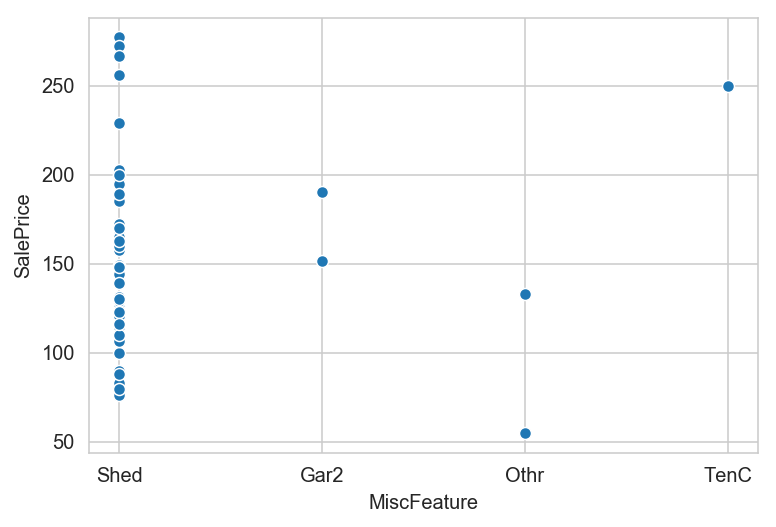

In [15]:
# Variance in SalePrice could be observed between the 4 categories, to tentative keep this variable and impute the missing
# values as NA.
# To be decided if should be dropped after feature selection

print(house[-house['MiscFeature'].isna()][['MiscFeature', 'SalePrice']].groupby('MiscFeature').mean())
sns.scatterplot(x= house['MiscFeature'], y = house['SalePrice'])
plt.show()

In [16]:
# To replace missing values with NA

house['MiscFeature'].fillna(value = 'NA', inplace = True)

In [17]:
# 94% missing data

house['Alley'].value_counts()

Grvl    50
Pave    39
Name: Alley, dtype: int64

        SalePrice
Alley            
Grvl   122.219080
Pave   172.955077


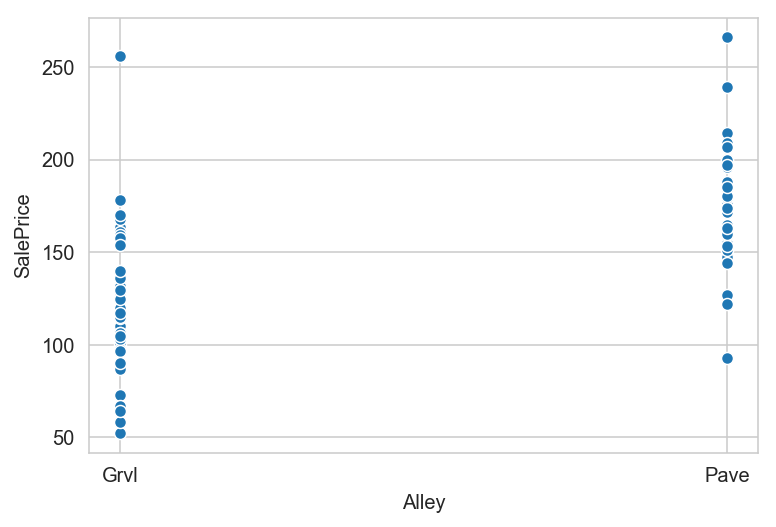

In [18]:
# Variance in SalePrice could be observed between the 2 categories, to tentative keep this variable and impute the missing
# values as NA.
# To be decided if should be dropped after feature selection

print(house[-house['Alley'].isna()][['Alley', 'SalePrice']].groupby('Alley').mean())
sns.scatterplot(x= house['Alley'], y = house['SalePrice'])
plt.show()

In [19]:
# To replace missing values with NA

house['Alley'].fillna(value = 'NA', inplace = True)

In [20]:
house['Alley'].value_counts()

NA      1361
Grvl      50
Pave      39
Name: Alley, dtype: int64

In [21]:
# 81% missing data

house['Fence'].value_counts()

MnPrv    155
GdPrv     59
GdWo      53
MnWw      11
Name: Fence, dtype: int64

        SalePrice
Fence            
GdPrv  178.927458
GdWo   142.369491
MnPrv  149.864006
MnWw   134.286364


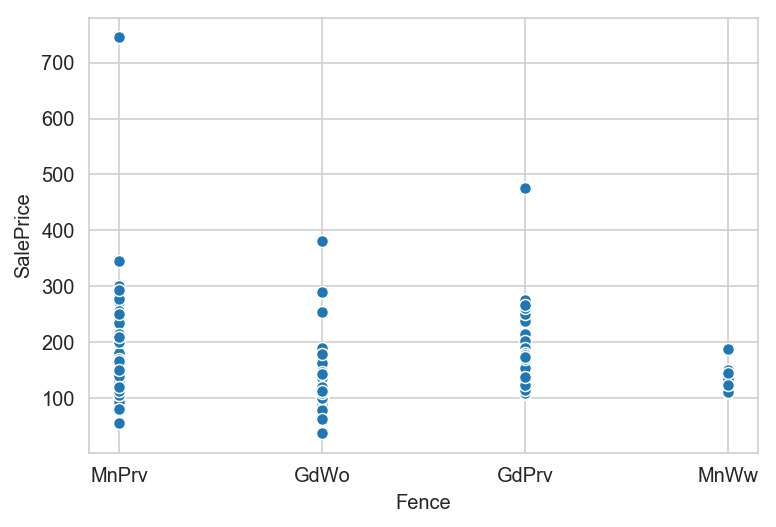

In [22]:
# Slight variation in SalePrice could be observed between the 4 categories, to tentative keep this variable and impute the missing
# values as NA.
# To be decided if should be dropped after feature selection

print(house[-house['Fence'].isna()][['Fence', 'SalePrice']].groupby('Fence').mean())
sns.scatterplot(x= house['Fence'], y = house['SalePrice'])
plt.show()

In [23]:
# To replace missing values with NA

house['Fence'].fillna(value = 'NA', inplace = True)

In [24]:
house['Fence'].value_counts()

NA       1172
MnPrv     155
GdPrv      59
GdWo       53
MnWw       11
Name: Fence, dtype: int64

**FireplaceQU Missing Values**

In [25]:
house['FireplaceQu'].value_counts()

Gd    379
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

In [26]:
# All 681 (47%) of NaN data for FireplaceQu have value 0 for Fireplaces, which mean the houses have no fireplaces
# Hence to impupte NaN values with NA (No Fireplace)

house[house['FireplaceQu'].isna()]['Fireplaces'].value_counts()

0    681
Name: Fireplaces, dtype: int64

In [27]:
# To replace missing values with NA

house['FireplaceQu'].fillna(value = 'NA', inplace = True)

In [28]:
house['FireplaceQu'].value_counts()

NA    681
Gd    379
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

**Imputing the rest of Missing Values with NA**

In [29]:
# based on judgement, the NaN values for the following parameters should also be replaced with 'NA'

na_list = ['GarageType', 'GarageFinish', 'GarageCond', 'GarageQual', 'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 
           'BsmtCond', 'BsmtQual']

[house[col].fillna(value = 'NA', inplace = True) for col in na_list]

# check no more missing values for the columns in na_list
assert([house[col].isna().sum() == 0 for col in na_list])

**MasVnrType and MasVnrArea Missing Values**

In [30]:
# 8 MasVnrType entries with NaN values have NaN values too for MasVnrArea
# Based on judgement, the NaN values in MasVnrType were meant to be 'None' option as the houses highly likely do not have
# a masonry veneer

house[house['MasVnrType'].isna()]['MasVnrArea']

231    NaN
525    NaN
645    NaN
928    NaN
965    NaN
969    NaN
1234   NaN
1269   NaN
Name: MasVnrArea, dtype: float64

In [31]:
# To replace missing values with 'None'

house['MasVnrType'].fillna(value = 'None', inplace = True)

# check no more missing values
assert(house['MasVnrType'].isna().sum() == 0)

In [32]:
# Likewise, 8 MasVnrArea entries with NaN values have NaN values too for MasVnrType
# Missing values to be replaced with 0 as the houses highly likely do not have a masonry veneer

house[house['MasVnrArea'].isna()]['MasVnrType']

231     None
525     None
645     None
928     None
965     None
969     None
1234    None
1269    None
Name: MasVnrType, dtype: object

In [33]:
# To replace missing values with 0

house['MasVnrArea'].fillna(value = 0, inplace = True)

# check no more missing values
assert(house['MasVnrType'].isna().sum() == 0)

In [34]:
# This looks ok, majority houses with 0 MasVnrArea have no MasVnrType
# The two other entries could be that the MasVnrType have very small area (close to 0), or erroneous entries
# To remain as it is

house[house['MasVnrArea']==0]['MasVnrType'].value_counts()

None       857
BrkFace      1
Stone        1
Name: MasVnrType, dtype: int64

In [35]:
# This looks ok, majority houses with 'None' MasVnrType have 0 MasVnrArea
# The other 5 entries could be that the MasVnrTypes are none of the options stated, or erroneous entries
# To remain as it is

house[house['MasVnrType']=='None']['MasVnrArea'].value_counts()

0.0      857
1.0        2
312.0      1
344.0      1
288.0      1
Name: MasVnrArea, dtype: int64

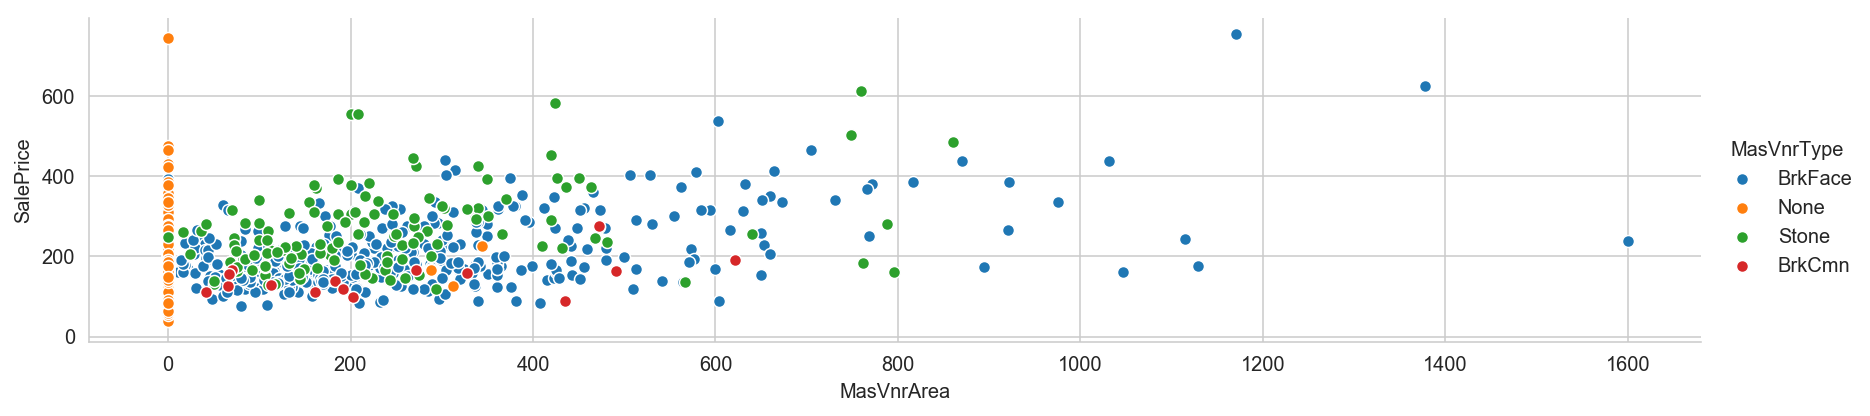

In [36]:
# Plotting this chart helps to visualise the points mentioned above

sns.pairplot(data = house, x_vars='MasVnrArea', y_vars='SalePrice', height = 3, aspect = 4, hue = 'MasVnrType')
plt.show()

**GarageYrBlt Missing Values**

In [37]:
# There are 79 missing values for GarageYrBlt

house['GarageYrBlt'].isna().sum()

79

In [38]:
# All 79 houses with missing values for GarageYrBlt do not have a garage

house[house['GarageYrBlt'].isna()]['GarageType'].value_counts()

NA    79
Name: GarageType, dtype: int64

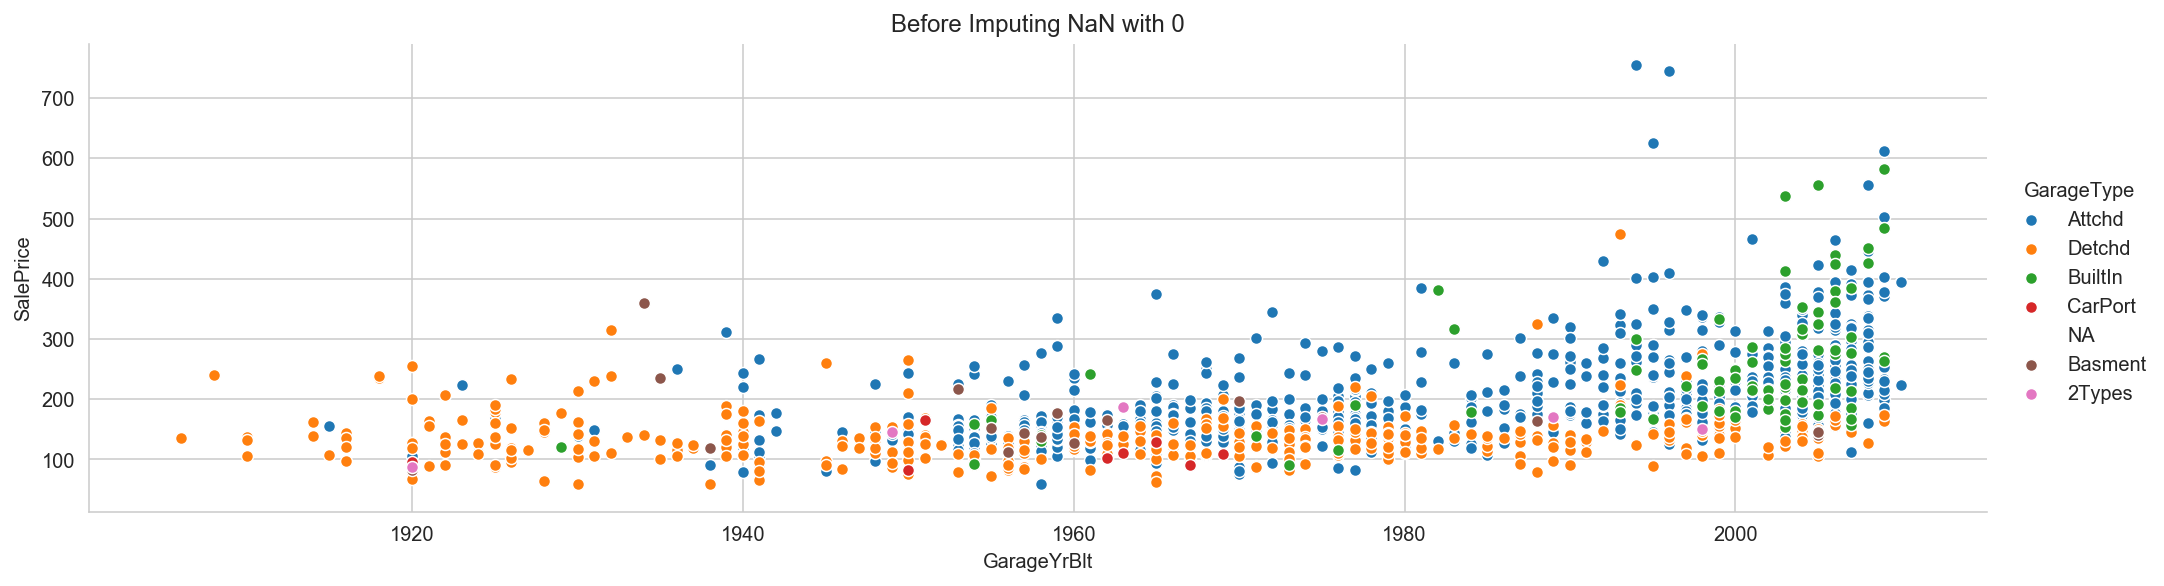

In [39]:
# If we were to impute these 79 missing values with 0 and treating GarageYrBlt as a continuous variable, the data will 
# be wrongly skewed.

# Based on the chart, the prices seem quite consistent from 1920 to 2000. No sign of linear increase trend in prices
# Houses with garage built after 2000 seems to be more expensive.
# Hence, i will treat GarageYrBlt as a categorical feature with 3 categories i.e.
#    i) Bef2000 (Garage built < year 2000)
#    ii) Aft2000 (Garage built >= year 2000)
#    iii) NA (No Garage)

# This new feature will compare the prices for old garage, new garage and no garage.

sns.pairplot(data = house, x_vars='GarageYrBlt', y_vars='SalePrice', hue= 'GarageType', height = 4, aspect = 3.5)
plt.title('Before Imputing NaN with 0')

plt.show()

In [40]:
# Replace GarageYrBlt as a categorical feature with 3 categories i.e.
#    i) Bef2000 (Garage built < year 2000)
#    ii) Aft2000 (Garage built >= year 2000)
#    iii) NA (No Garage)

house['GarageYrBlt'] = ['Bef2000' if i < 2000 else 'Aft2000' if i >= 2000 else 'NA' for i in house['GarageYrBlt']]

In [41]:
# Check new GarageYrBlt values

house['GarageYrBlt'].value_counts()

Bef2000    969
Aft2000    402
NA          79
Name: GarageYrBlt, dtype: int64

**LotFrontage Missing Values**

In [42]:
# There are 259 (18%) null entries for LotFrontage

house['LotFrontage'].isna().sum()

259

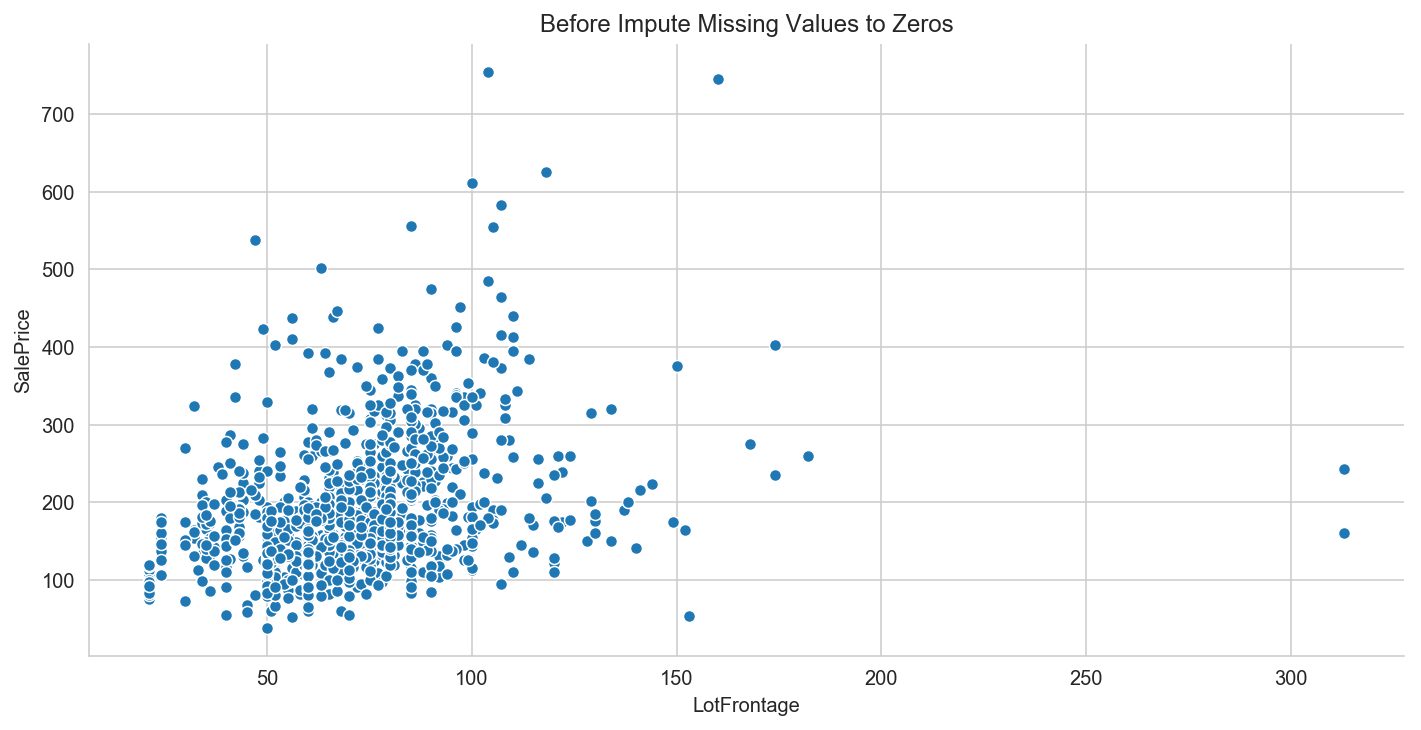

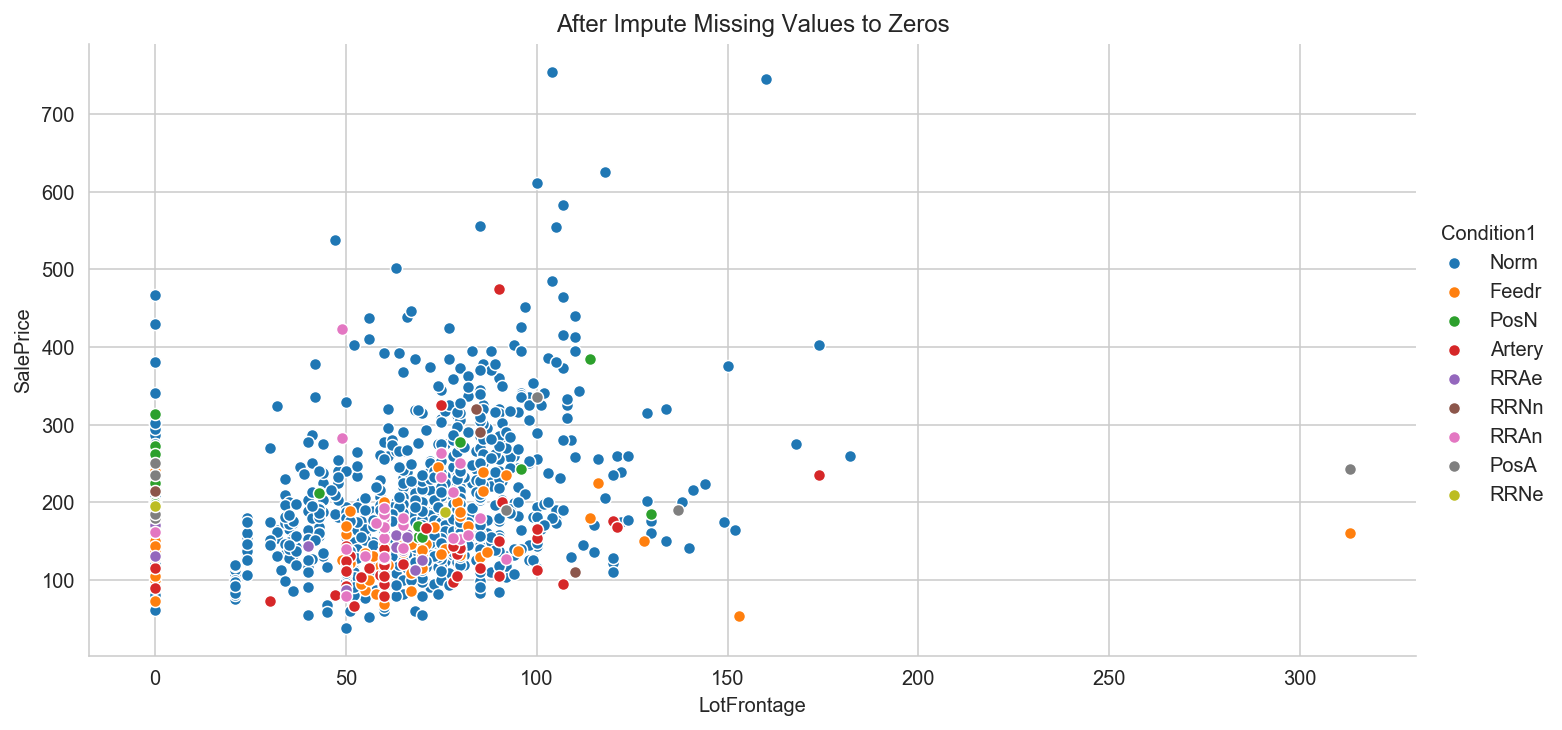

In [43]:
# To check if should impute missing values of LotFrontage with 0 based on the assumption that the missing values were 
#    meant to be zero as there is no linear street connected to property...

sns.pairplot(data = house, x_vars='LotFrontage', y_vars='SalePrice', height = 5, aspect = 2,)
plt.title('Before Impute Missing Values to Zeros')

house['LotFrontage'].fillna(0, inplace = True)
sns.pairplot(data = house, x_vars='LotFrontage', y_vars='SalePrice', height = 5, aspect = 2, hue = 'Condition1')
plt.title('After Impute Missing Values to Zeros')

plt.show()

In [44]:
# Based on the second chart, the missing values of LotFrontage are unlikely to be 0 as some houses with missing 
# LotFrontage values are adjacent to arterial/feeder streets or rail roads.

# Hence the assummption that missing values = 0 may not be so true.

# To consider imputing missing values with median value.

# Not going to consider imputing with predictions from a model as based on the chart the lotfrontage doesnt seem to have 
# a very obvious pattern with sale price. Furthermore logically doesnt really make much sense that the prices are
# heavily dependent on lotfrontage.

In [45]:
# To convert back the zero values to the original np.nan

house['LotFrontage'] = house['LotFrontage'].apply(lambda x: np.nan if x == 0 else x)

In [46]:
# LotFrontage is not very linearly correlated with any other features, hence imputing with another linear model may not
# be optimum.

house.corr()['LotFrontage'].abs().sort_values(ascending = False).head()

LotFrontage    1.000000
1stFlrSF       0.459003
LotArea        0.425810
GrLivArea      0.405956
TotalBsmtSF    0.392776
Name: LotFrontage, dtype: float64

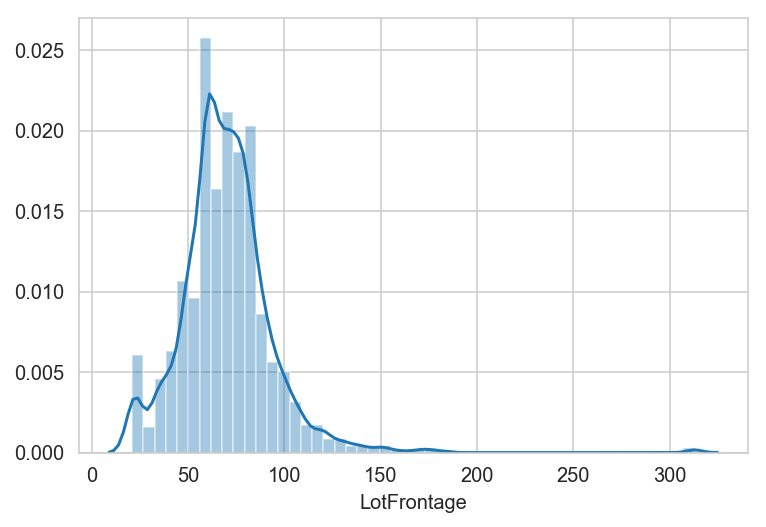

In [47]:
# LotFrontage seems to follow a normal distribution.
# Hence, made an assumption to replace the missing values with median value instead.

sns.distplot(house['LotFrontage'].dropna())

plt.show()

In [48]:
# To replace missing values with Median

house['LotFrontage'].fillna(house['LotFrontage'].median(), inplace = True)

**Electrical Missing Value**

In [49]:
# only 1 NaN value from Electrical

house['Electrical'].isna().sum()

1

In [50]:
# Majority values of Electrical = SBrkr, hence to replace NaN with SBrkr (mode value)
# Assumption is ok as whatever change to only 1 entry will be insignificant to my prediction model

house['Electrical'].value_counts()

SBrkr    1328
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [51]:
# To replace missing values with 'SBrkr' (Mode value)

house['Electrical'].fillna(value = 'SBrkr', inplace = True)

# check no more missing values
assert(house['Electrical'].isna().sum() == 0)

In [52]:
# Check no more missing values

house.isna().sum().sort_values(ascending = False).head(3)

SalePrice        0
SaleCondition    0
RoofStyle        0
dtype: int64

# EDA

C:\Users\Jiahao\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


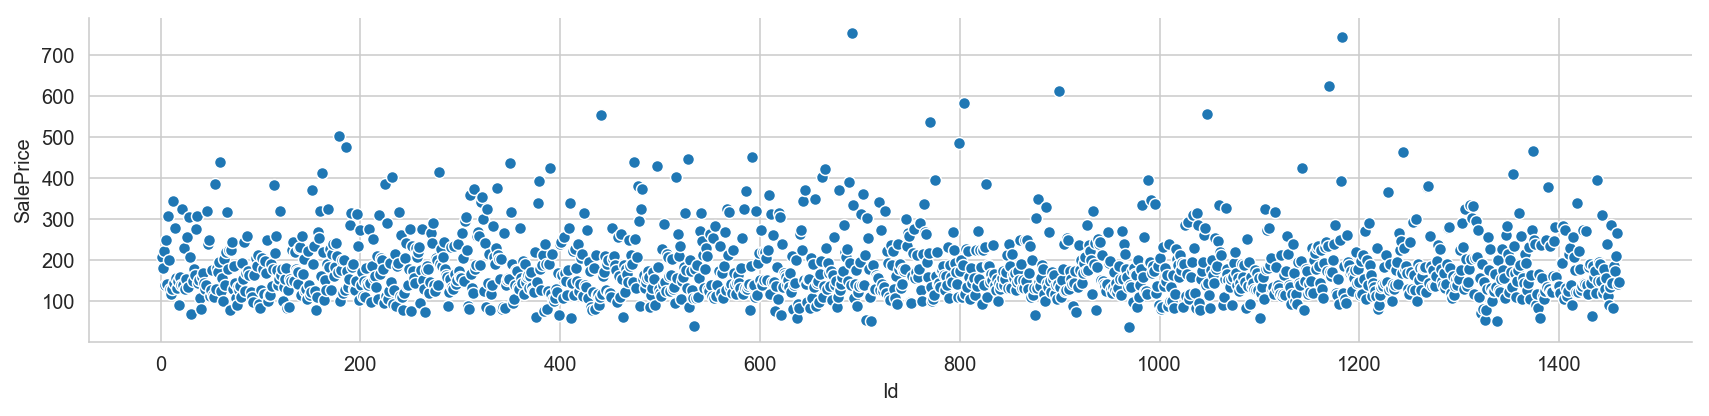

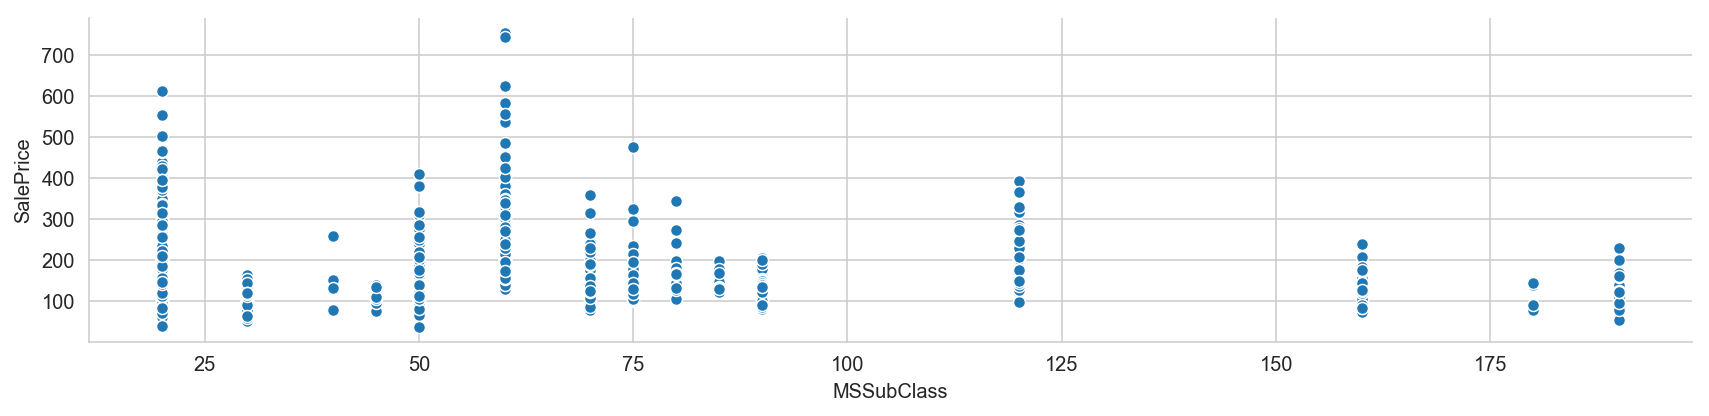

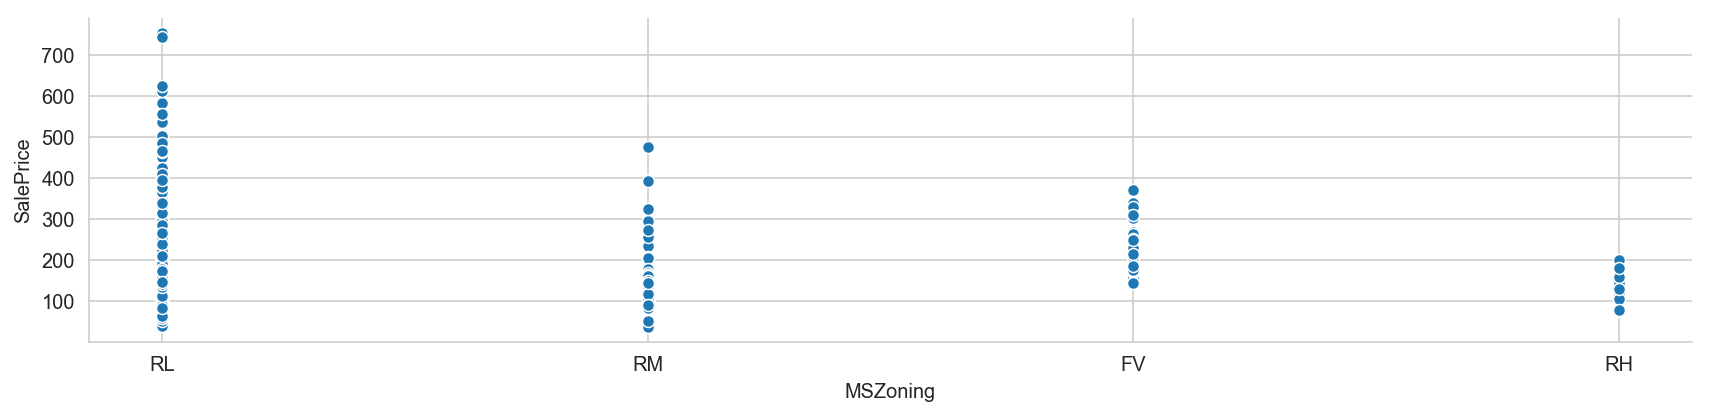

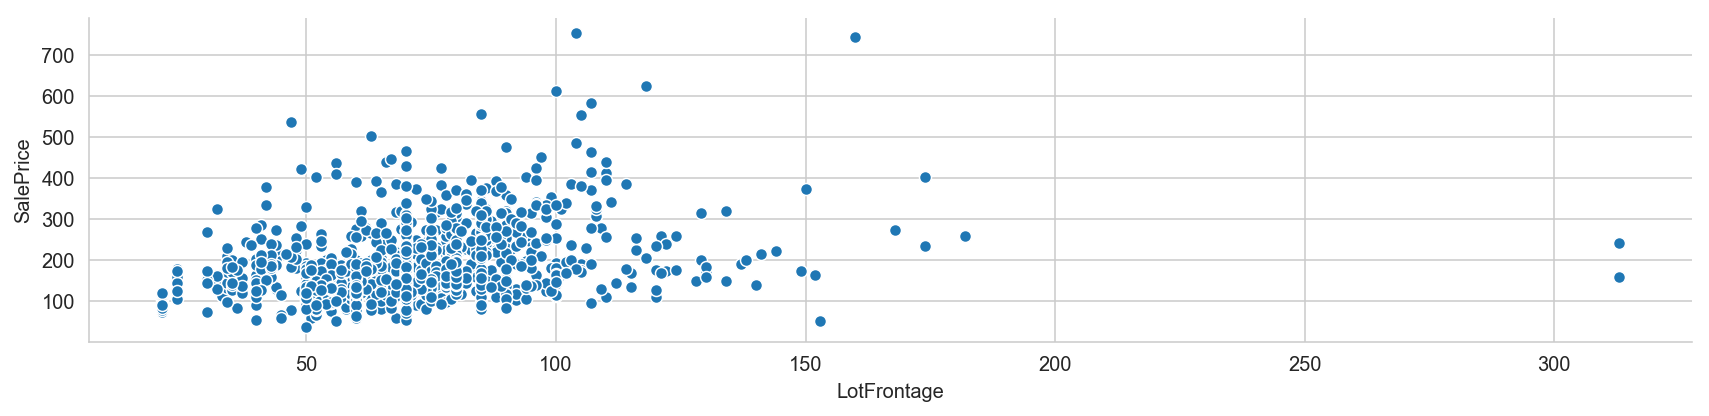

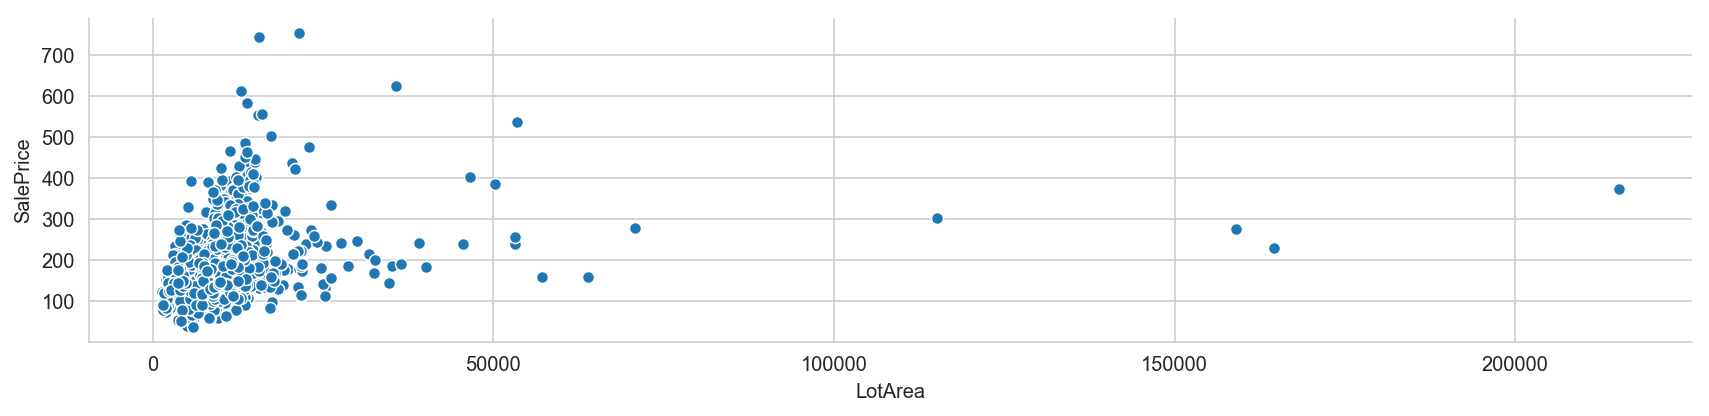

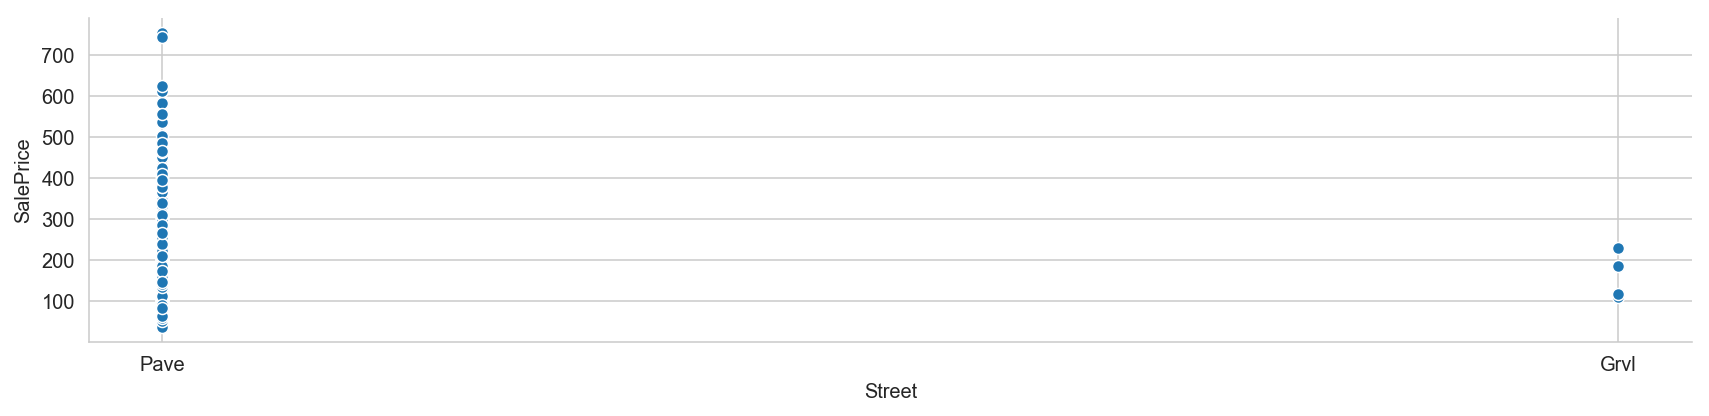

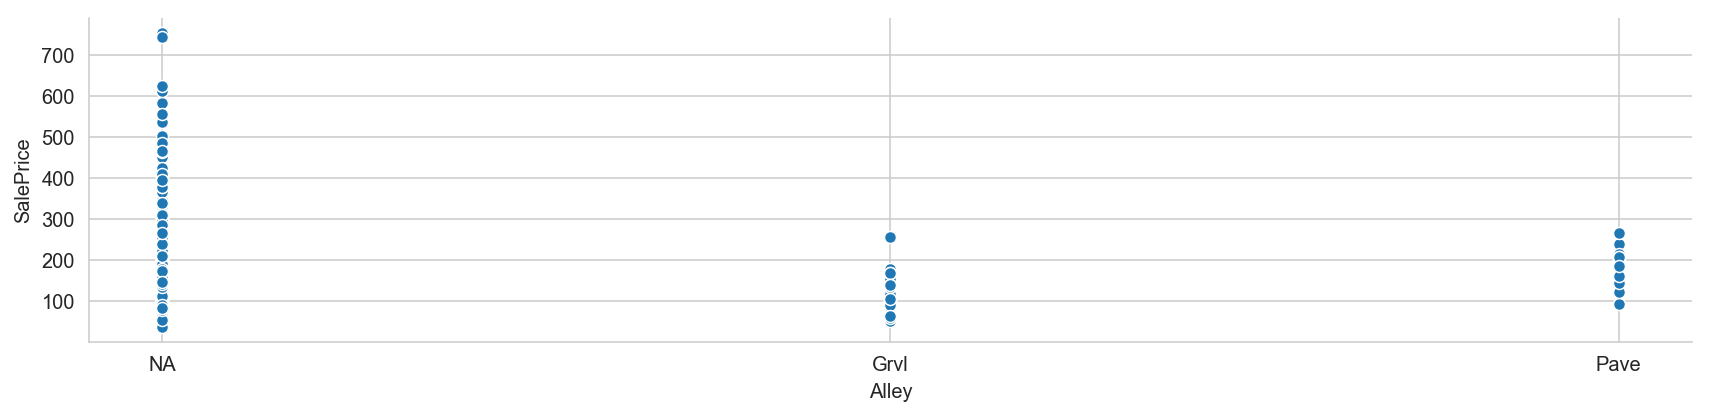

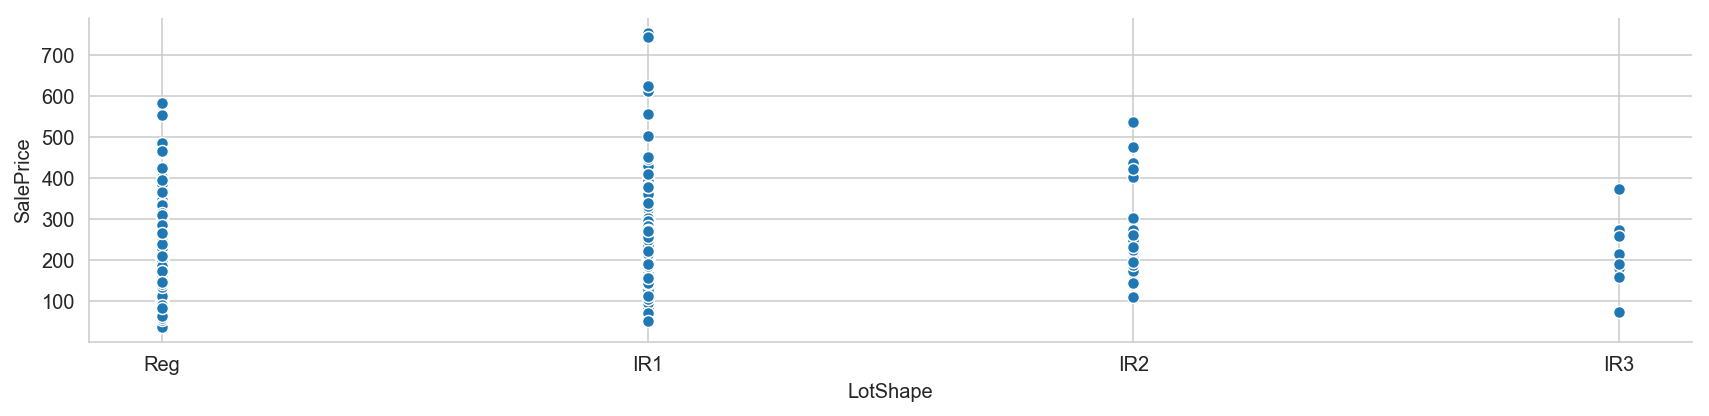

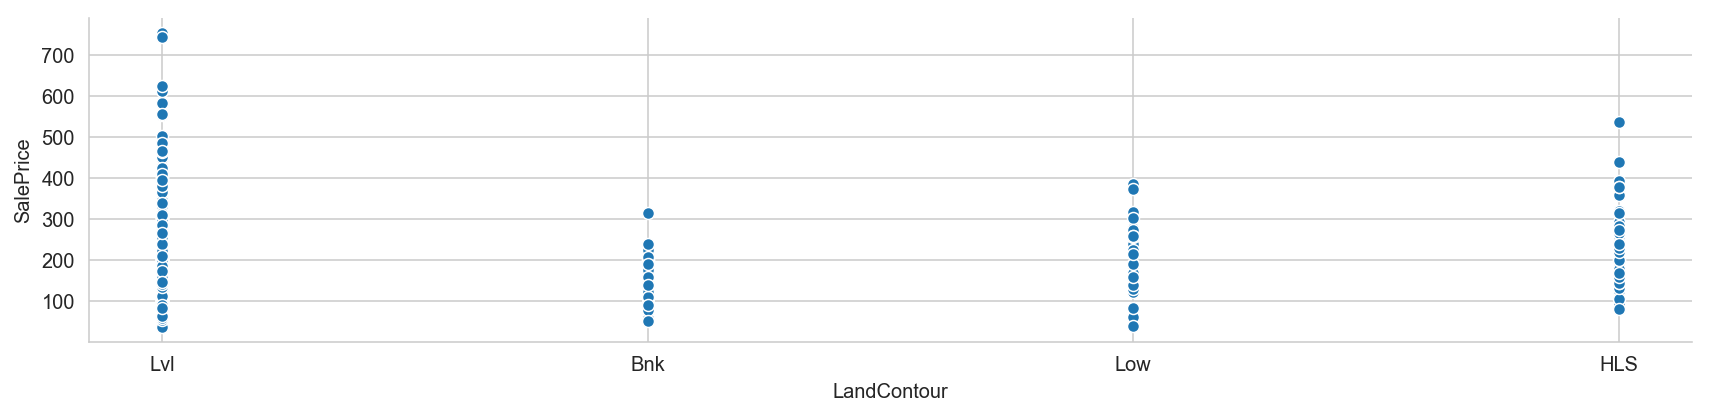

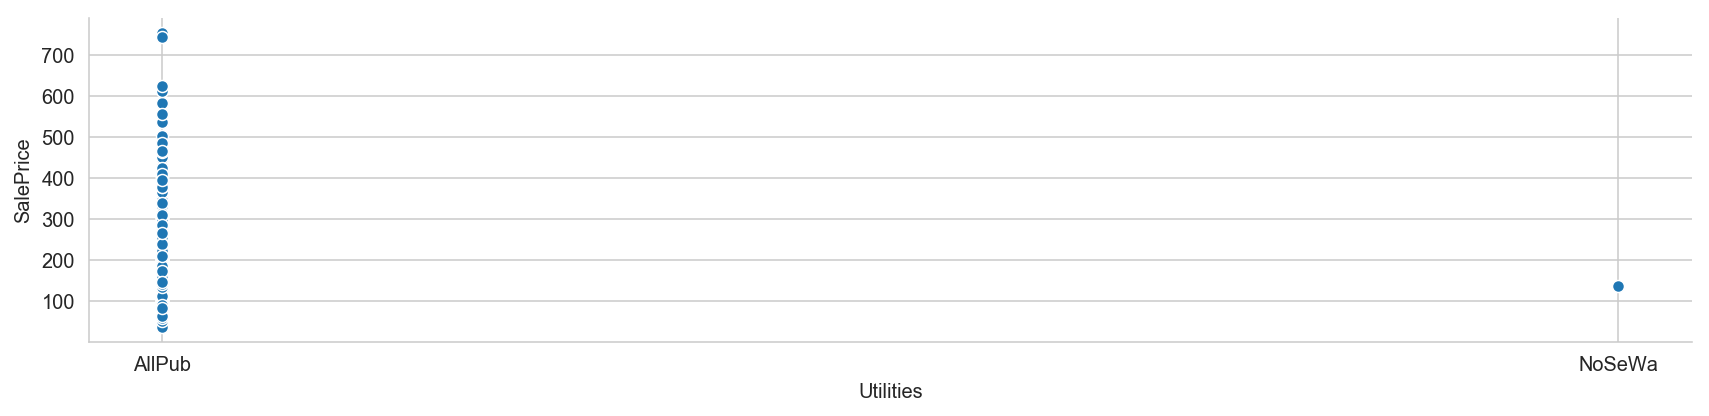

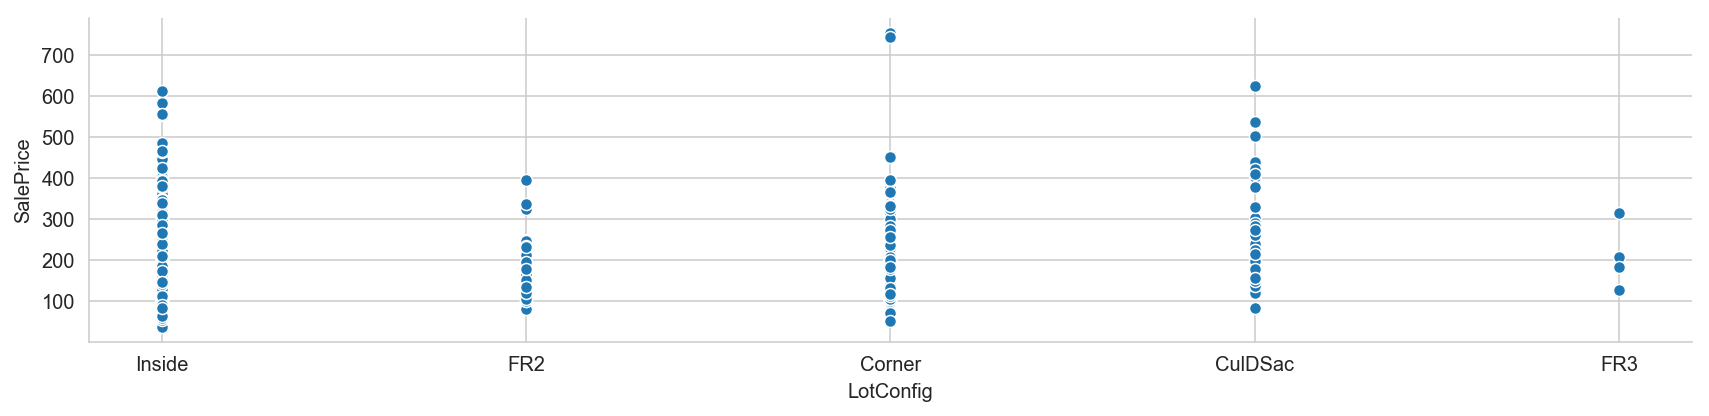

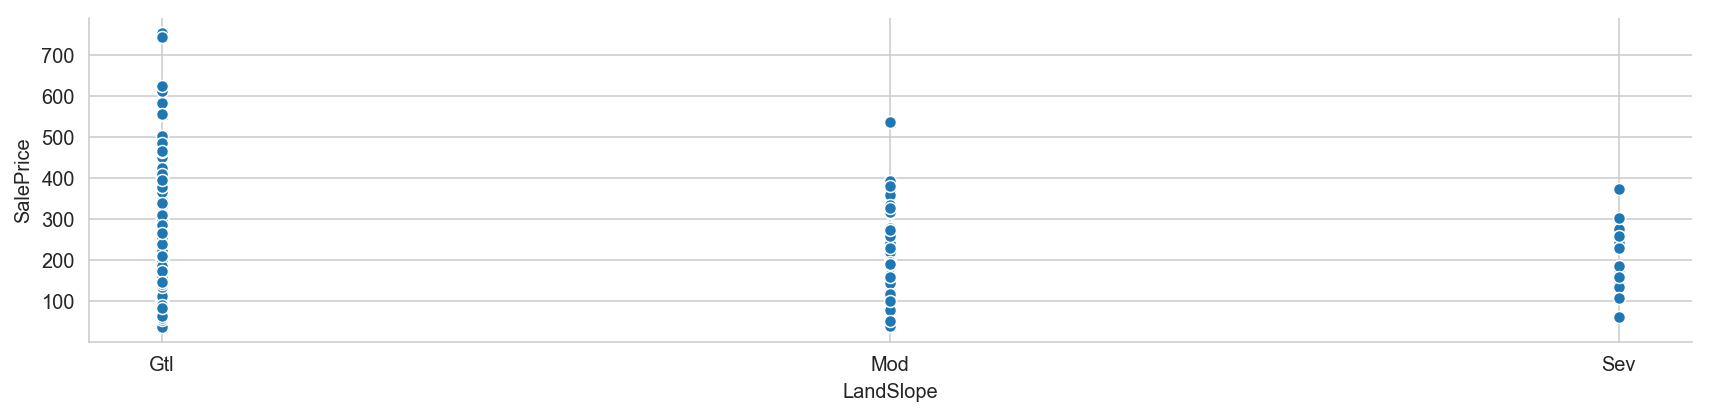

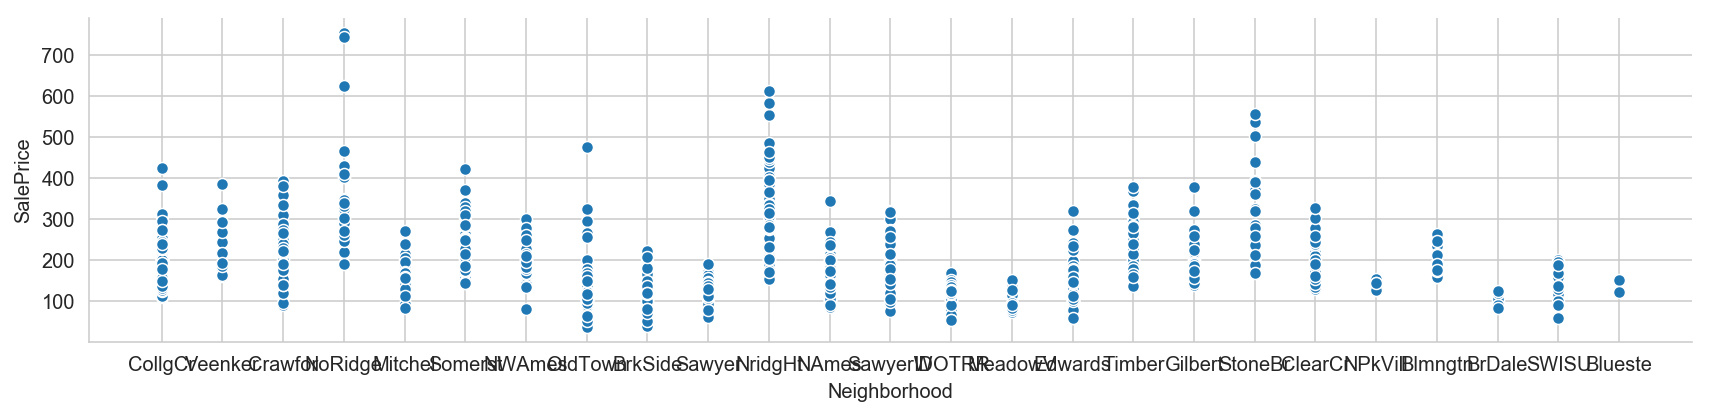

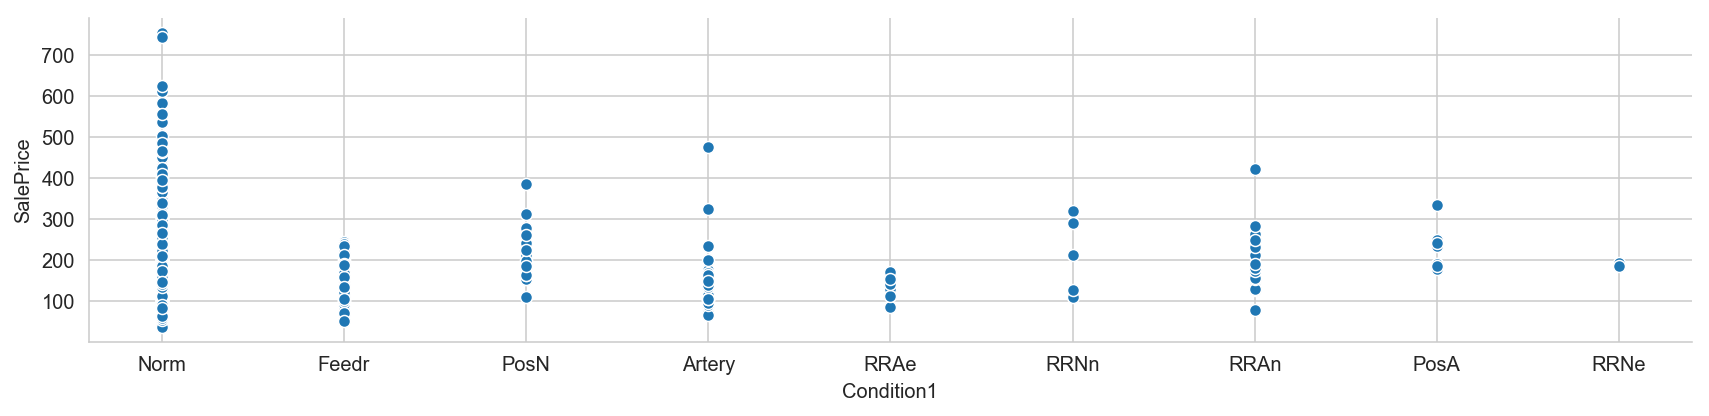

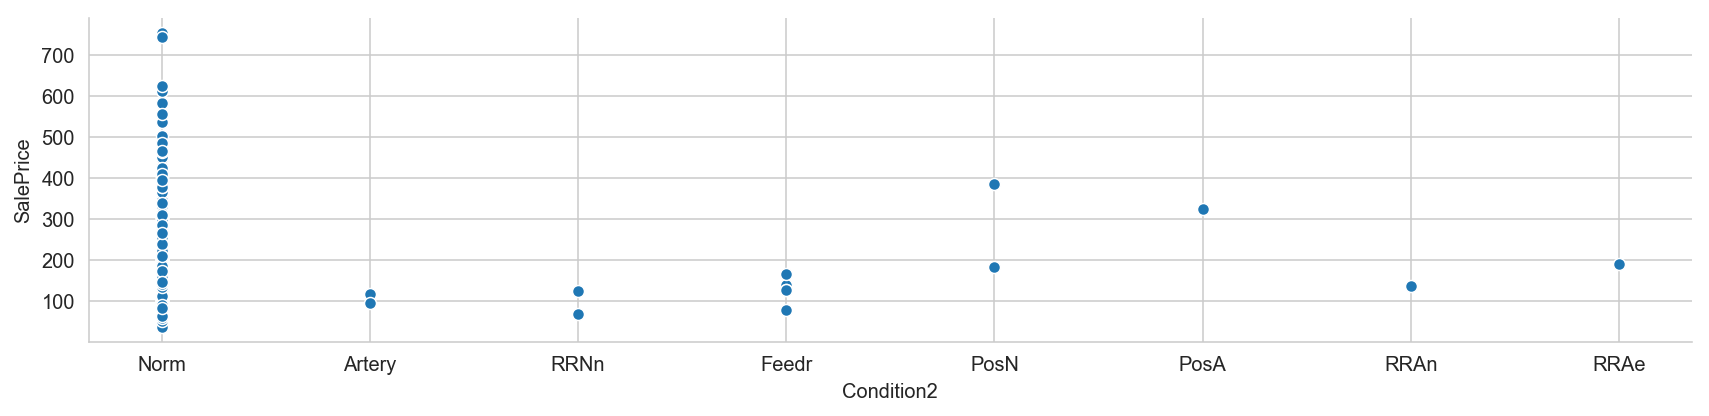

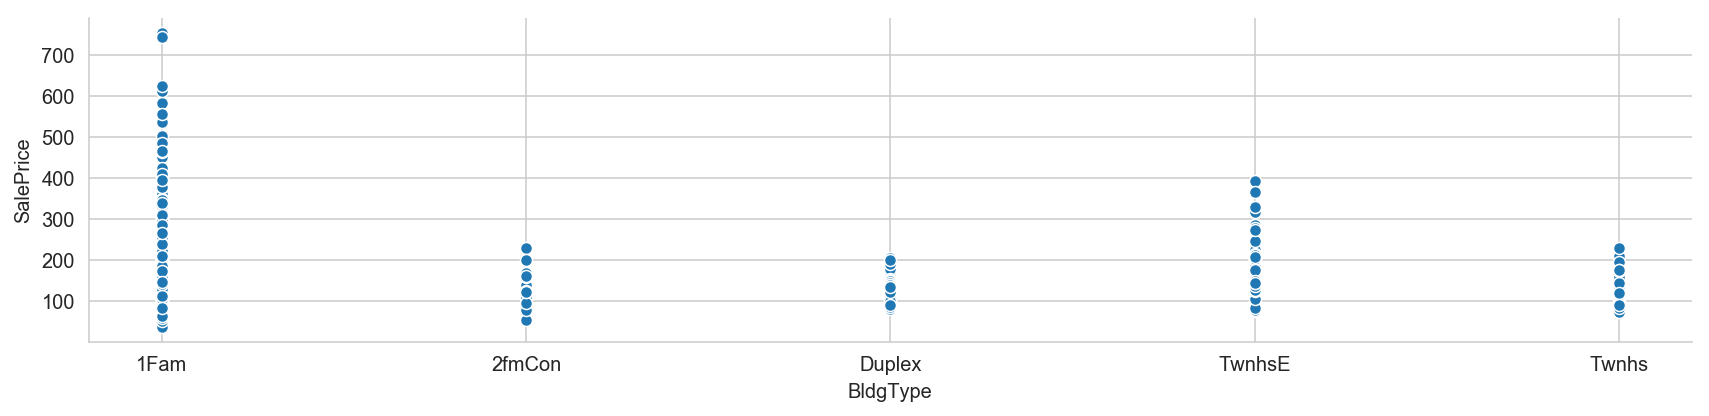

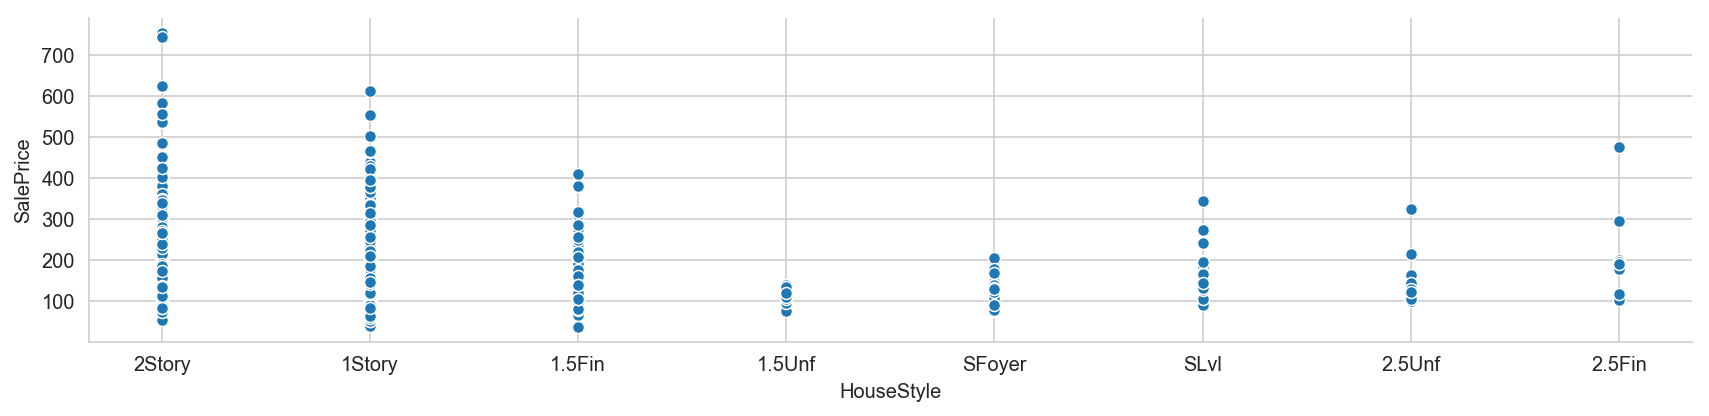

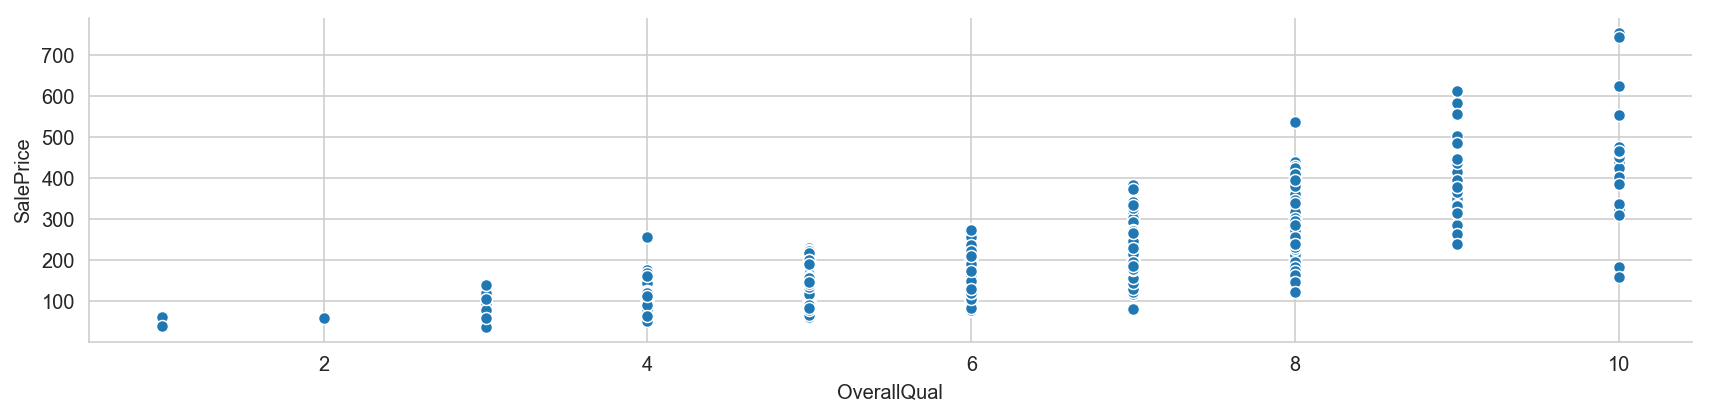

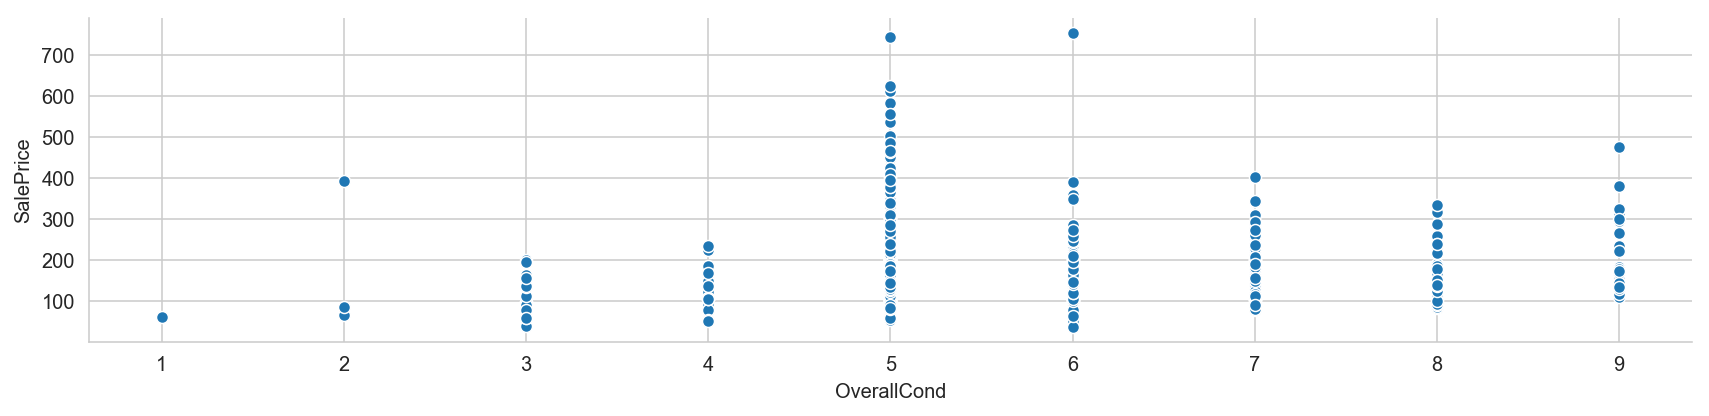

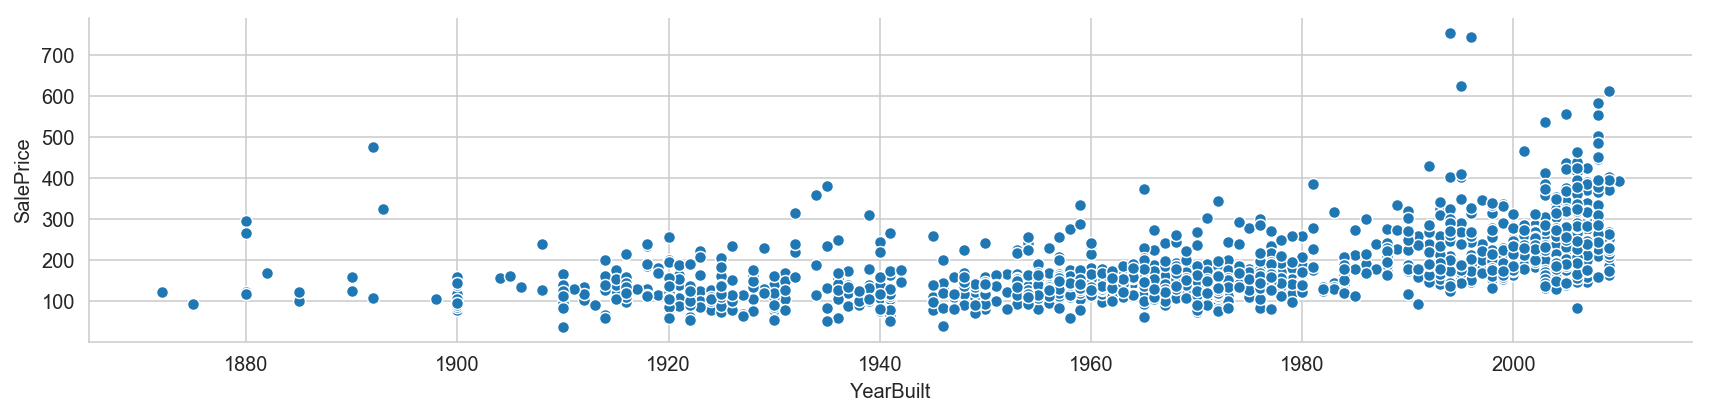

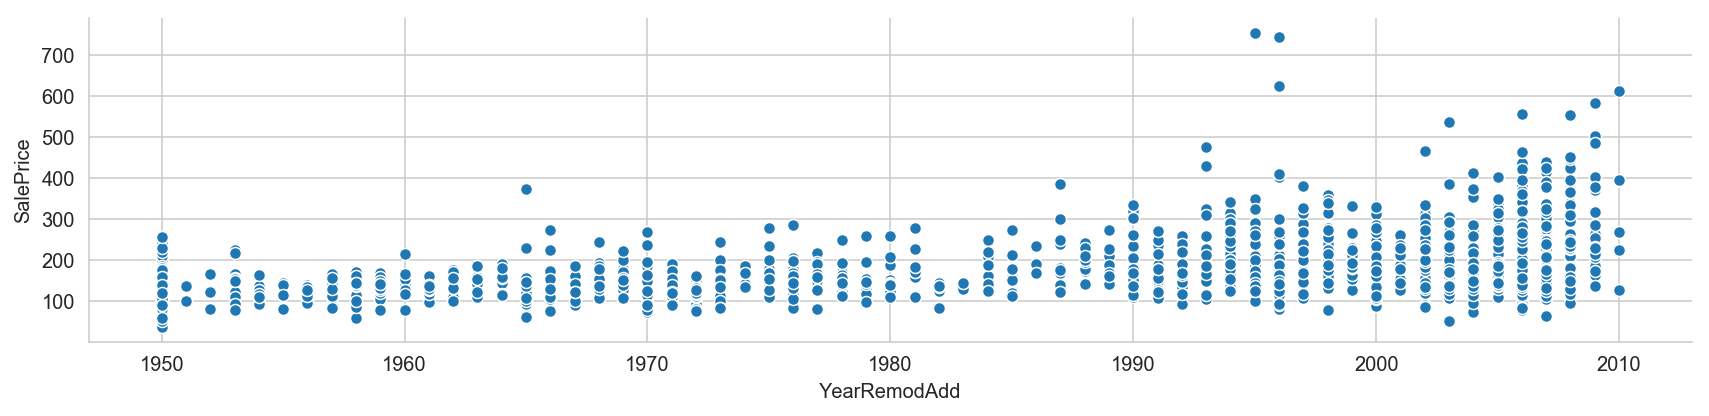

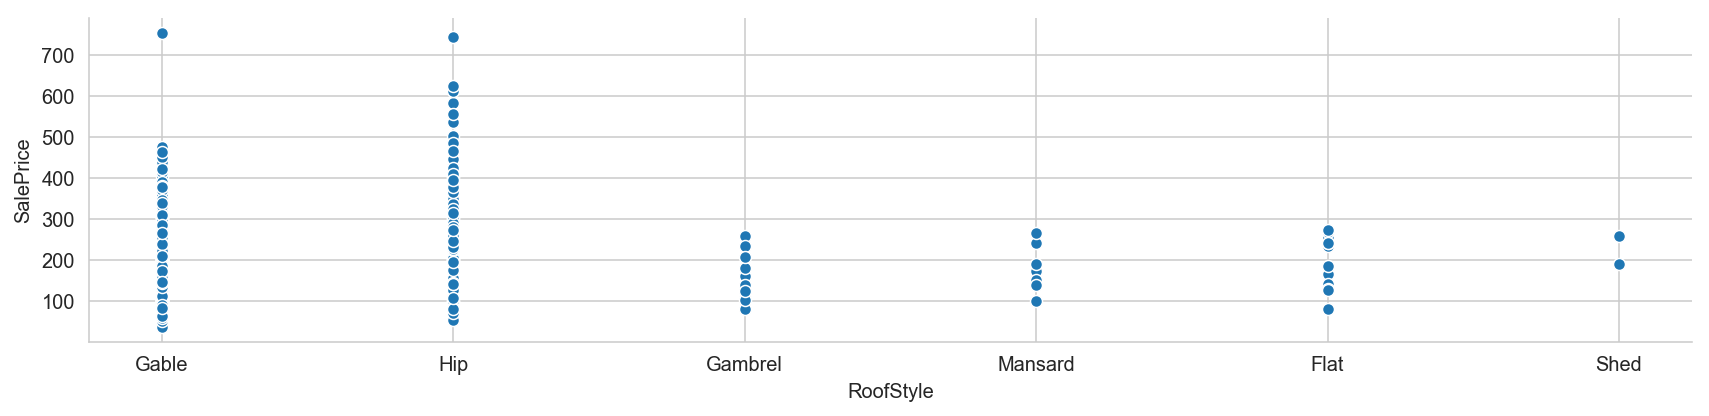

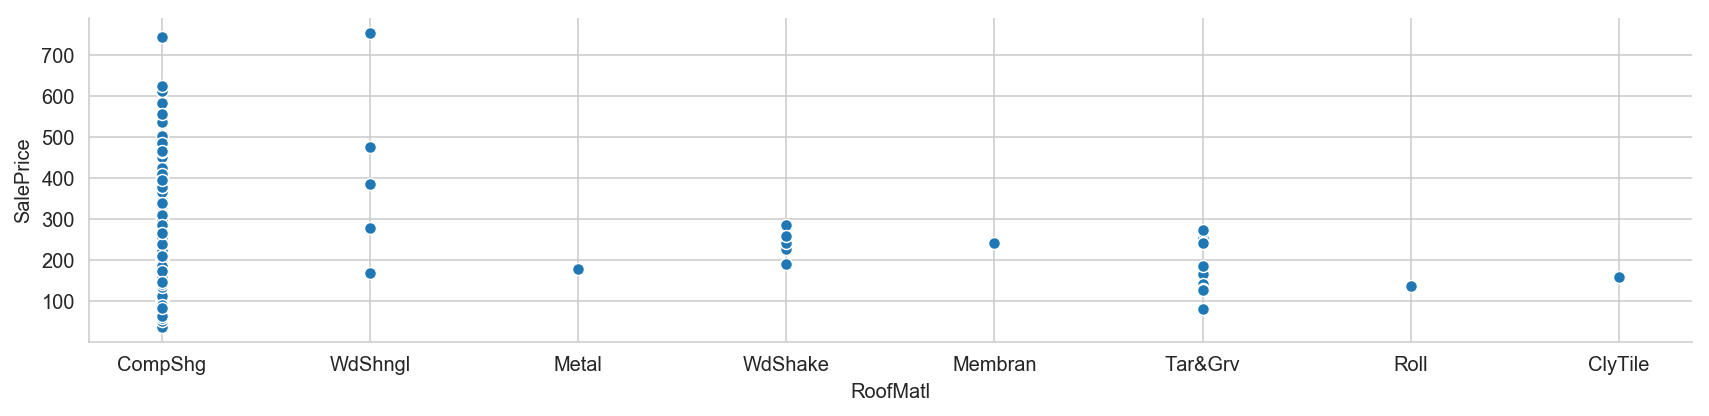

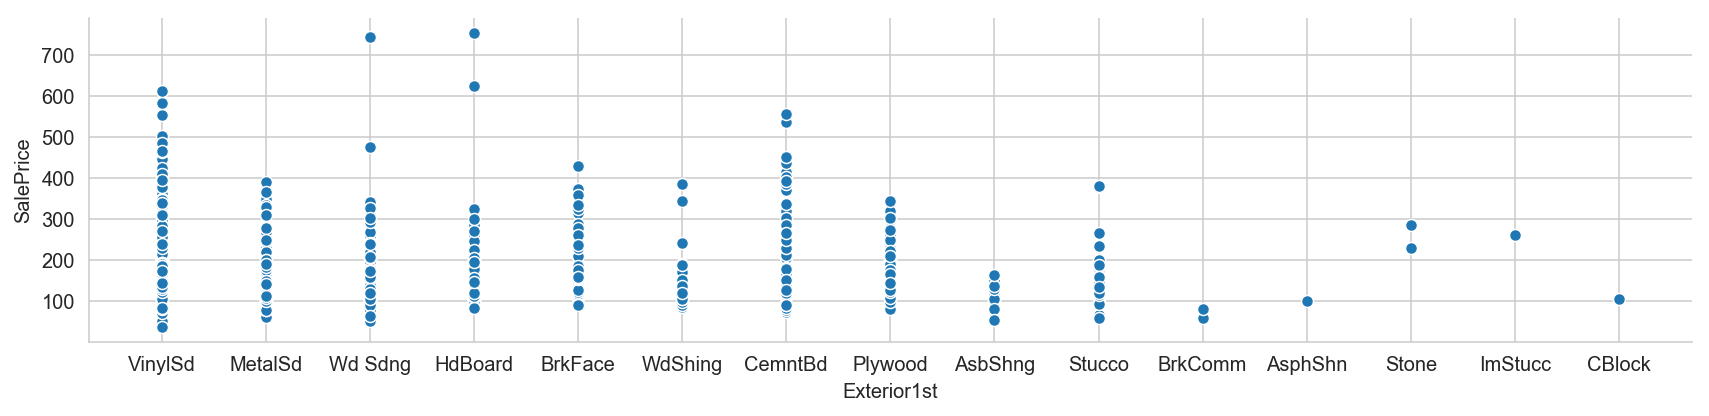

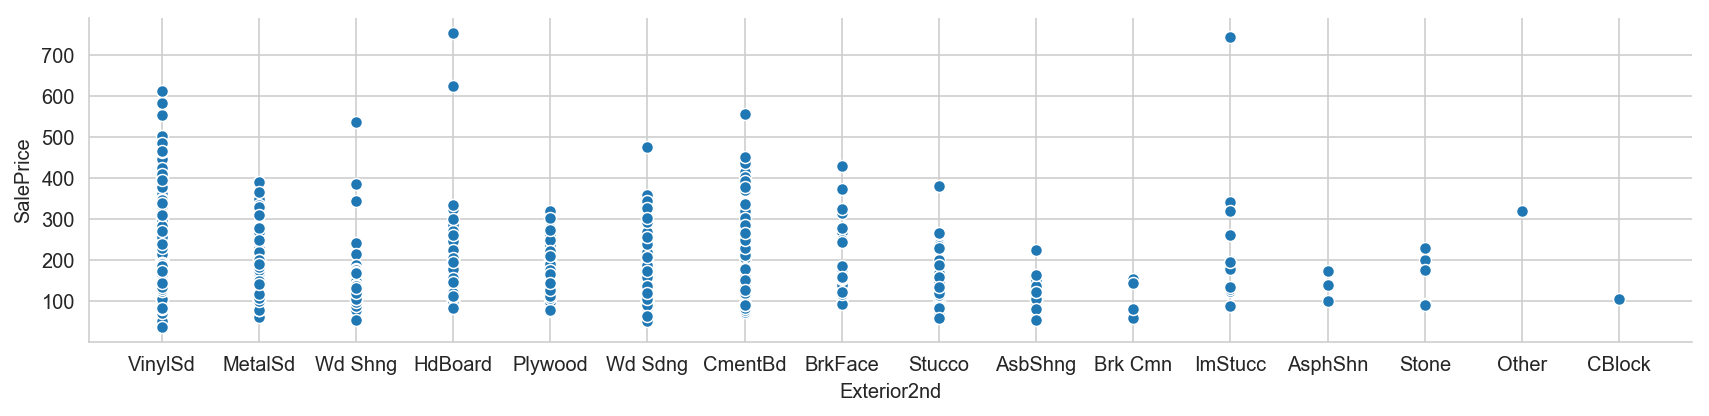

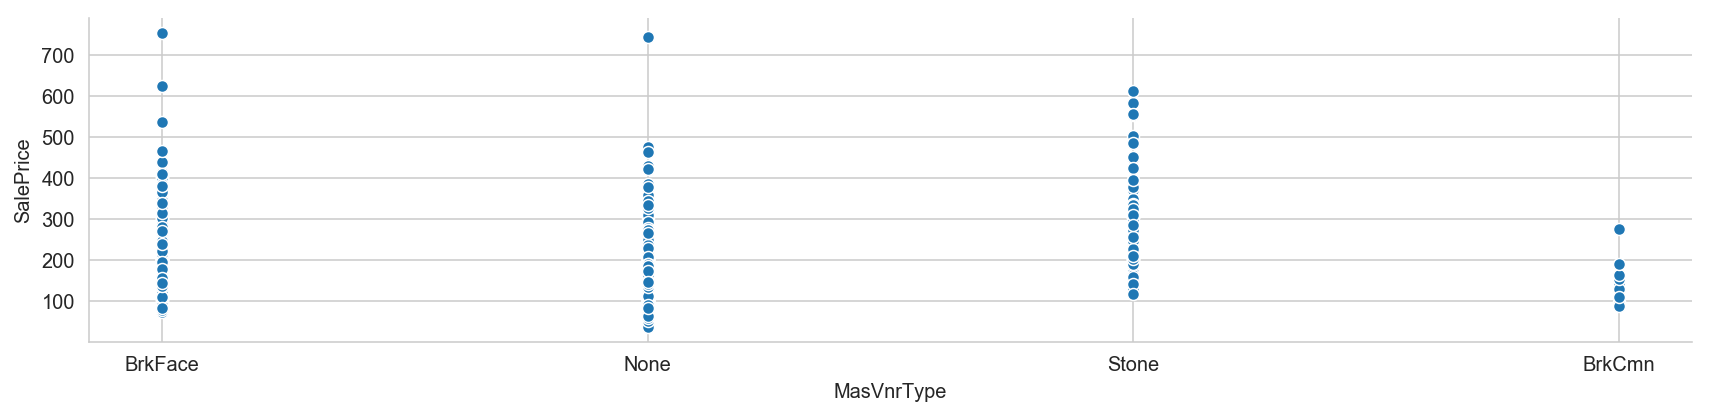

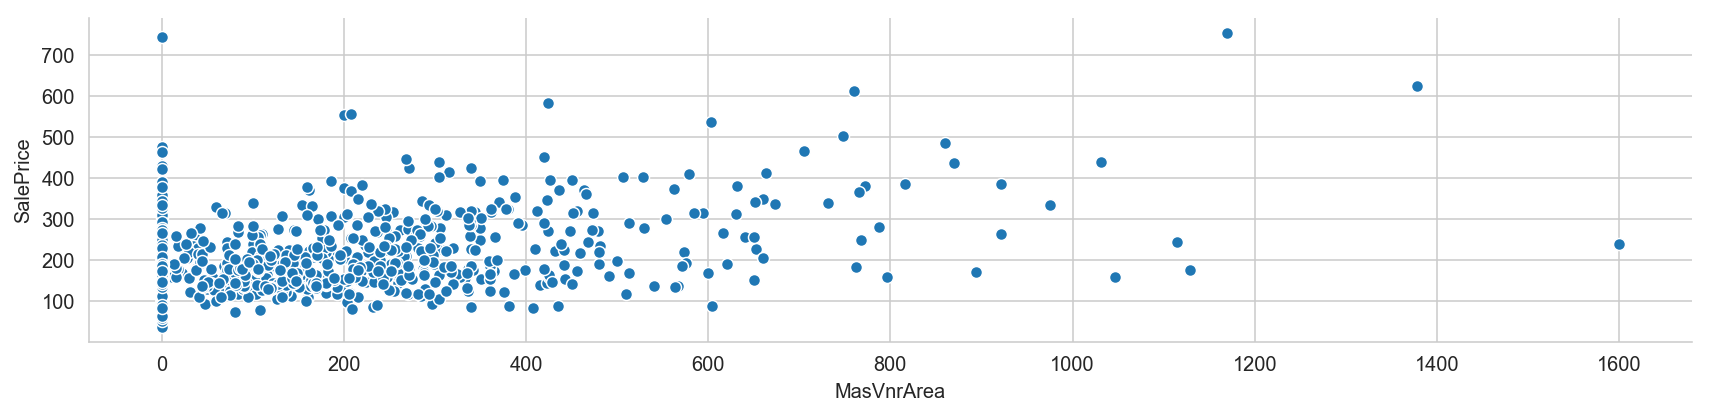

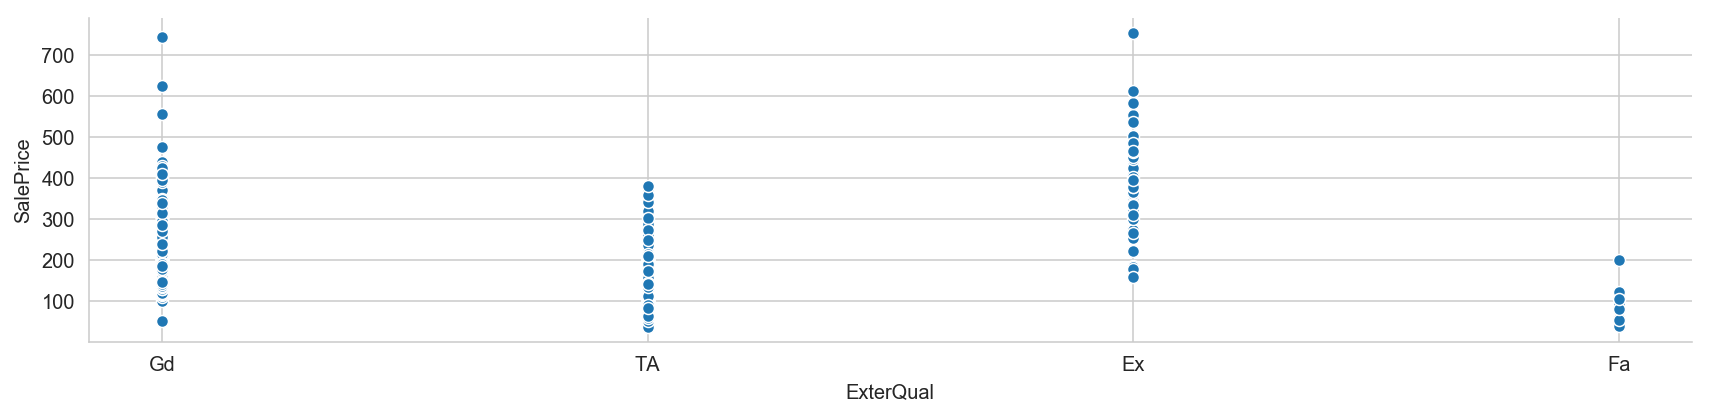

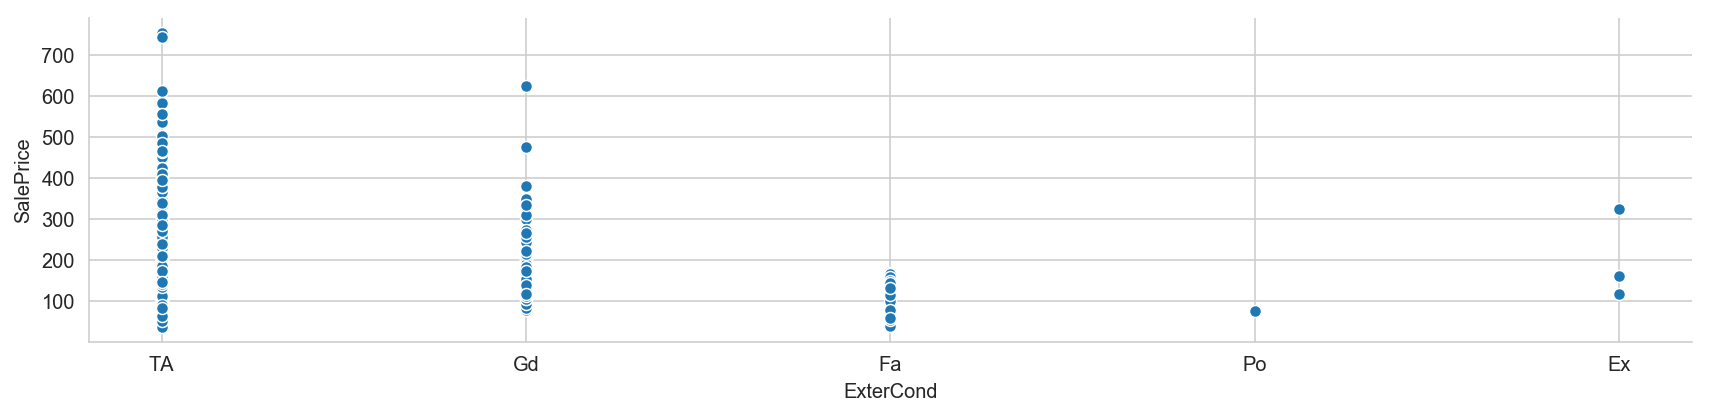

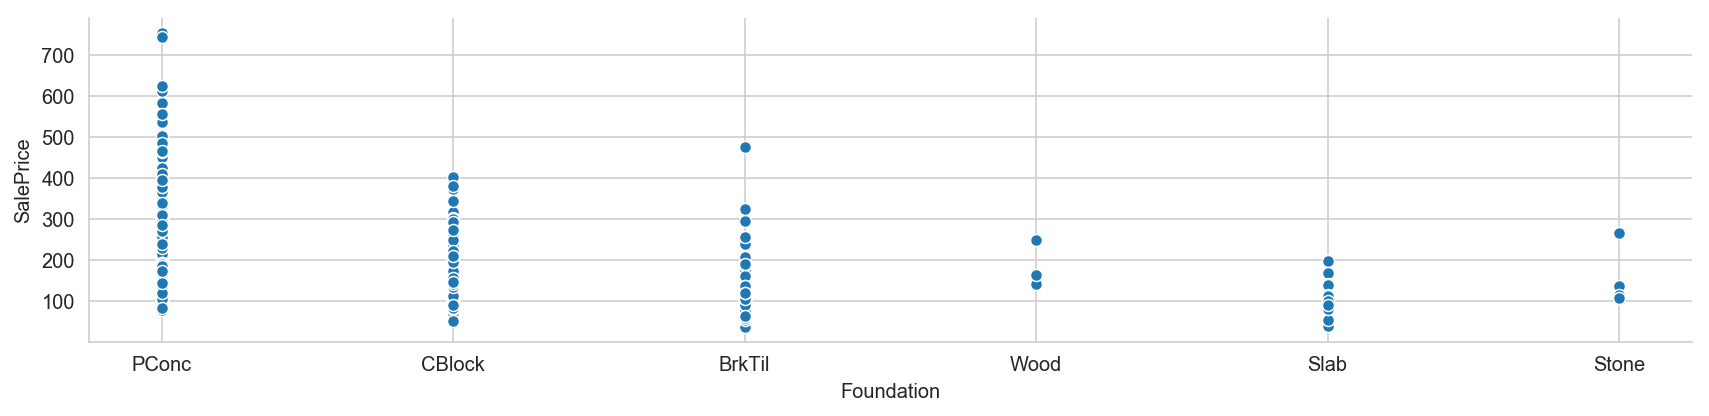

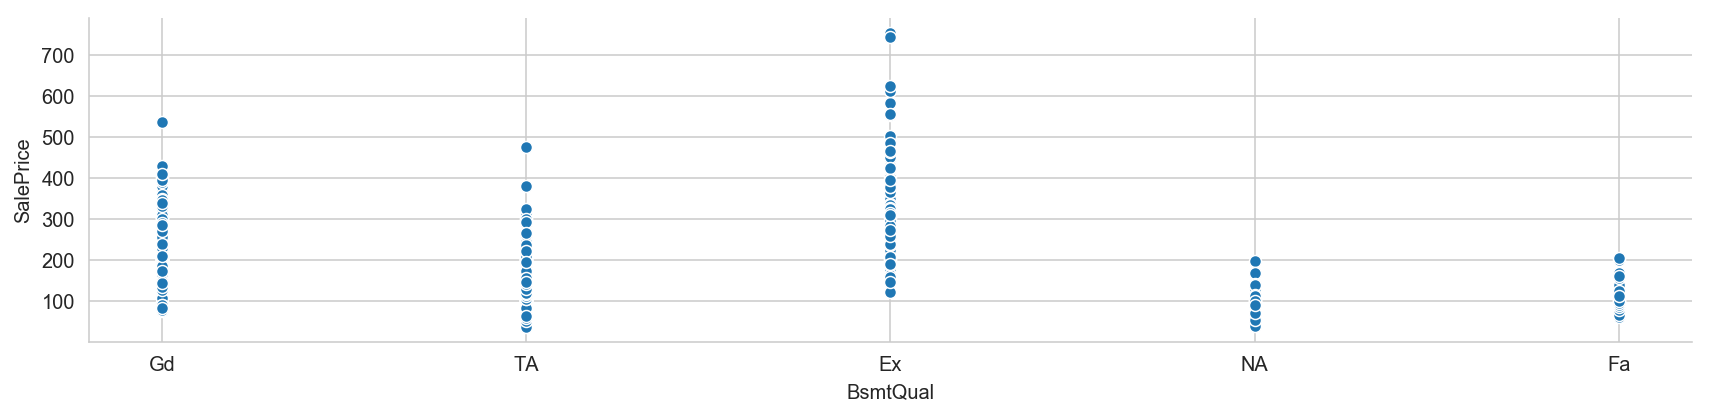

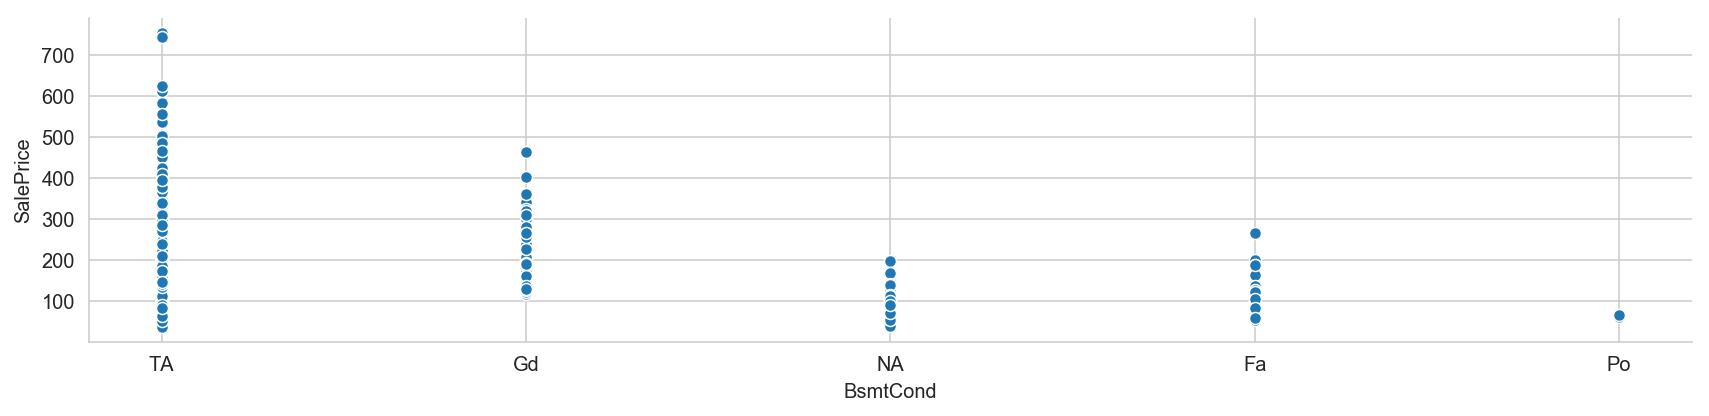

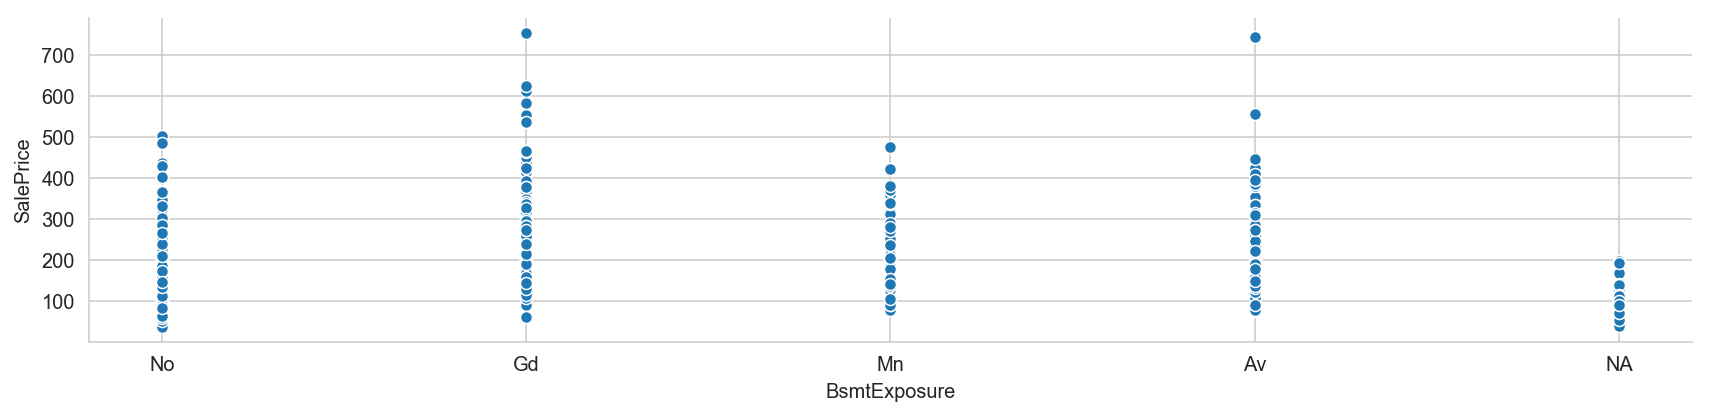

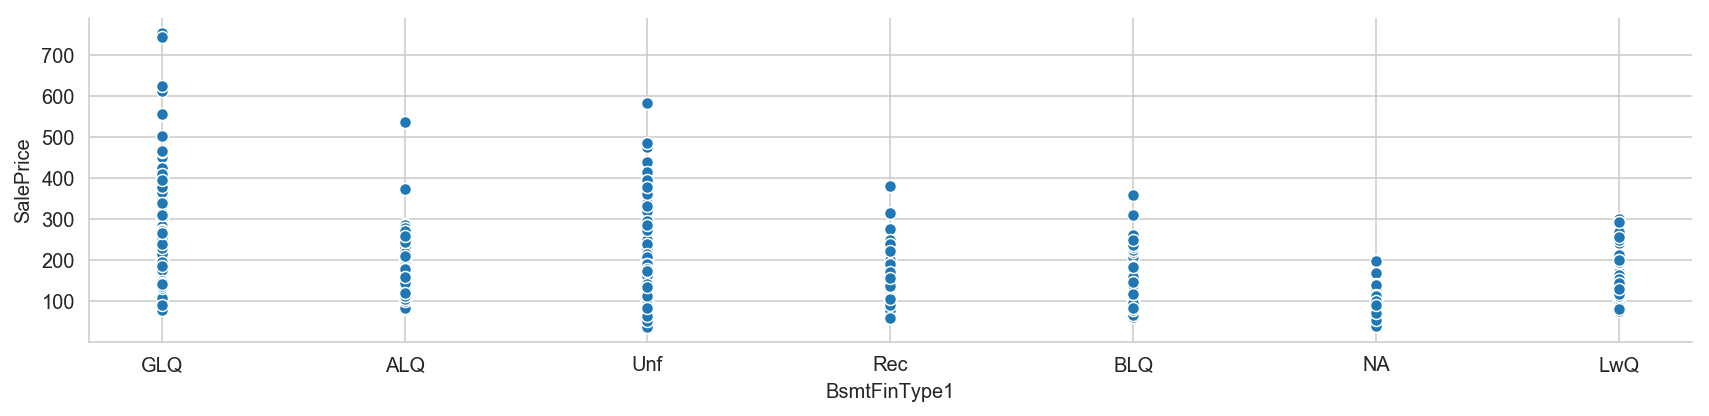

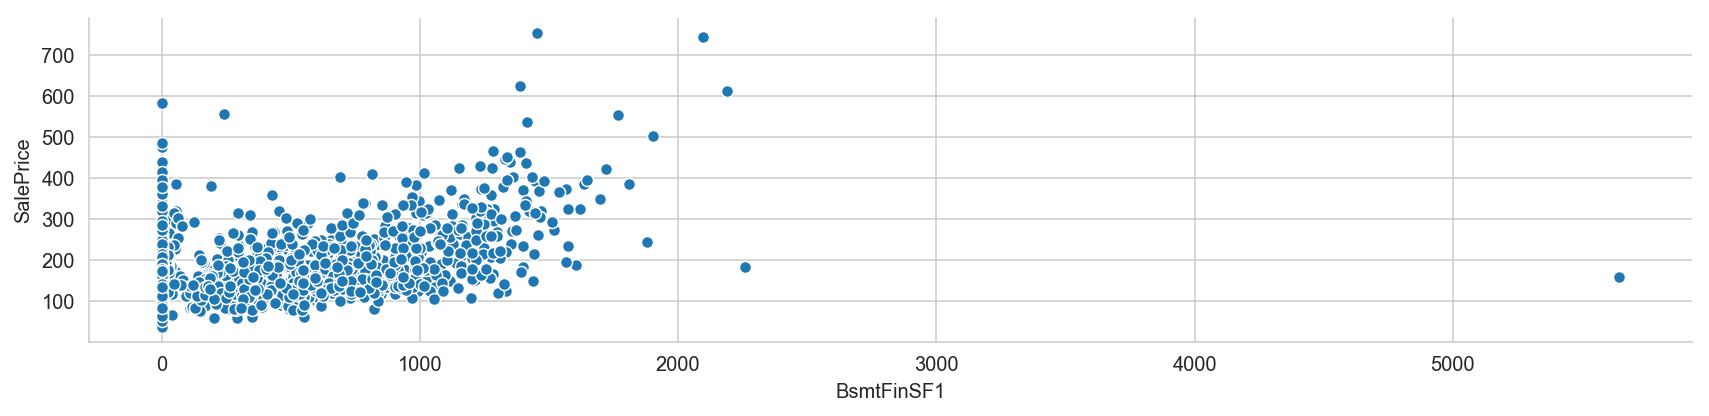

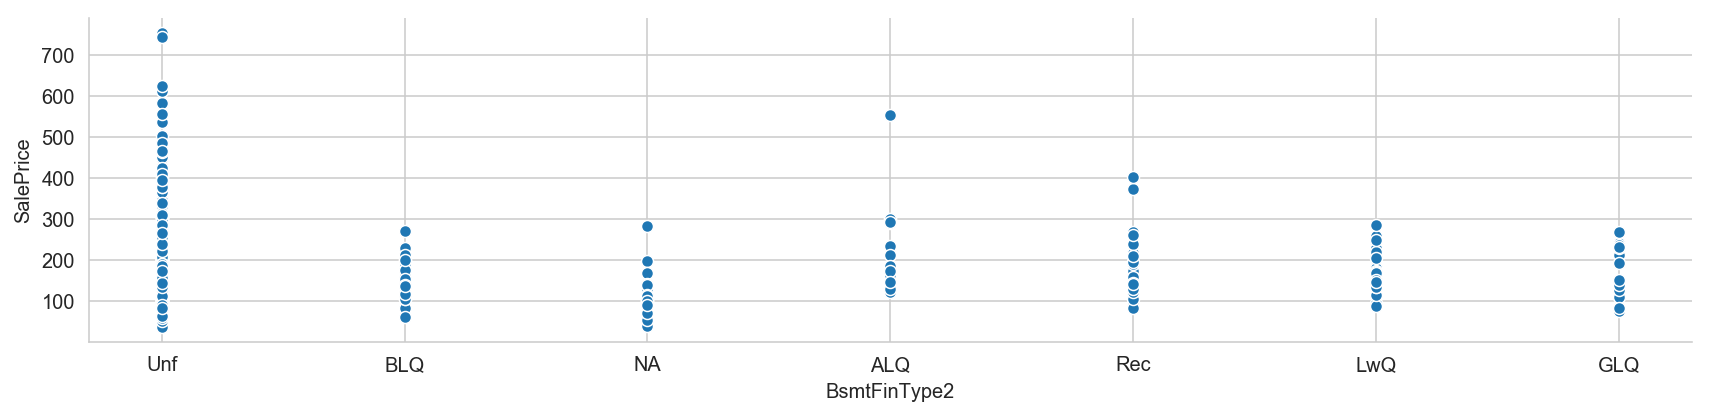

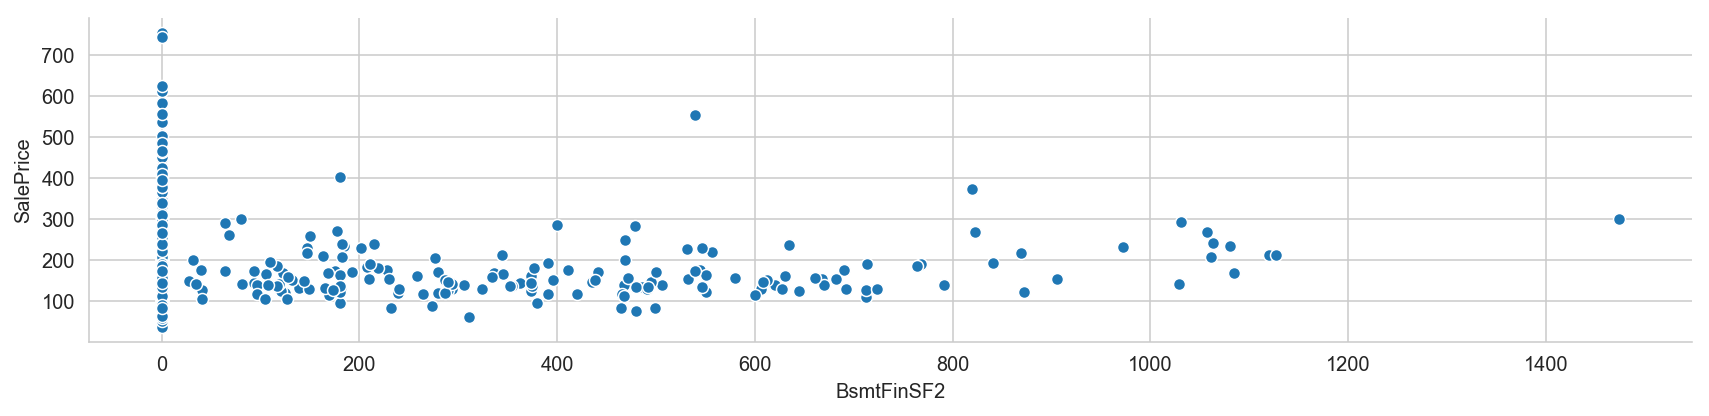

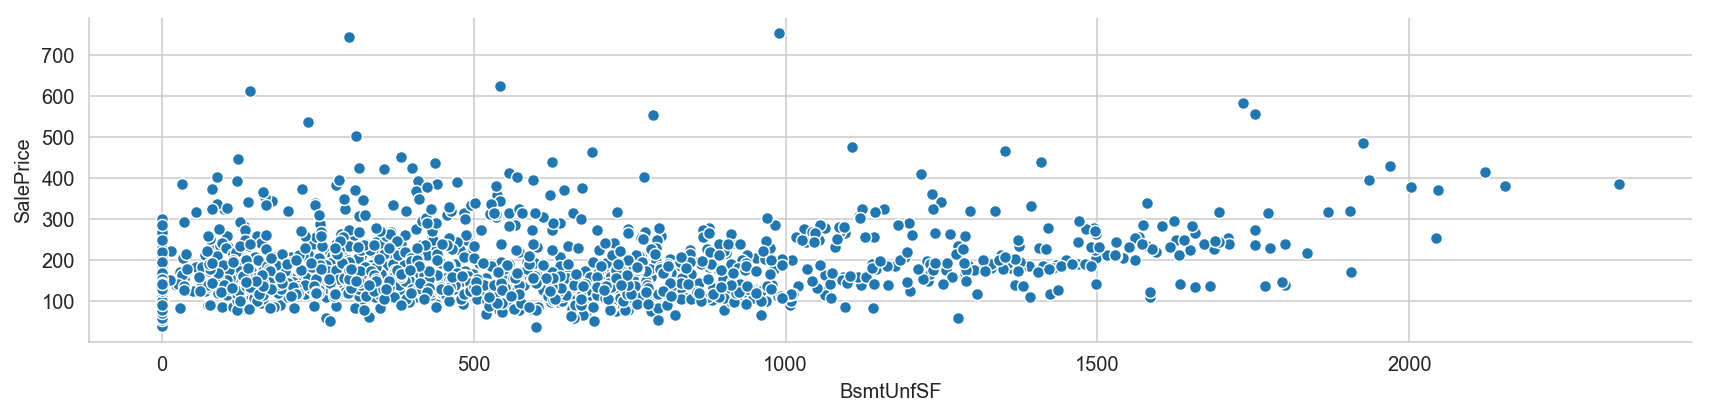

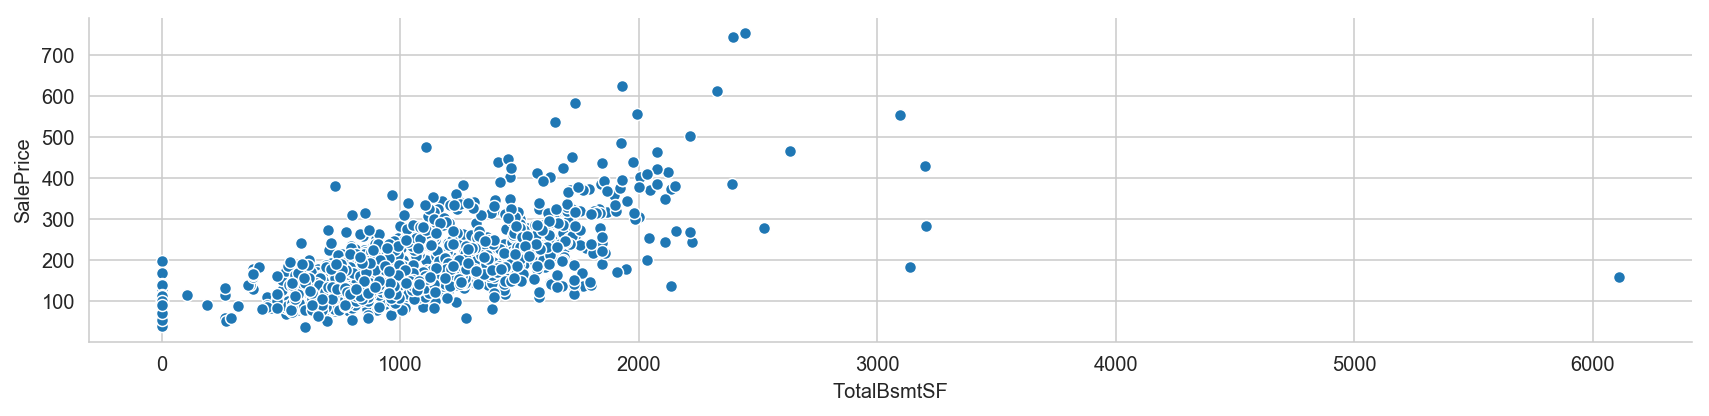

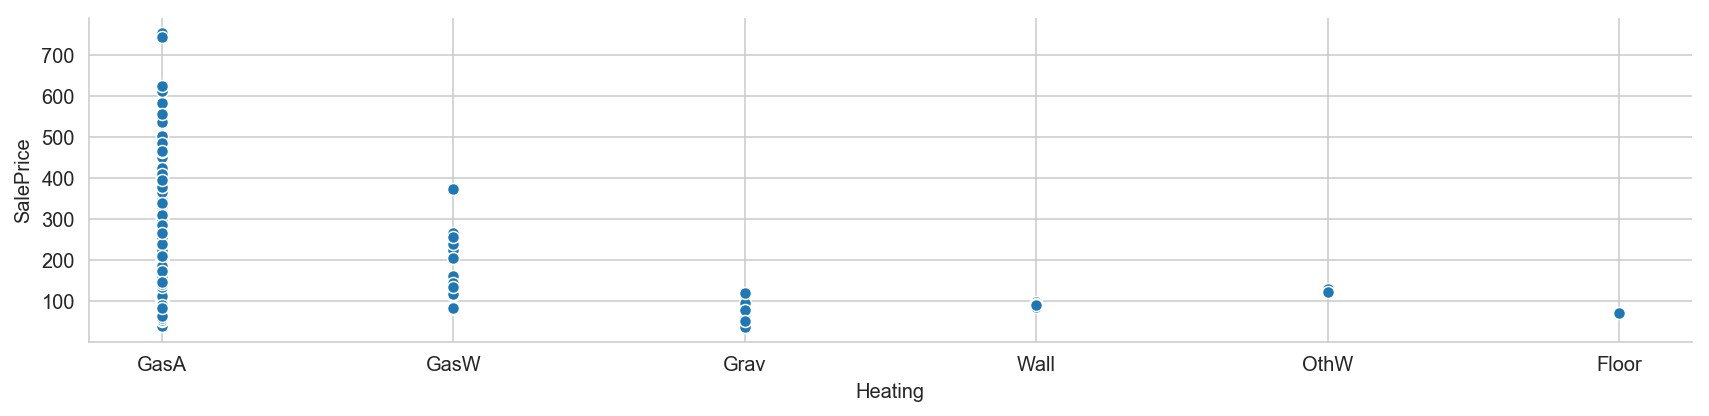

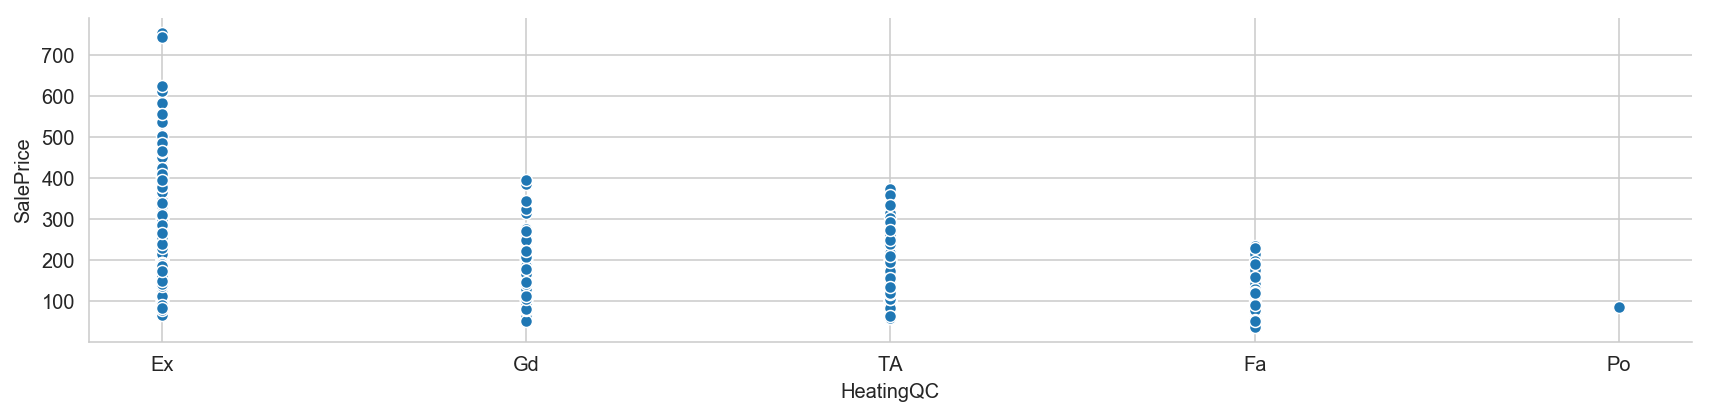

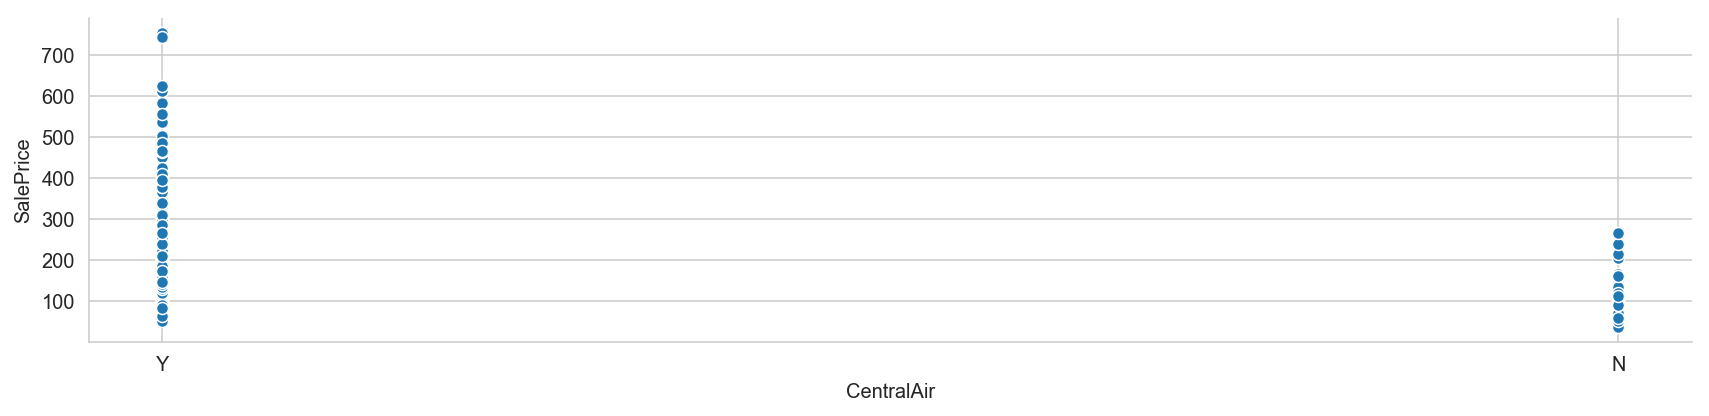

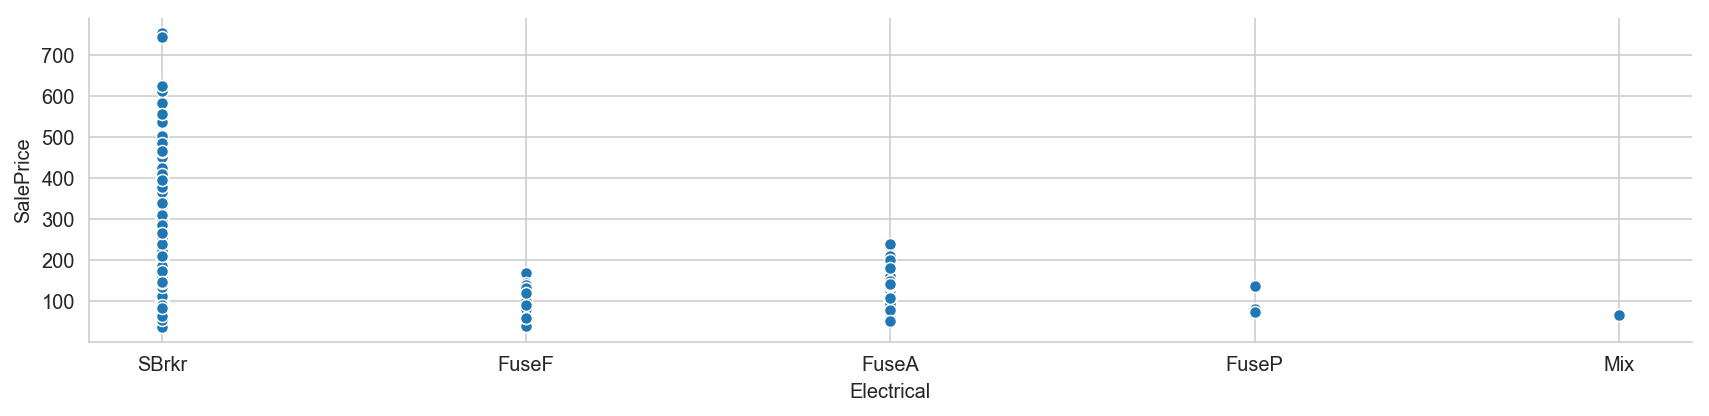

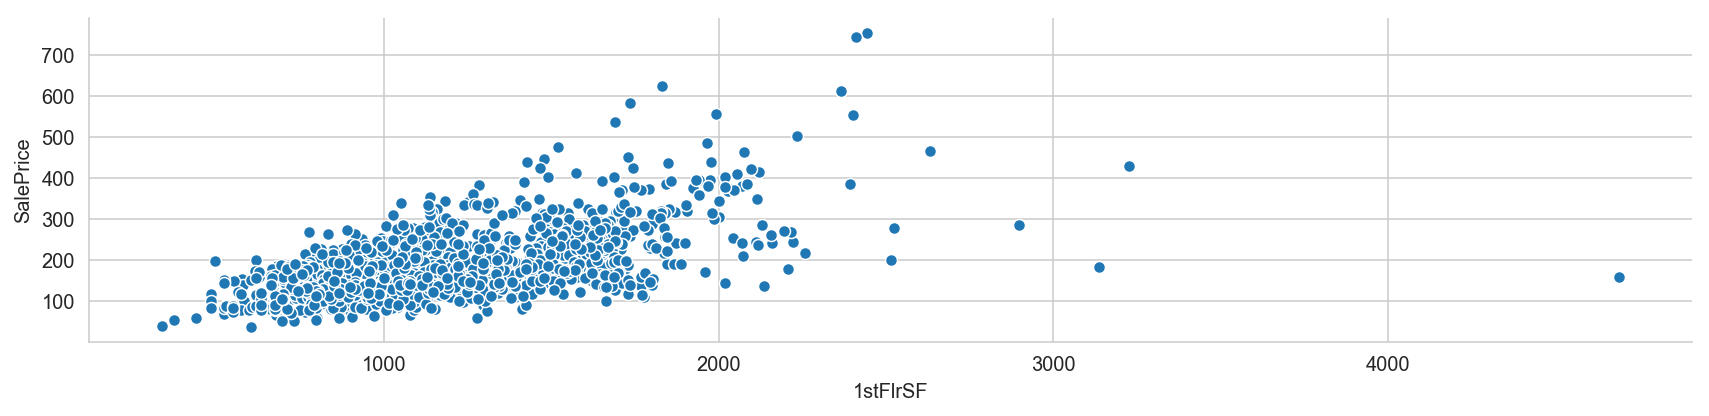

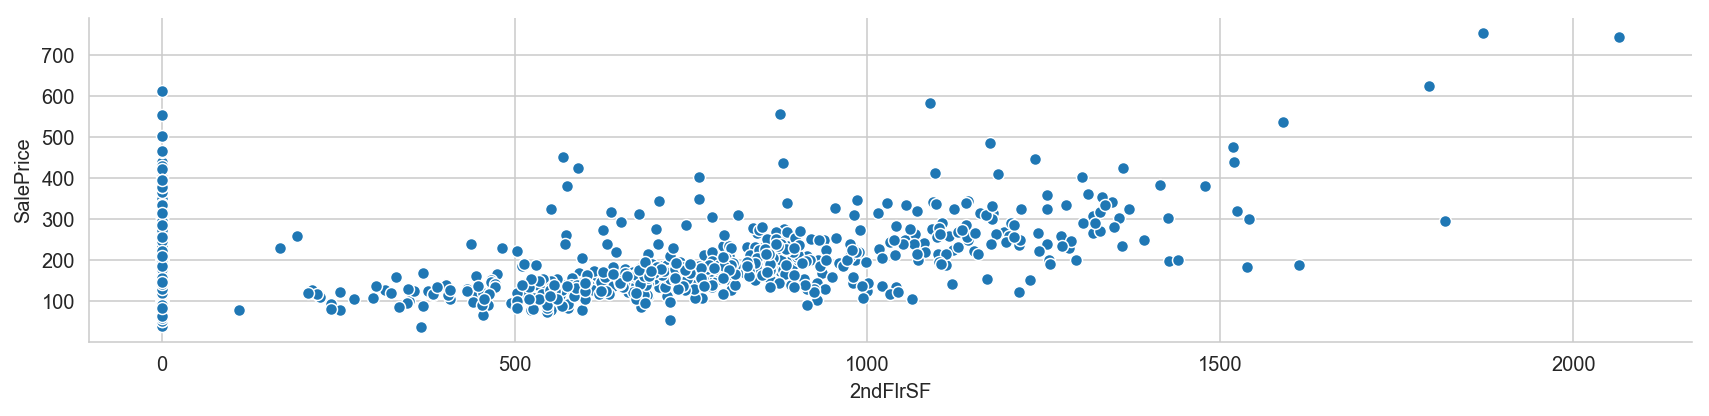

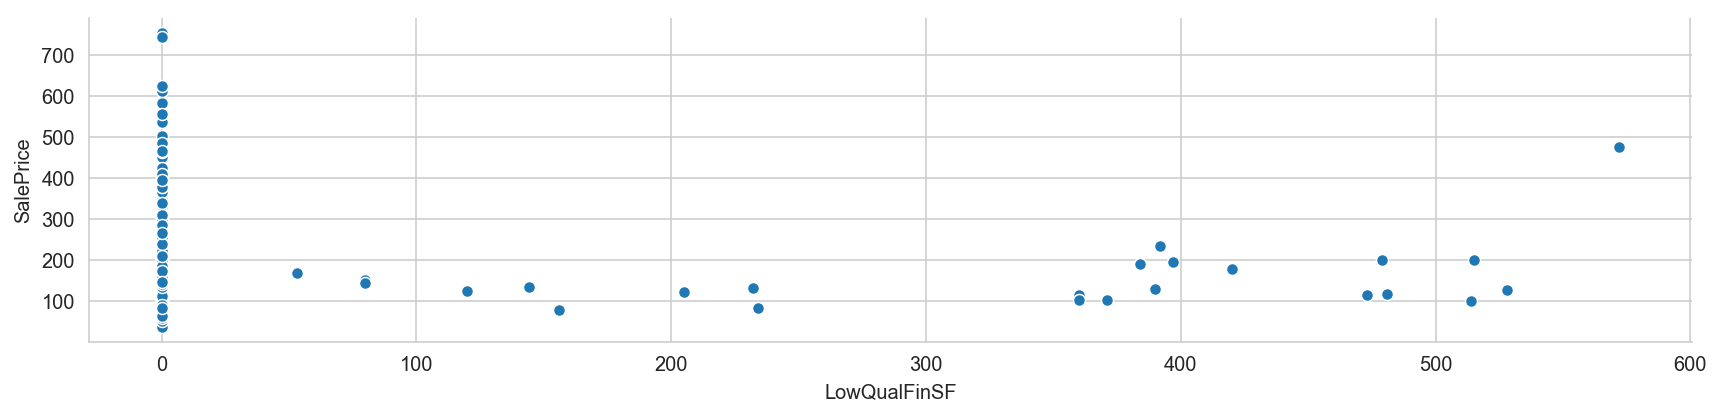

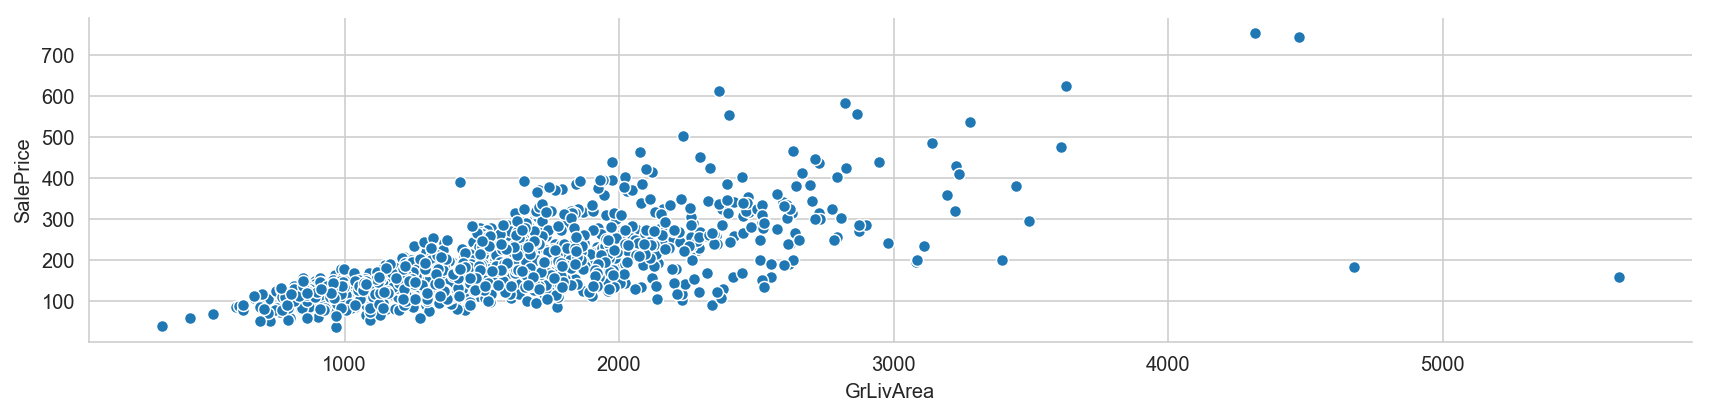

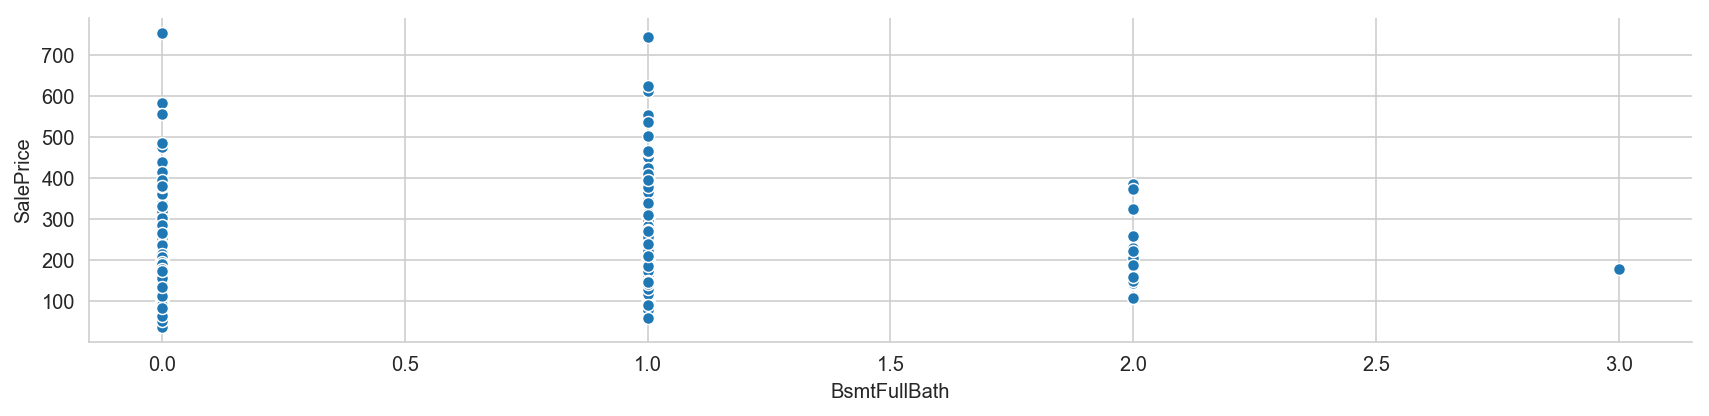

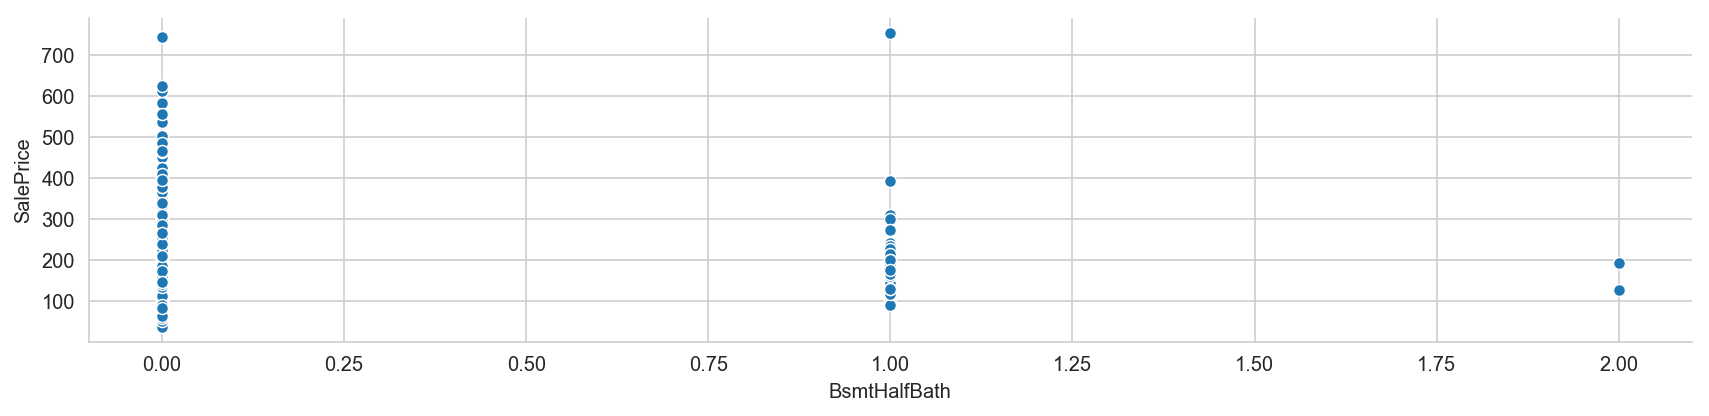

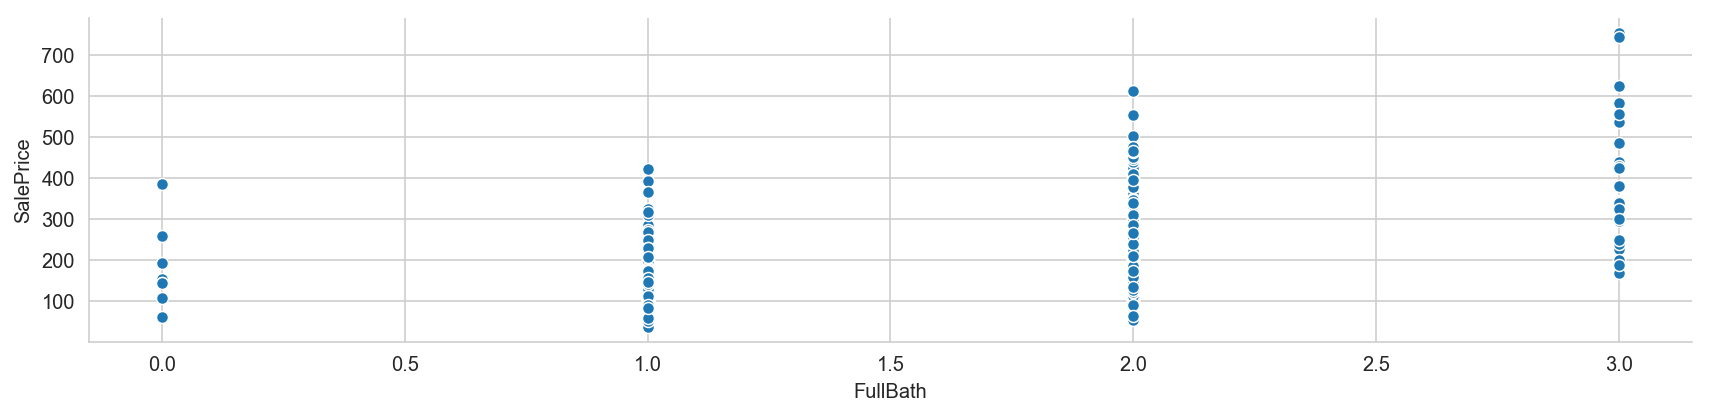

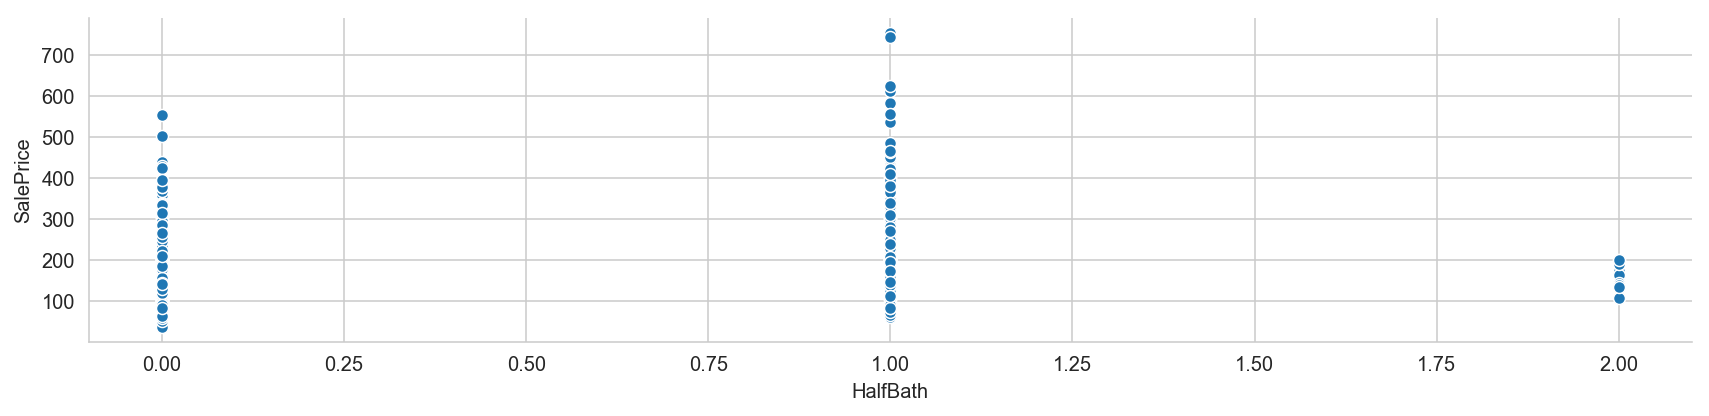

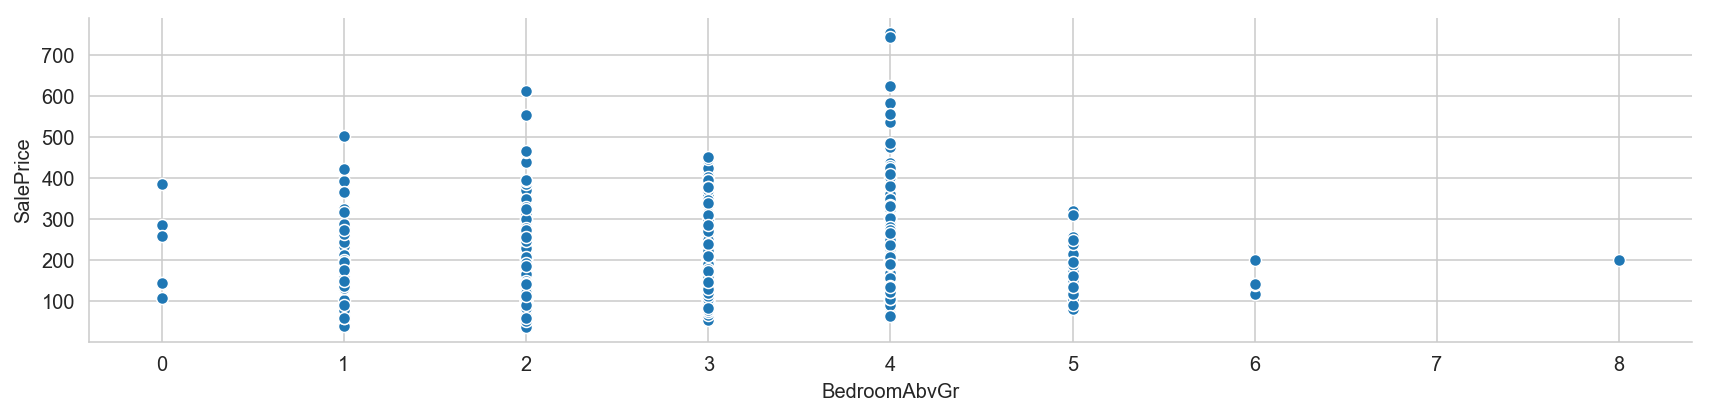

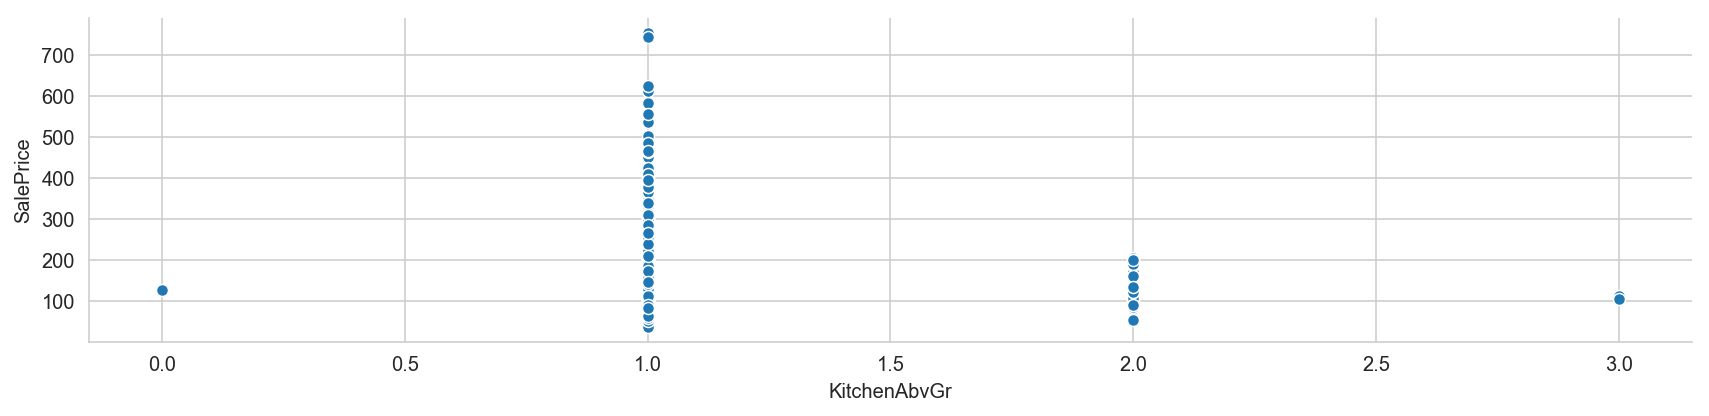

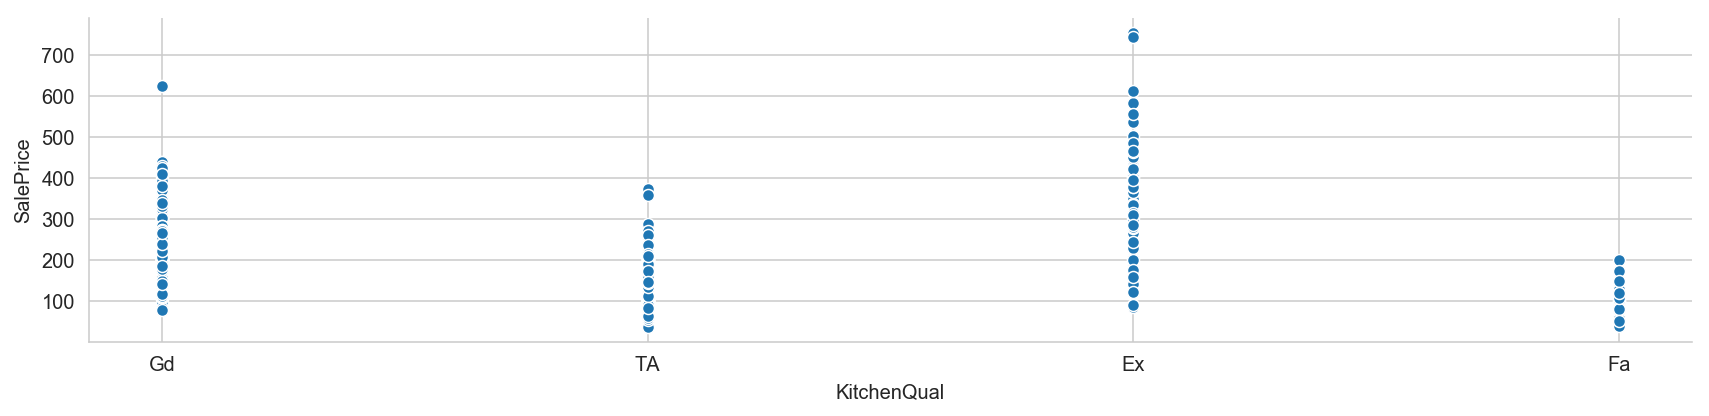

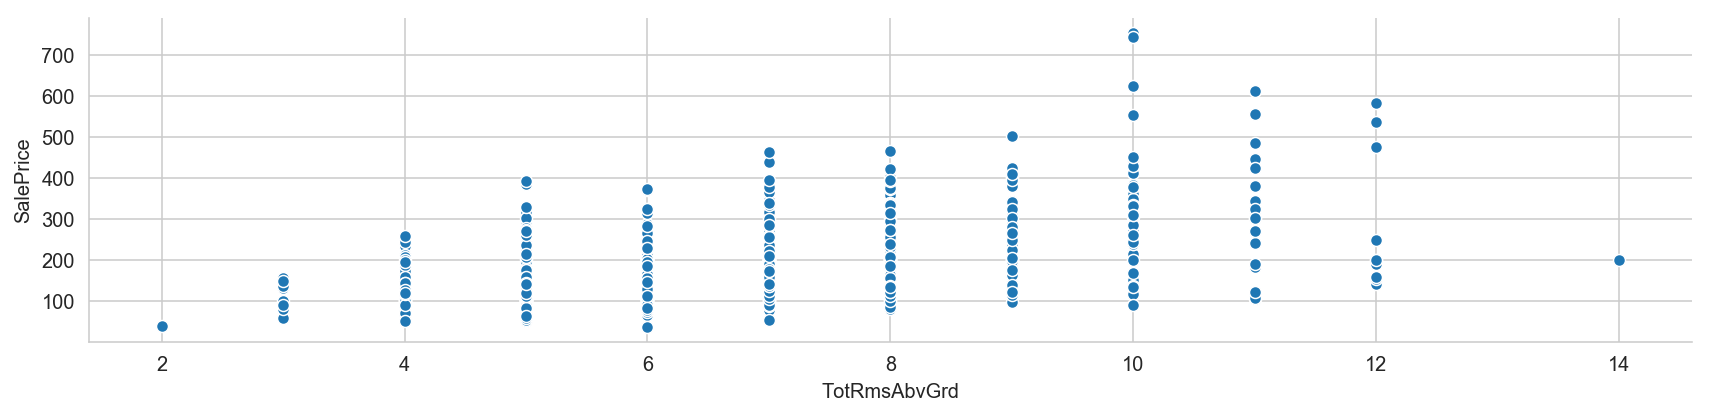

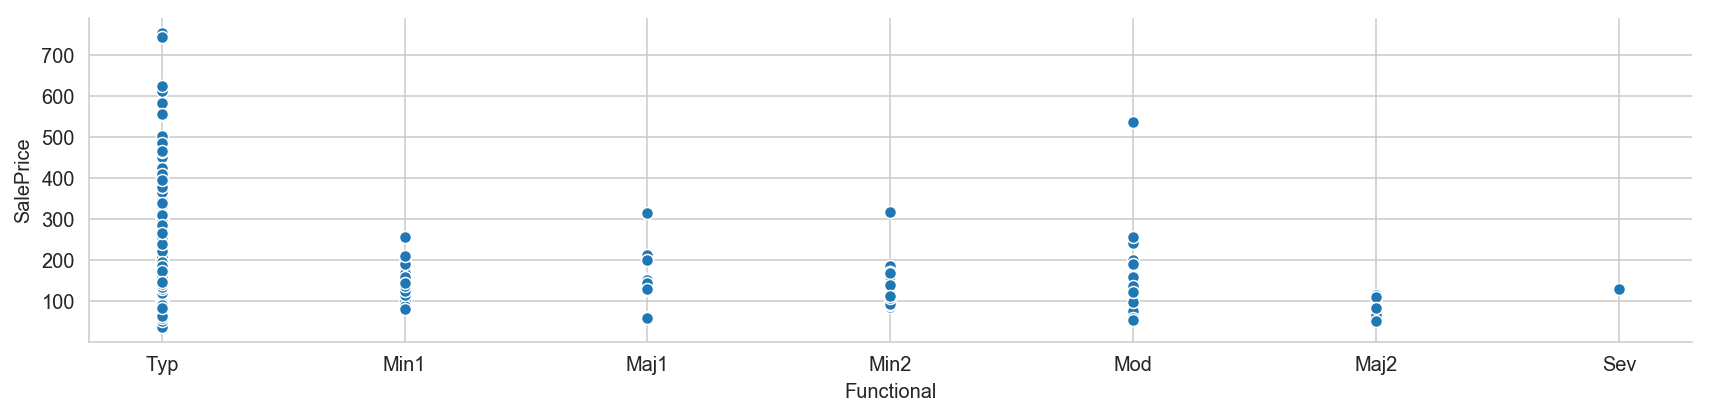

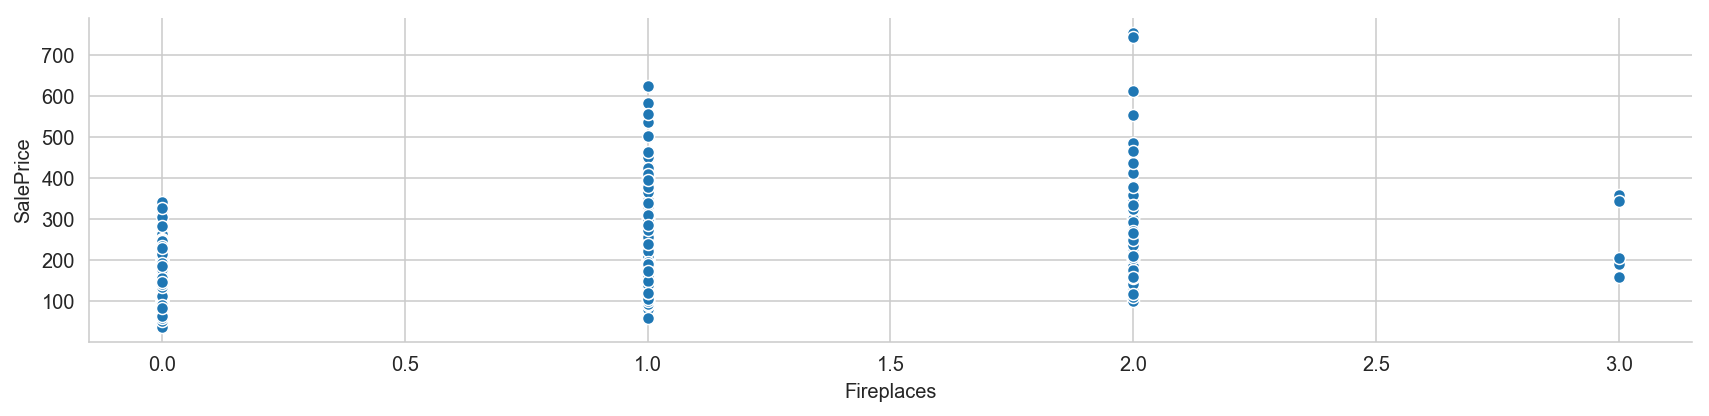

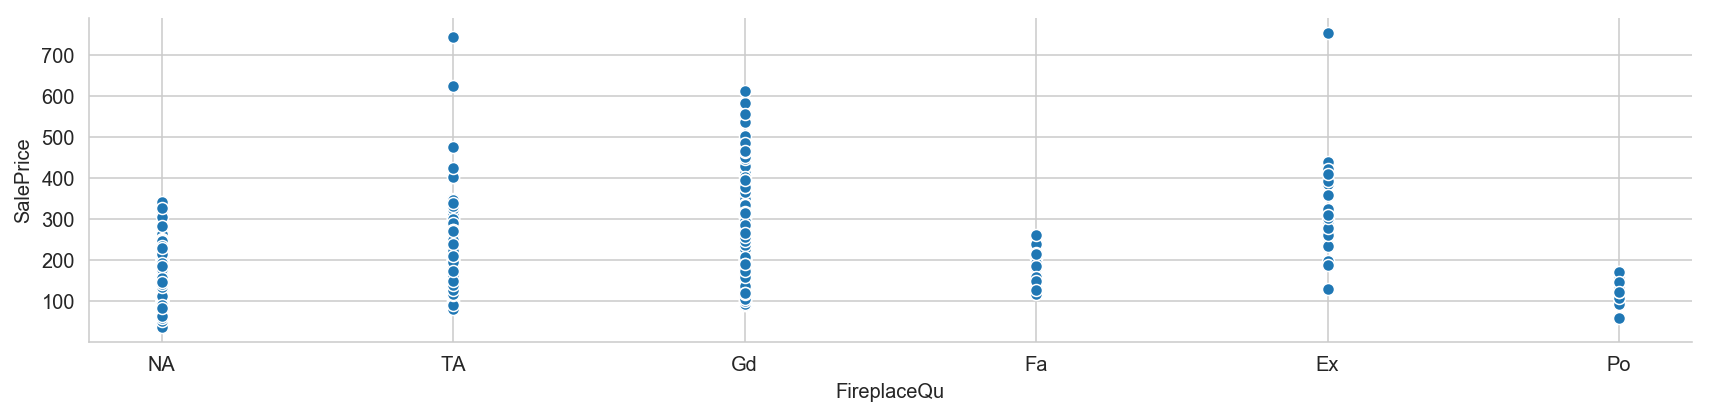

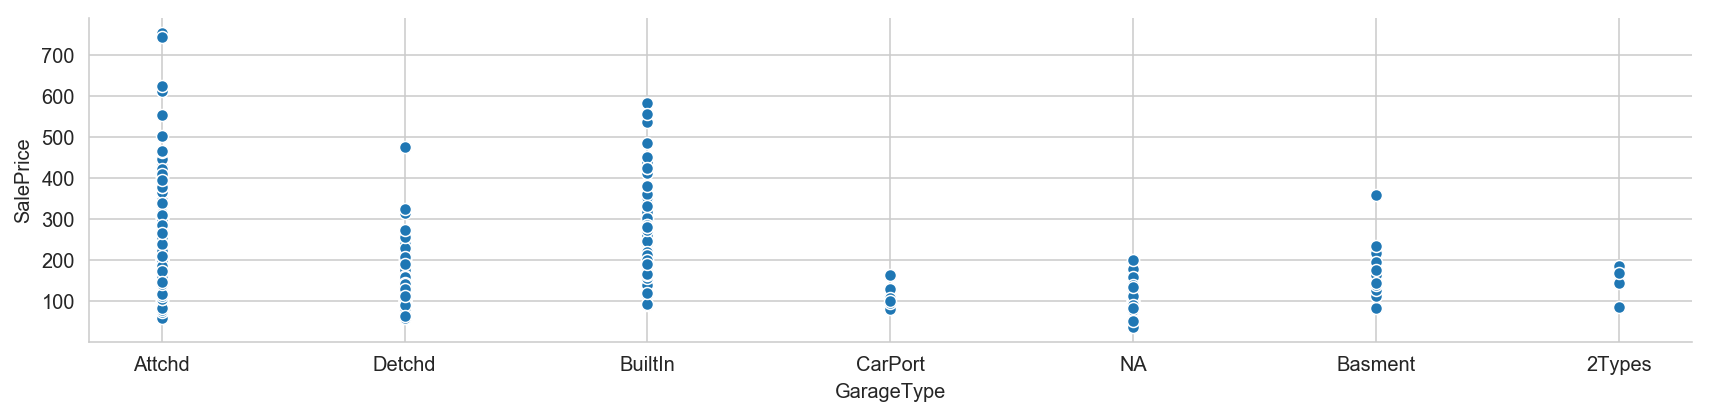

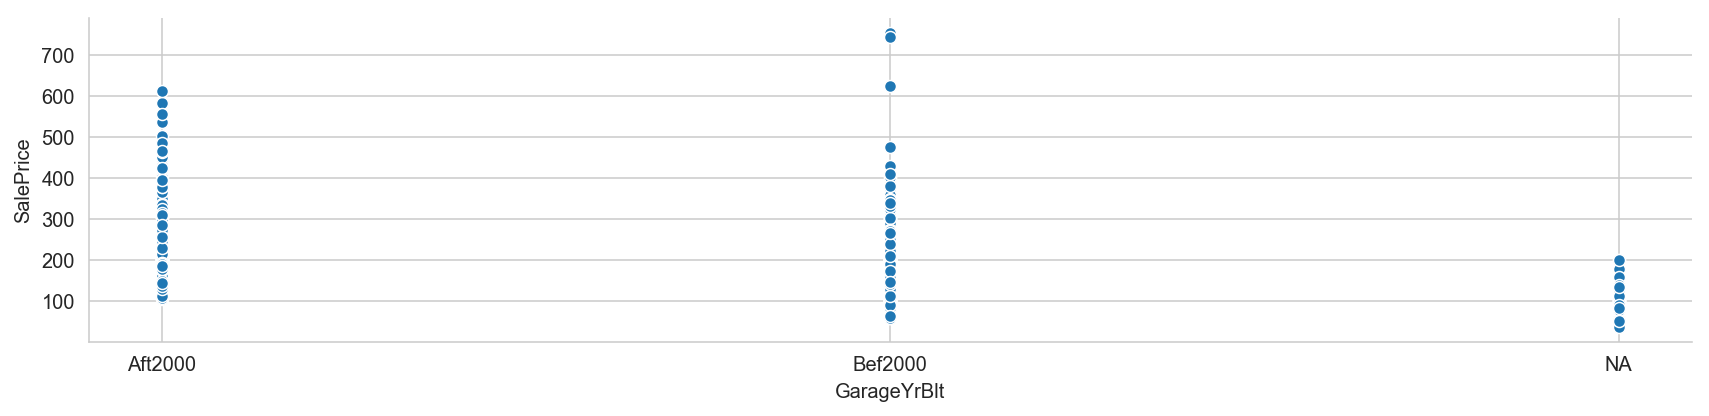

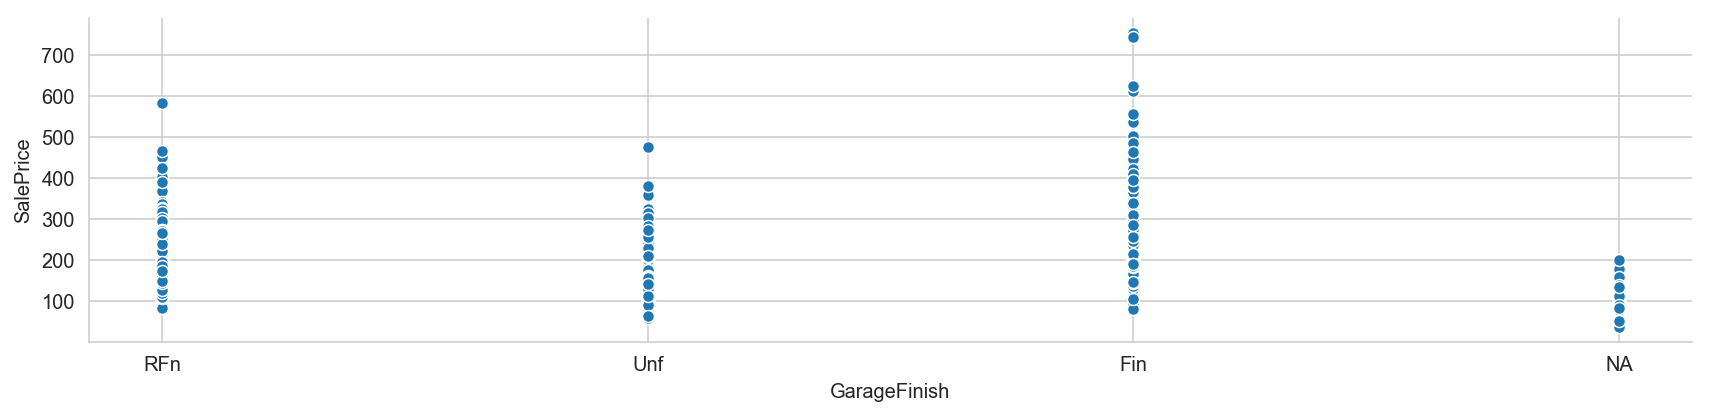

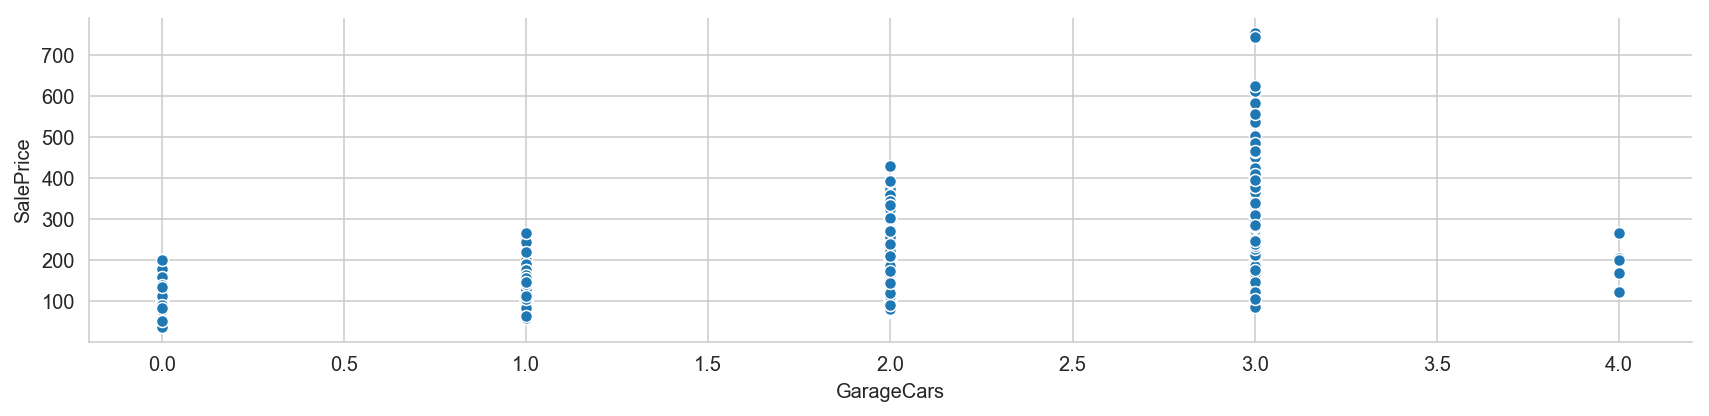

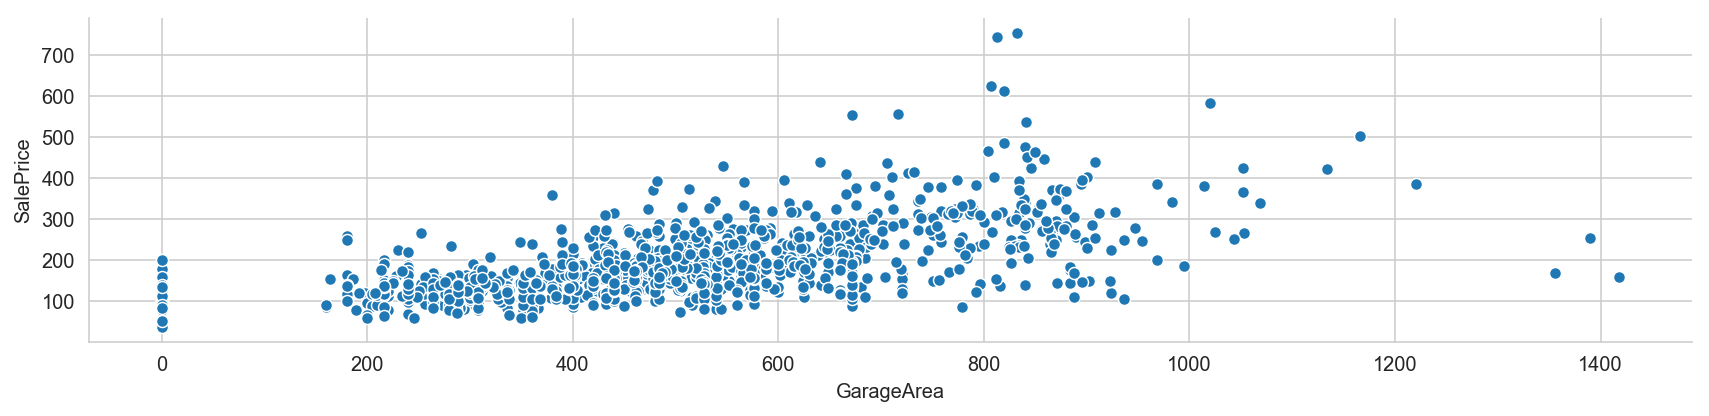

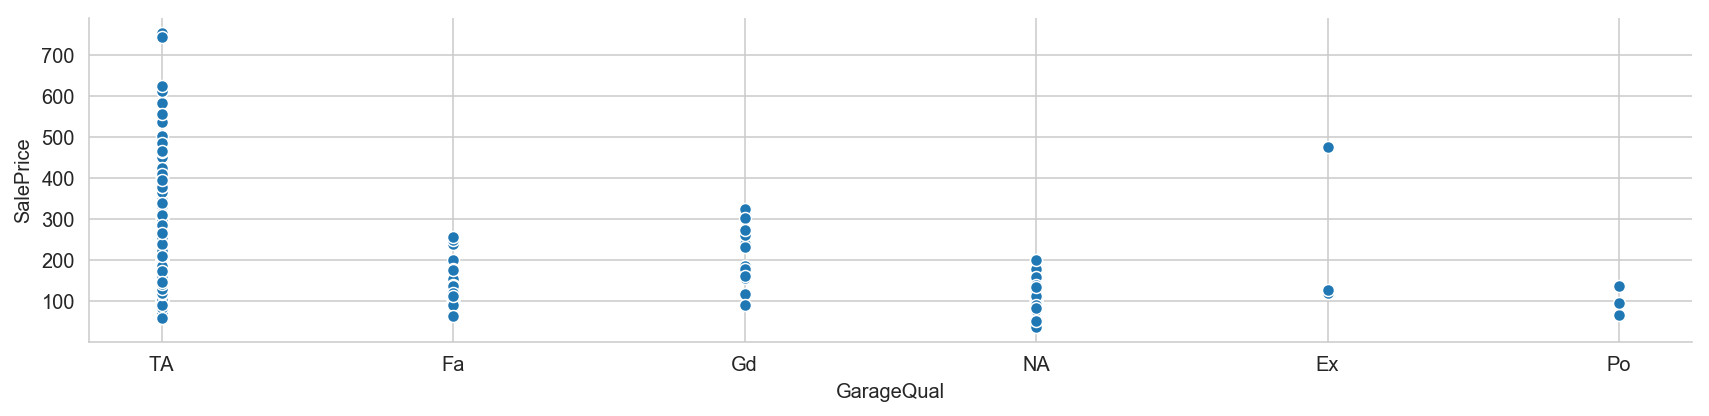

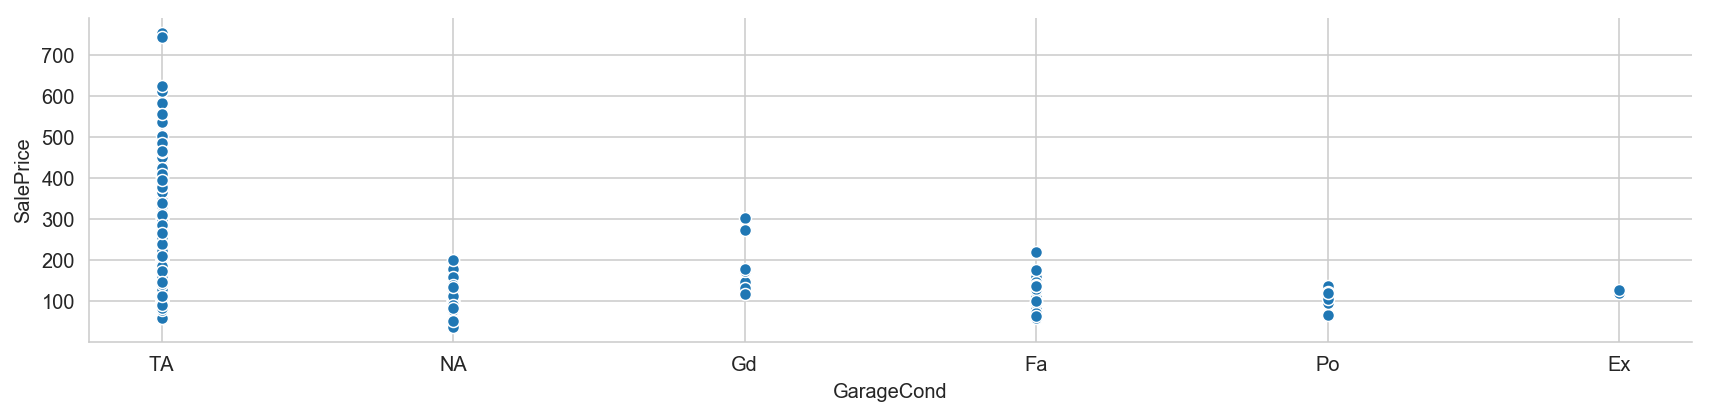

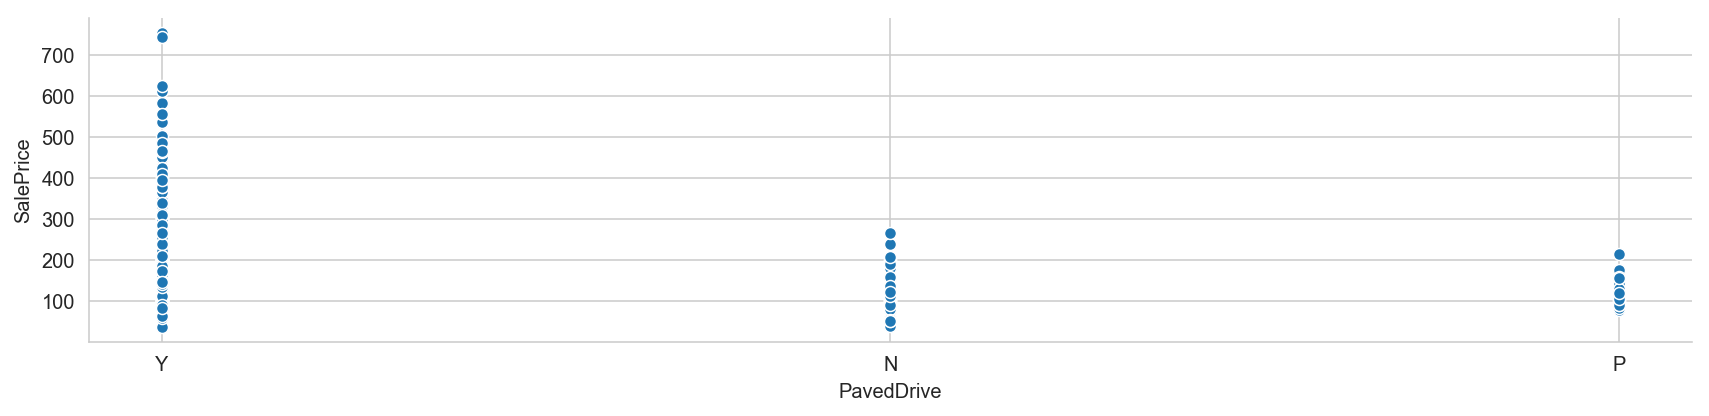

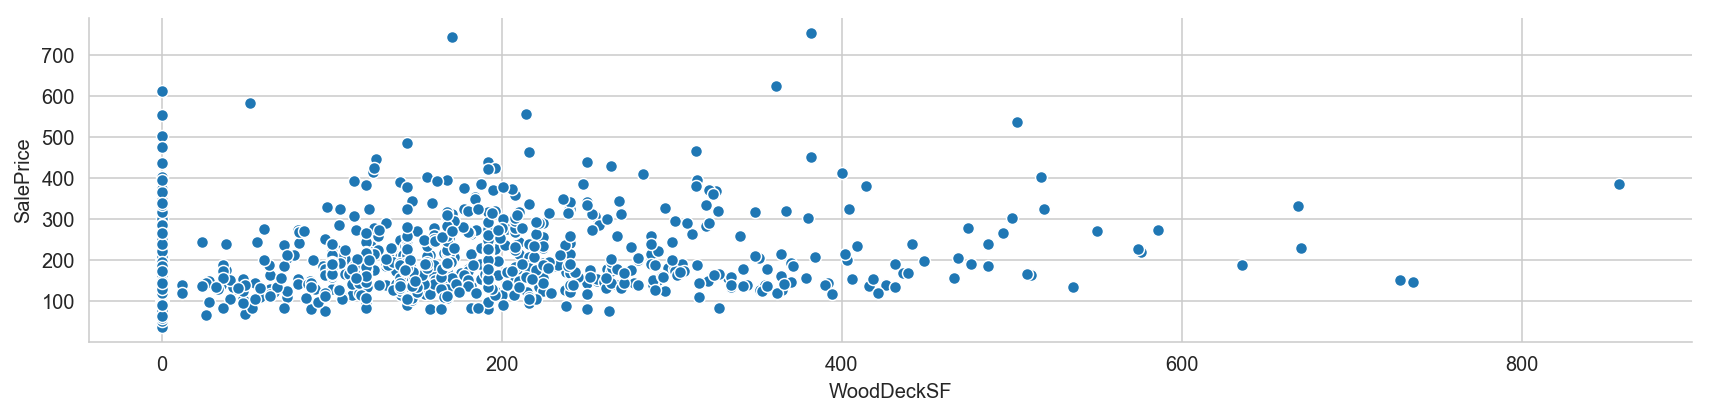

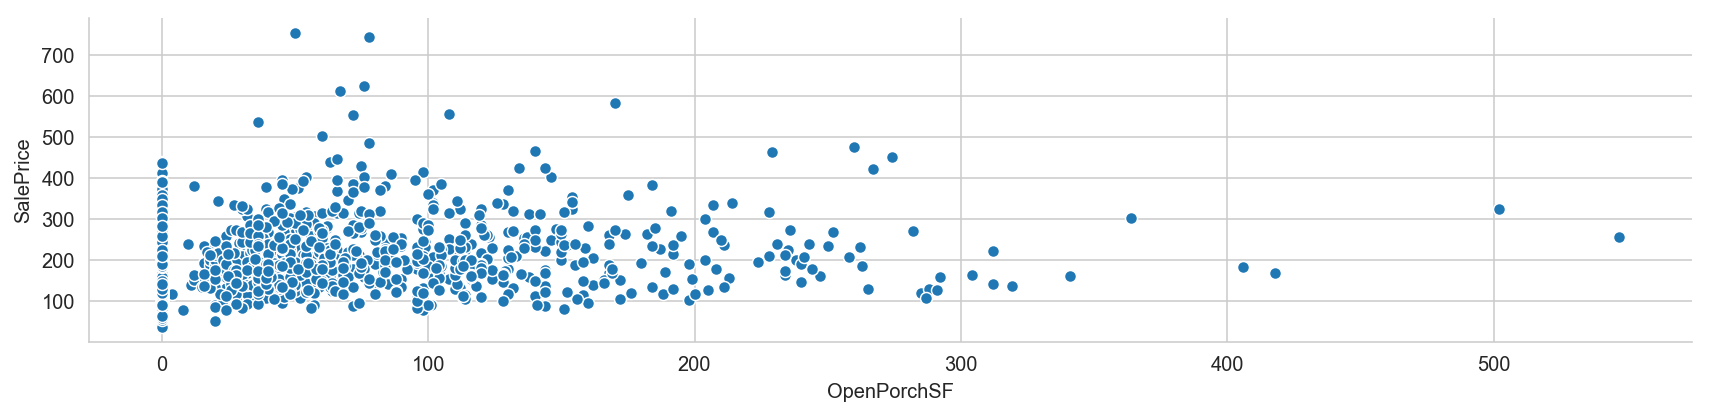

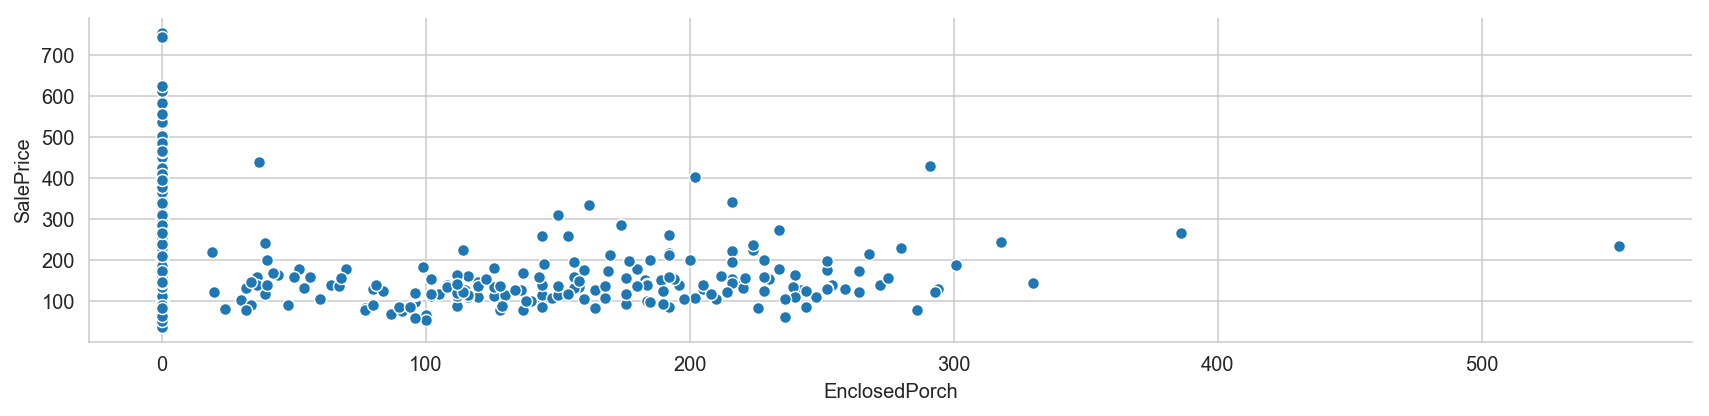

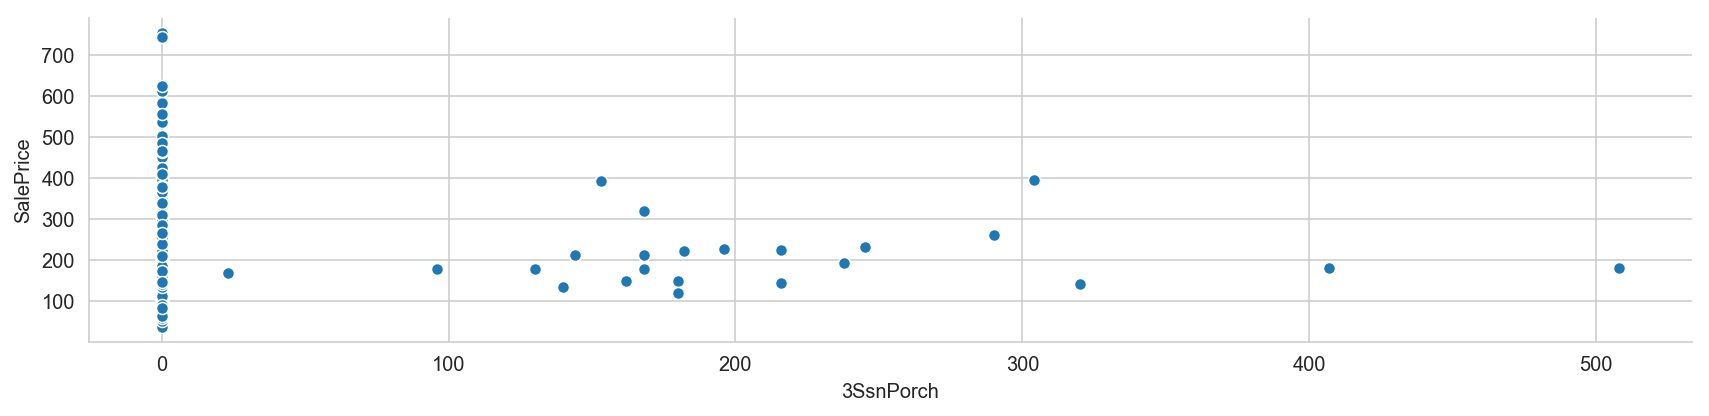

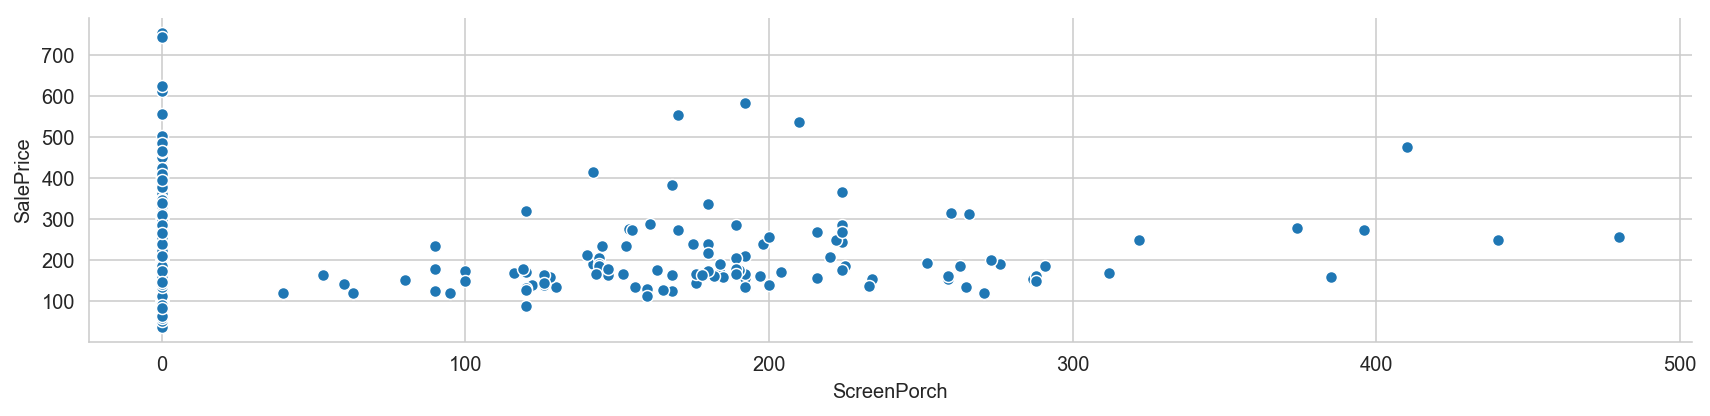

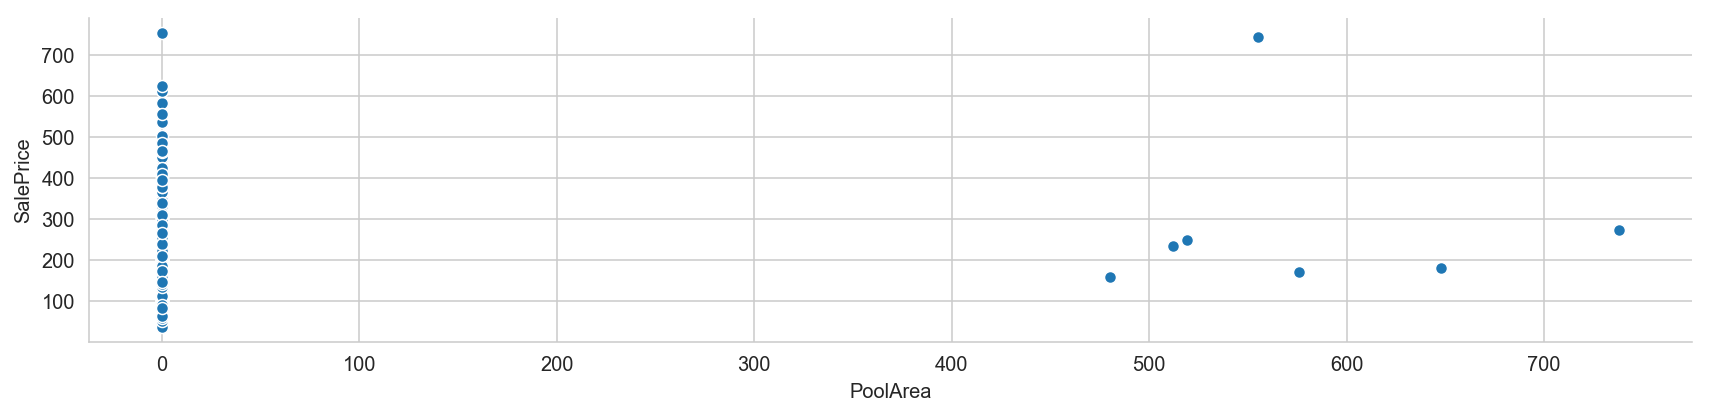

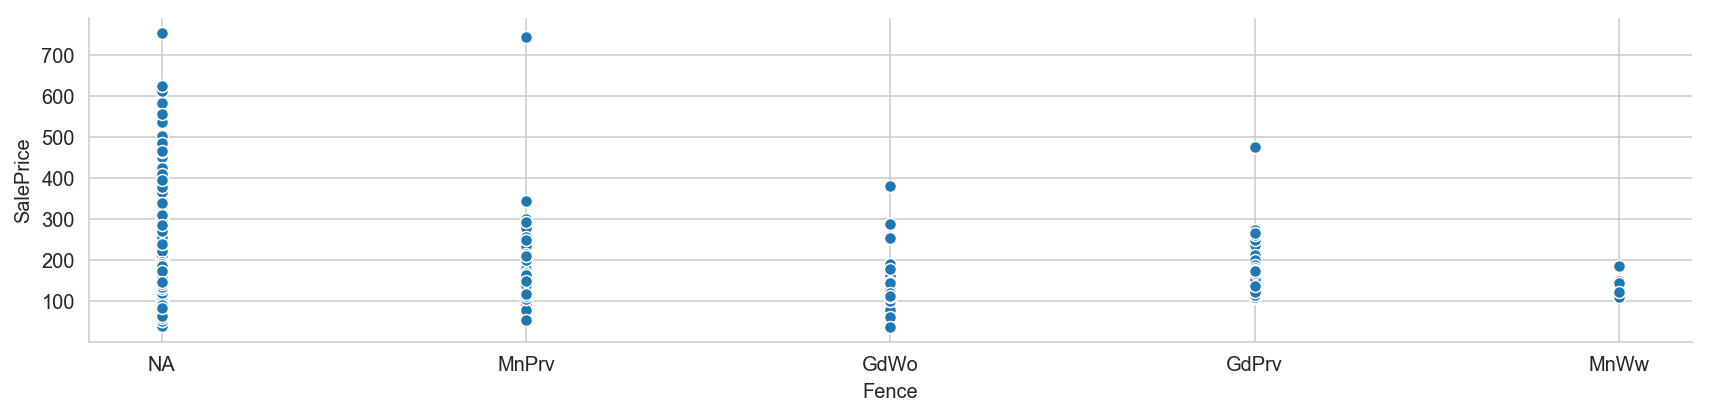

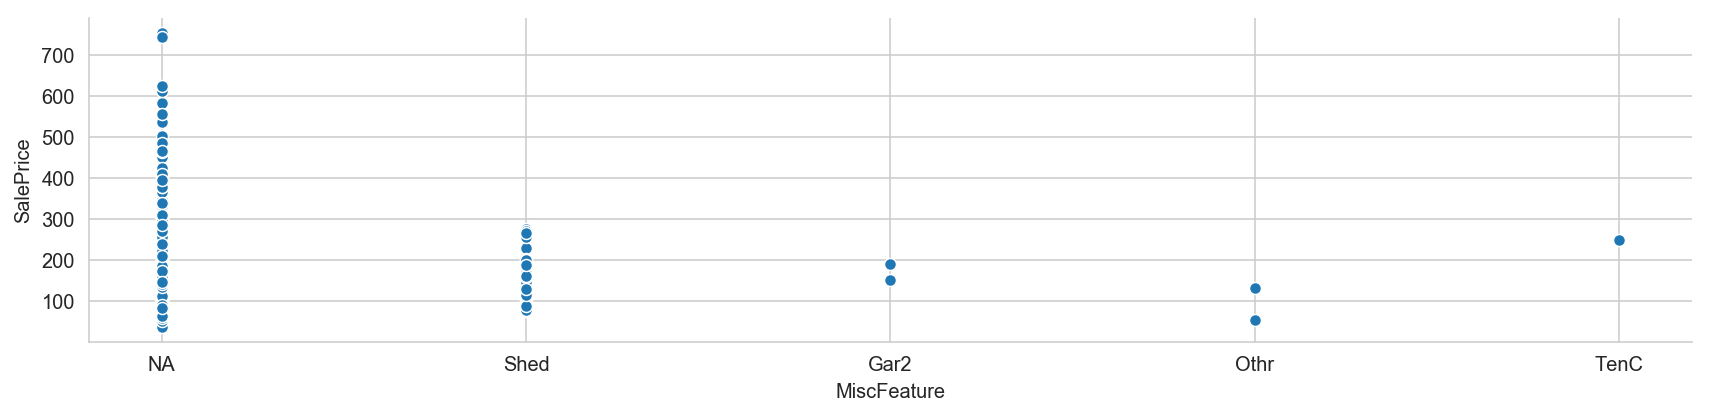

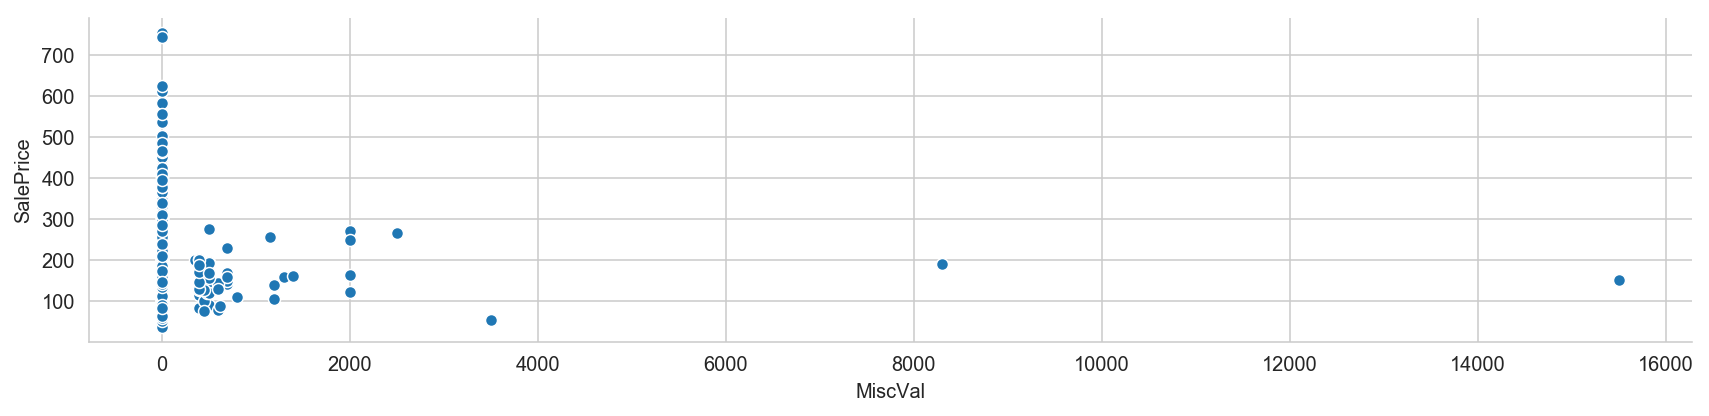

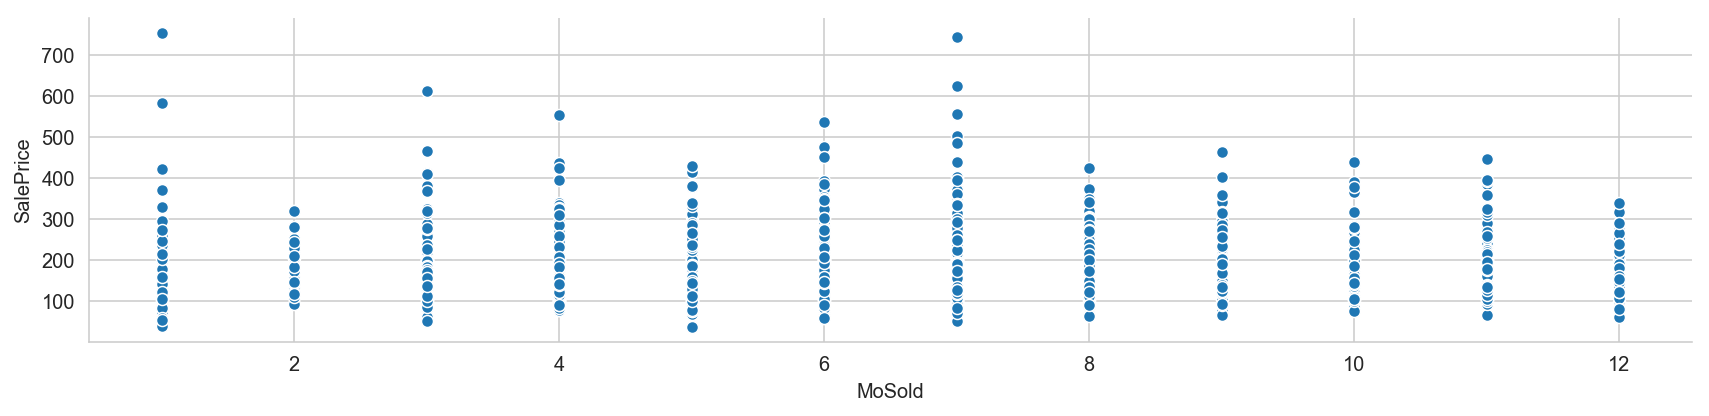

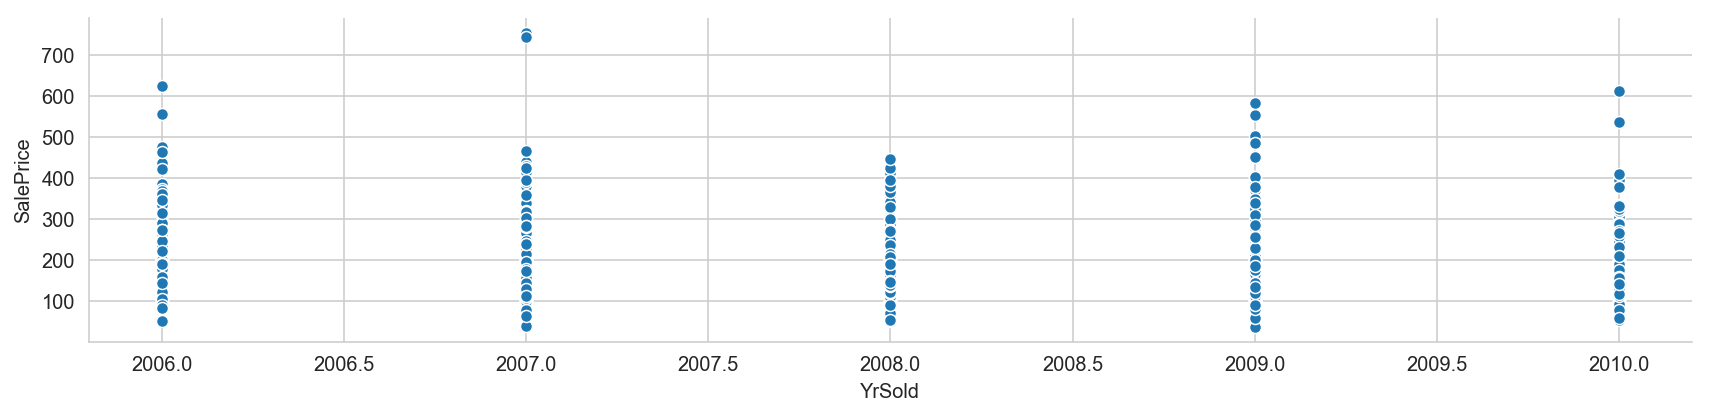

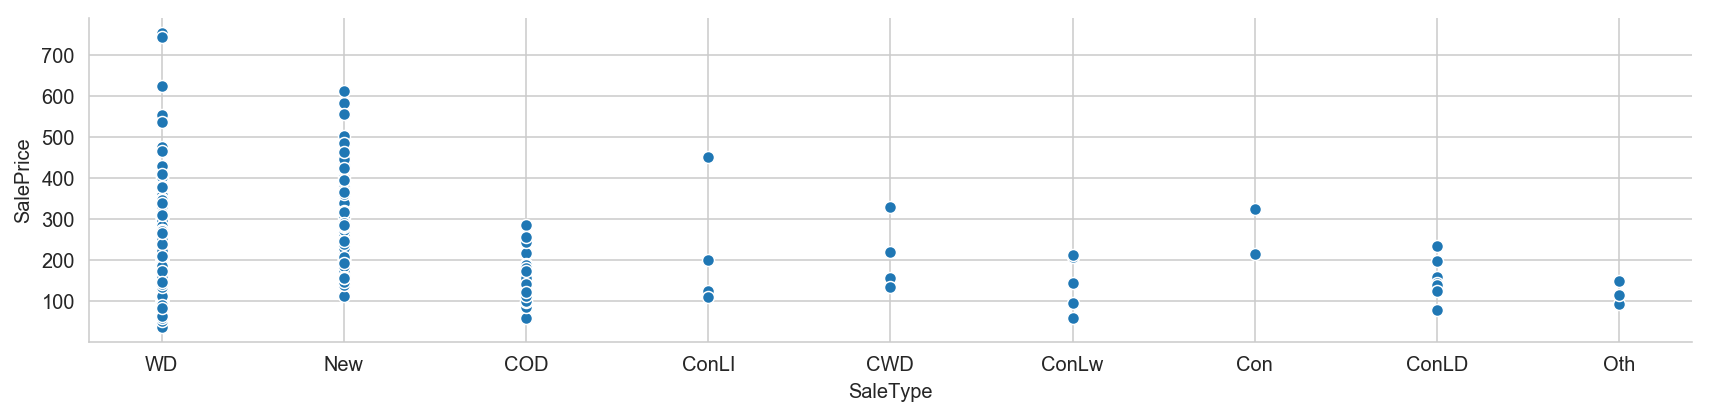

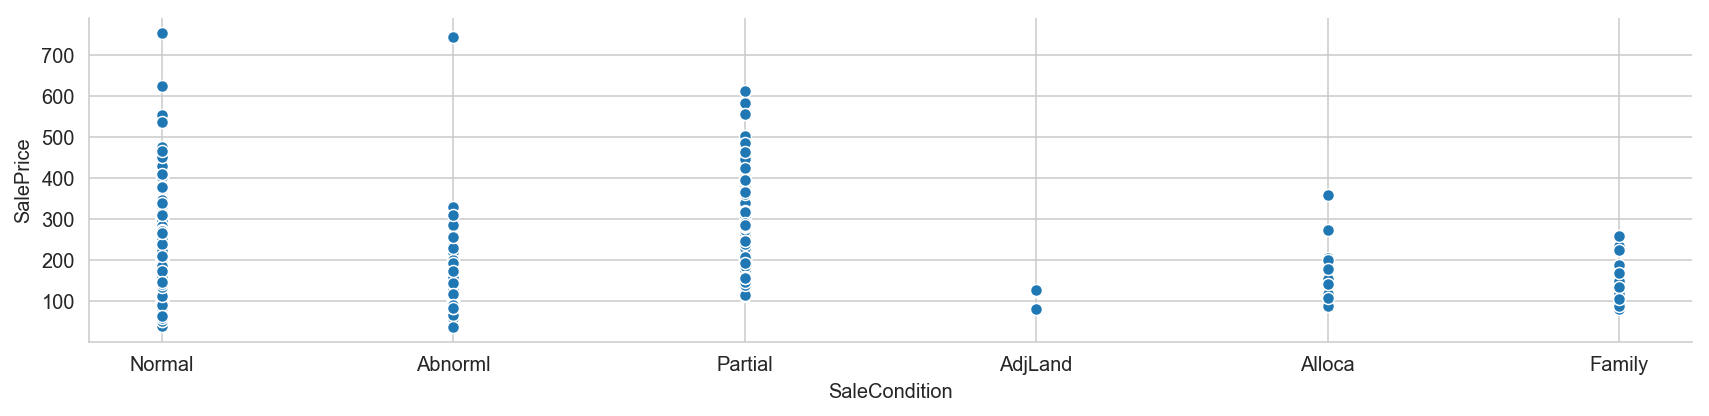

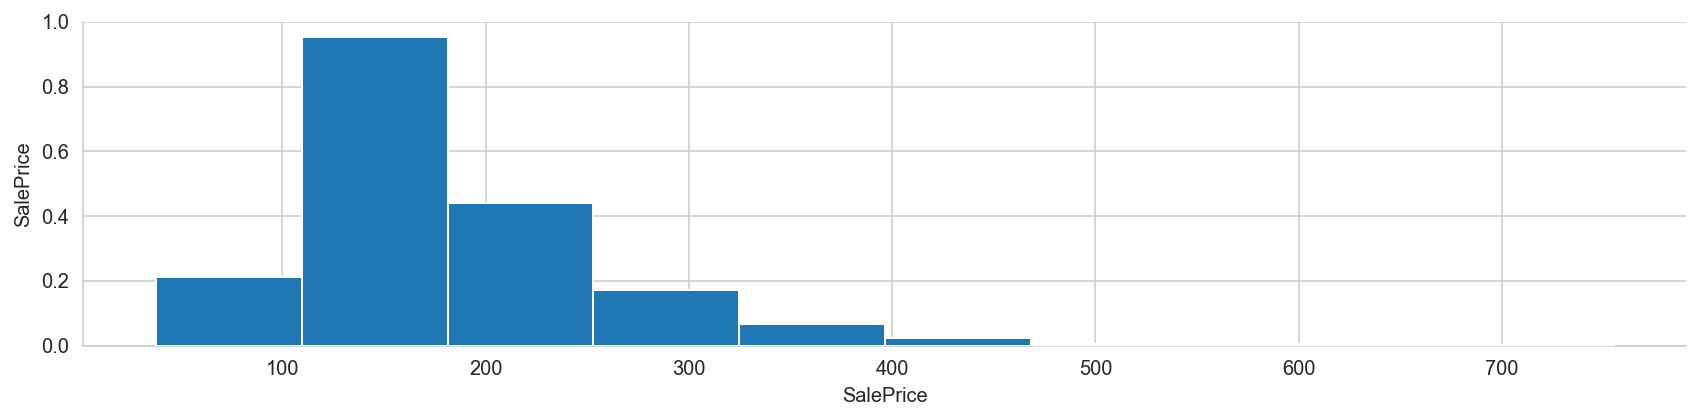

In [53]:
# Pairplot SalePrice with the rest of features for observations

[sns.pairplot(data = house, y_vars= 'SalePrice', x_vars=i, aspect= 4, height = 3) for i in house.columns]

plt.show()

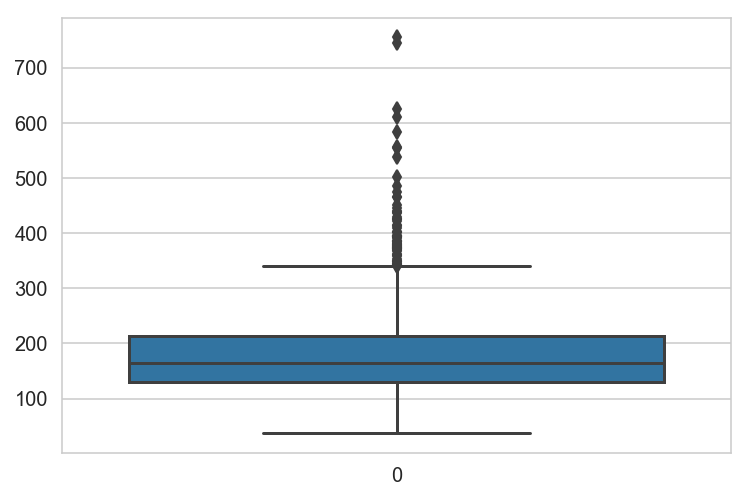

In [54]:
sns.boxplot(data = house['SalePrice'])

plt.show()

In [55]:
# Top 4 features correlated linearly with SalePrice

house.corr()['SalePrice'].abs().sort_values(ascending = False).head(5)

SalePrice      1.000000
OverallQual    0.789031
GrLivArea      0.708658
GarageCars     0.642135
GarageArea     0.629831
Name: SalePrice, dtype: float64

In [56]:
# Observations
# 1) Presence of outliers for SalePrice and some features like LotArea, MasVnrArea, etc. Due to the relatively huge 
# number of data (~1450), assessed that outliers will not have very big impact.
# 2) Quite a few features are linearly correlated with SalePrice, hence to consider Linear Regression models.

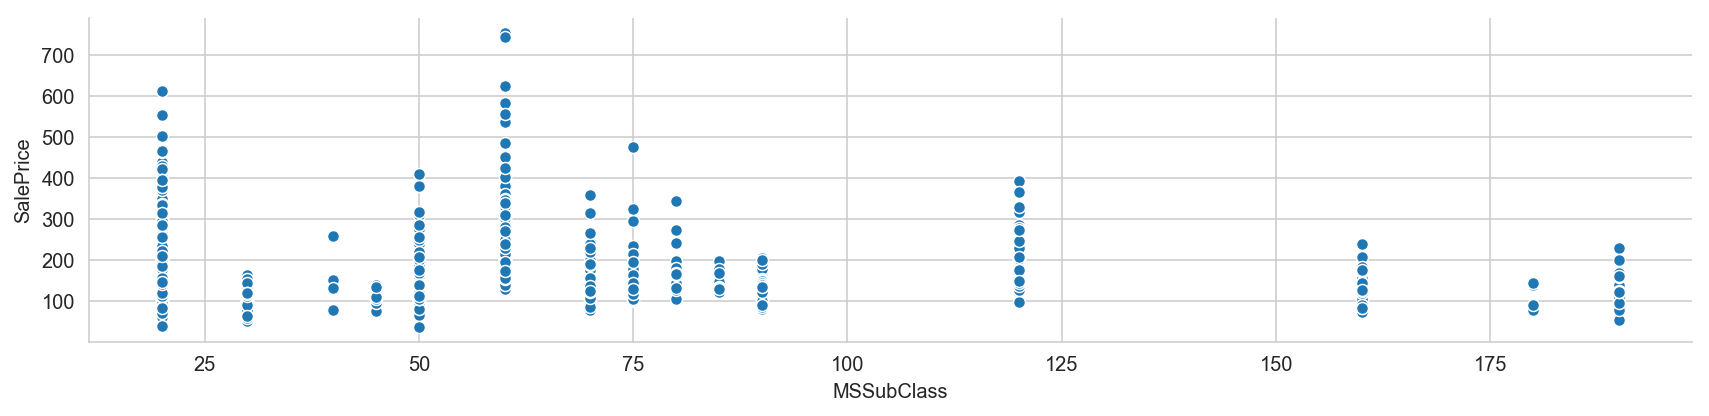

In [57]:
# MSSubClass shows no linear trend with prices, and there is no order in the MSSubClass, to be converted as categorical 
# feature instead of numerical

sns.pairplot(data = house, y_vars= 'SalePrice', x_vars= 'MSSubClass', aspect= 4, height = 3)

plt.show()

In [58]:
# Convert MSSubClass feature to categorical by replacing the number groups as string

house['MSSubClass'] = house['MSSubClass'].astype(str)

In [59]:
# Features to be dropped
# 1) Id will not be useful for predictinng prices, to be dropped
# 2) Utilities has 1449 values of AllPub and 1 values NoSeWa , to be dropped as variance too insignificant for price
# prediction.
# 3) Likewise Street only has 4 Grvl and 1446 Pave, variance too little to be reliable for predicting prices, 
# to be dropped.

house.drop(columns= ['Id', 'Utilities', 'Street'], inplace = True)

In [60]:
# Majority of Condition1 and Condtion2 data are Norm

print(house['Condition1'].value_counts())
print('\n')
print(house['Condition2'].value_counts())

Norm      1252
Feedr       79
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64


Norm      1436
Feedr        5
PosN         2
Artery       2
RRNn         2
PosA         1
RRAn         1
RRAe         1
Name: Condition2, dtype: int64


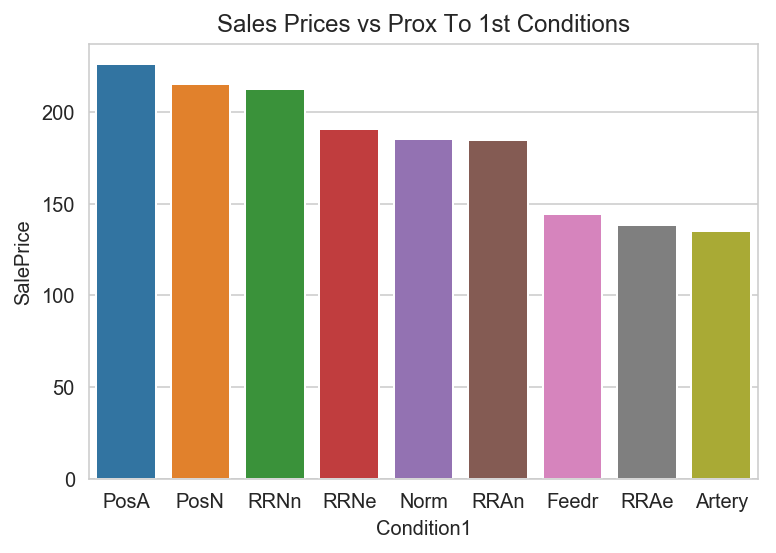

In [61]:
# Observed that mean prices are higher when houses are within 200' of Railroads instead of being adjacent (too close) 
# to it.
# Houses with Norm conditions have mean prices higher than houses adjacent to arterial or feeder streets. 
# (something not intuitive)

cond1_prices = pd.DataFrame(house.groupby('Condition1').mean()['SalePrice']).reset_index().sort_values \
('SalePrice', ascending= False)

sns.barplot(x = cond1_prices['Condition1'], y = cond1_prices['SalePrice'])
plt.title('Sales Prices vs Prox To 1st Conditions')
plt.show()

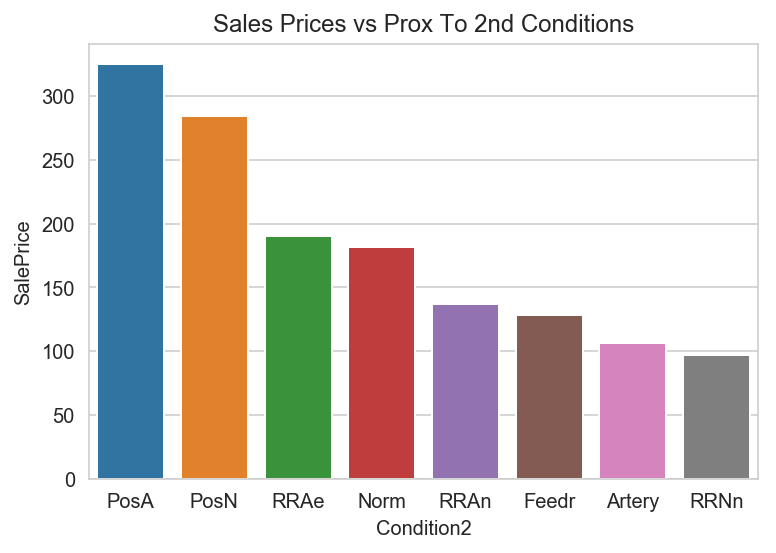

In [62]:
# The order becomes different for Condition2.

cond1_prices = pd.DataFrame(house.groupby('Condition2').mean()['SalePrice']).reset_index().sort_values \
('SalePrice', ascending= False)

sns.barplot(x = cond1_prices['Condition2'], y = cond1_prices['SalePrice'])
plt.title('Sales Prices vs Prox To 2nd Conditions')
plt.show()

In [63]:
# this looks ok, to check all entries with Condition1 == Norm will also have Condition2 == Norm

house[house['Condition1'] == 'Norm']['Condition2'].value_counts()

Norm    1252
Name: Condition2, dtype: int64

In [64]:
# this looks ok, almost half of the entries have remodelled their houses after YearBuilt

print(len(house[house['YearBuilt'] == house['YearRemodAdd']]))
print(len(house[house['YearBuilt'] < house['YearRemodAdd']]))

763
687


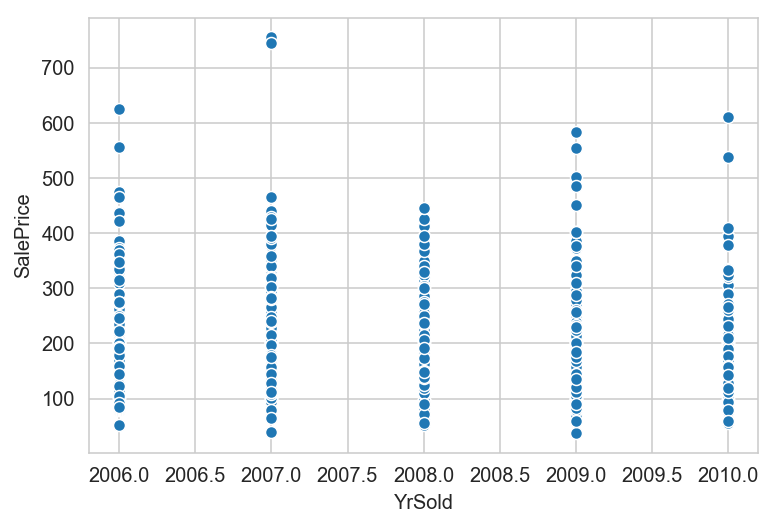

In [65]:
# To check for anomalies in house prices (e.g. during financial crisis or war)
# This looks ok, prices are quite consistent across each year

sns.scatterplot(house['YrSold'], house['SalePrice'])
plt.show()

# Feature Engneering

**Convert Year Built to Age**

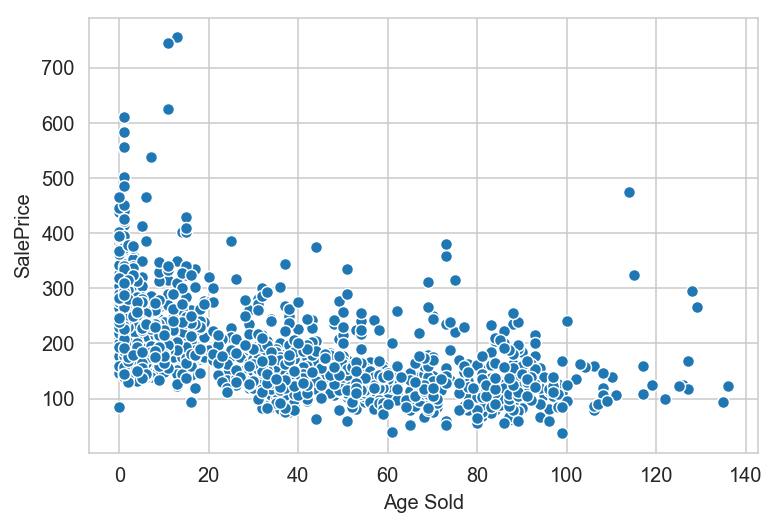

In [66]:
# New Feature: Age of house when it is sold
# Newer houses in general should fetch higher prices

house['Age_Sold'] = house['YrSold'] - house['YearBuilt']

sns.scatterplot(house['Age_Sold'], house['SalePrice'])
plt.xlabel('Age Sold')
plt.show()

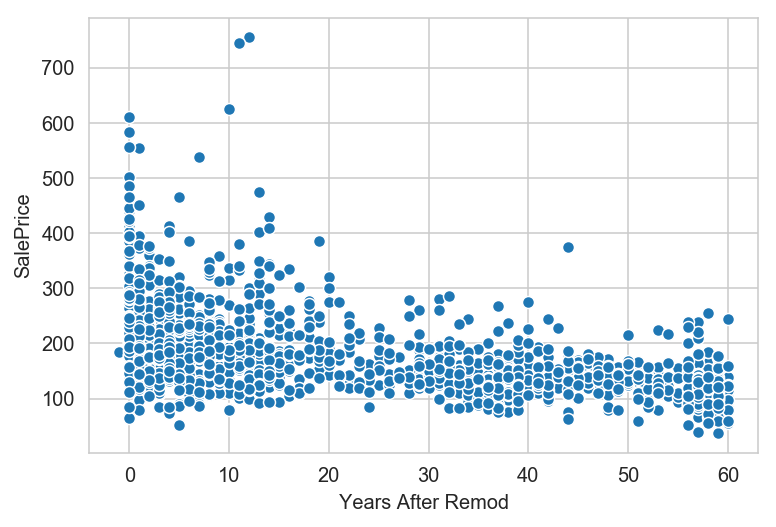

In [67]:
# New Feature: Age of house after Remodelled when it is sold
# Houses that just remodelled in general should fetch higher prices

house['Remod_Age_Sold'] = house['YrSold'] - house['YearRemodAdd']

sns.scatterplot(house['Remod_Age_Sold'], house['SalePrice'])
plt.xlabel('Years After Remod')
plt.show()

In [68]:
# No particular anomalies in house prices for certain year built or remodadd
# due to events of time (e.g. war, financial crisis)
# Hence, to drop these variables after creating the last 2 features

house.drop(columns= ['YearBuilt', 'YearRemodAdd'], inplace = True)

**Group Houses with Various Vicinities (i.e. 'Condition1', 'Condition2')**

In [69]:
# Feedr (Condition 1) + RRAn (Condition2) should be in the same category as RRAn (Condition2) + Feedr (Condition1).
# Likewise for other pairs.

house.groupby(['Condition1','Condition2']).size()

Condition1  Condition2
Artery      Artery           2
            Norm            45
            PosA             1
Feedr       Norm            75
            RRAe             1
            RRAn             1
            RRNn             2
Norm        Norm          1252
PosA        Norm             8
PosN        Norm            17
            PosN             2
RRAe        Norm            11
RRAn        Feedr            4
            Norm            22
RRNe        Norm             2
RRNn        Feedr            1
            Norm             4
dtype: int64

In [70]:
# To group Condition1 and Condition2 as pairs with Condition1 having smaller alphabet order than Condition2
# e.g. 'A' + 'B' -> 'AB'
# e.g. 'B' + 'A' -> 'AB'

temp = list(house['Condition1'] + ',' + house['Condition2'])
temp = [set(i.split(',')) for i in temp]

condition_1n2 = []
for pair in temp:
    combined = ''
    for element in pair:
        combined += element
    condition_1n2.append(combined)

house.drop(columns = ['Condition1', 'Condition2'], inplace = True)
house['condition_1n2'] = condition_1n2

In [71]:
# Condition_1n2 has 15 categories now

house['condition_1n2'].value_counts()

Norm          1252
FeedrNorm       75
NormArtery      45
NormRRAn        22
PosNNorm        17
NormRRAe        11
NormPosA         8
FeedrRRAn        5
RRNnNorm         4
PosN             2
Artery           2
FeedrRRNn        2
NormRRNe         2
RRNnFeedr        1
FeedrRRAe        1
ArteryPosA       1
Name: condition_1n2, dtype: int64

**Size of Basement and Living Area**

In [72]:
# Check data that TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF

house[house['BsmtFinSF1'] + house['BsmtFinSF2'] + house['BsmtUnfSF'] != house['TotalBsmtSF']] # this should return nth

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, BldgType, HouseStyle, OverallQual, OverallCond, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Age_Sold, Remod_Age_Sold, condition_1n2]
Index: []

In [73]:
# Check data that GrLivArea = 1stFlrSF + 2ndFlrSF + LowQualFinSF

house[house['1stFlrSF'] + house['2ndFlrSF'] + house['LowQualFinSF'] != house['GrLivArea']] # this should return nth

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Alley, LotShape, LandContour, LotConfig, LandSlope, Neighborhood, BldgType, HouseStyle, OverallQual, OverallCond, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice, Age_Sold, Remod_Age_Sold, condition_1n2]
Index: []

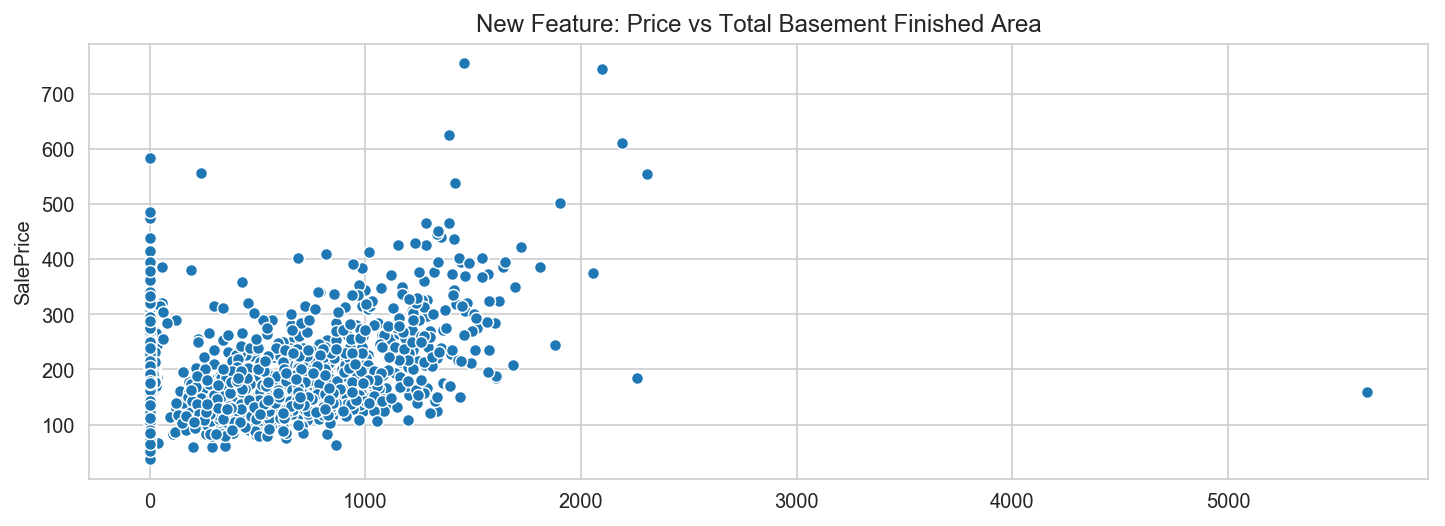

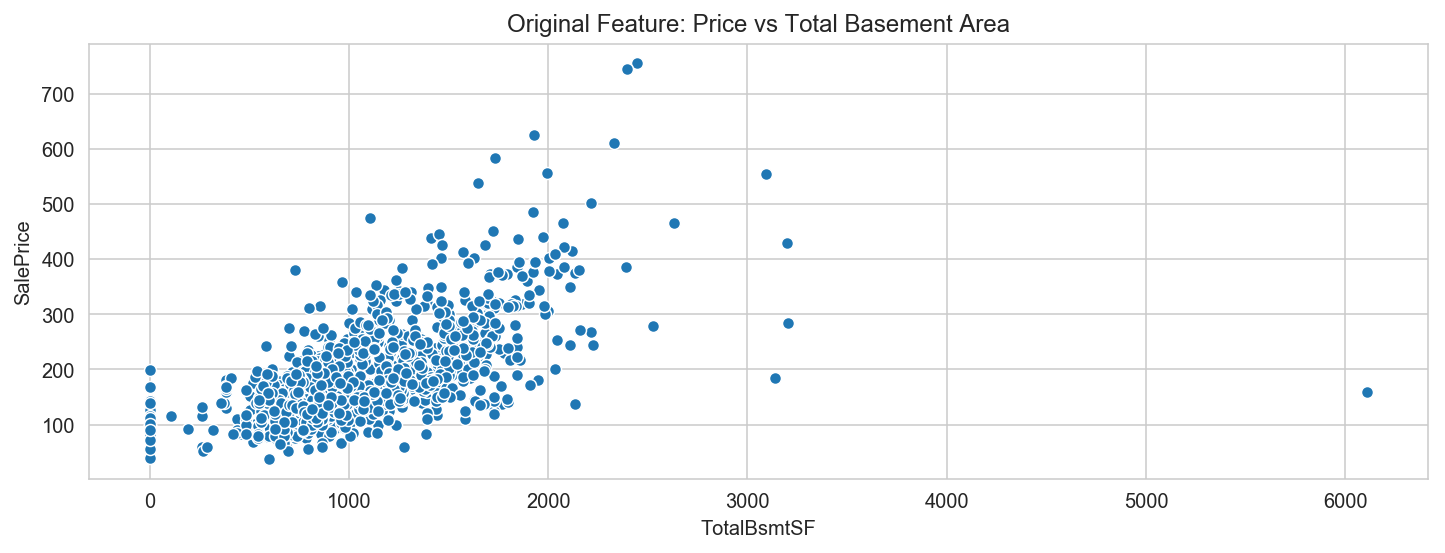

In [74]:
# Assessing new feature: Total Basement Finished Square Feet (BsmtFinSF1 + BsmtFinSF2)

TotalBsmtFinSF = house['BsmtFinSF1'] + house['BsmtFinSF2']

plt.figure(figsize= (12,4))
sns.scatterplot(TotalBsmtFinSF, house['SalePrice'])
plt.title('New Feature: Price vs Total Basement Finished Area')

plt.figure(figsize= (12,4))
sns.scatterplot(house['TotalBsmtSF'], house['SalePrice'])
plt.title('Original Feature: Price vs Total Basement Area')

plt.show()

# Not very obvious pattern with SalePrices
# Furthermore original feature (Price vs Total Basement Area) seems to have more obvious trend
# Hence assessed to not include this new feature

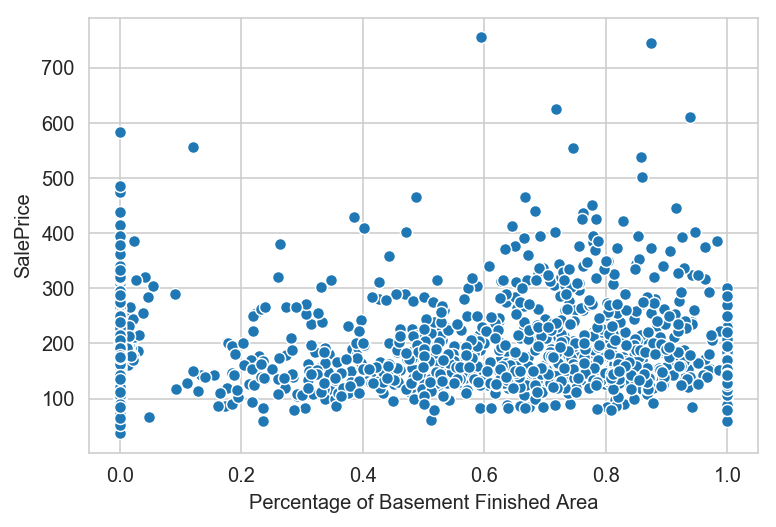

In [75]:
# Assessing new feature: Percentage of Basement Finished Area

TotalBsmtFinSFPercent = [0 if i == 0 else (TotalBsmtFinSF[index]/ i) for index,i in \
                         enumerate(house['TotalBsmtSF'])]

sns.scatterplot(TotalBsmtFinSFPercent, house['SalePrice'])
plt.xlabel('Percentage of Basement Finished Area')
plt.show()

# Not very obvious pattern with SalePrices
# Hence assessed to not include this new feature

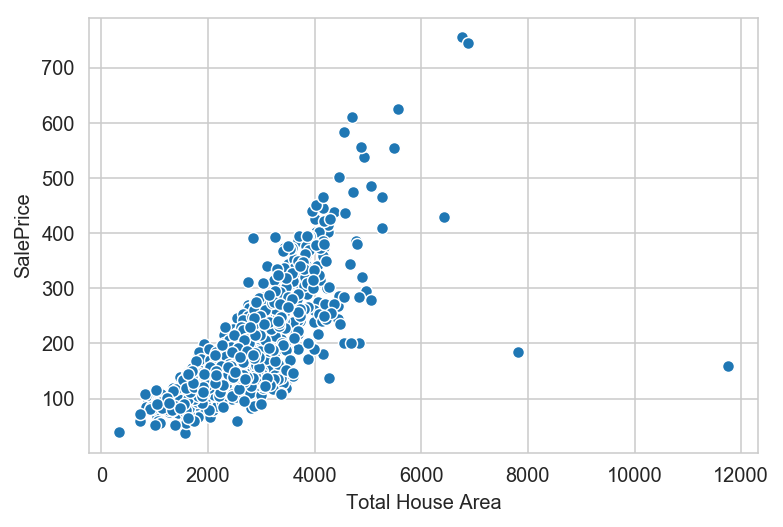

In [76]:
# Assessing new feature: TotalHouseArea (GrLivArea + TotalBsmtSF)
TotalHouseArea = house['GrLivArea'] + house['TotalBsmtSF']

sns.scatterplot(TotalHouseArea, house['SalePrice'])
plt.xlabel('Total House Area')
plt.show()

# Shows quite an obvious linear trend, a promising feature in predicting prices, to be included
house['TotalHouseArea'] = TotalHouseArea

In [77]:
# Drop these two columns to reduce effects of multicollinearity after introducing TotalHouseArea
# Afternote: model scored better without these parameters

house.drop(columns= ['GrLivArea', 'TotalBsmtSF'], inplace = True)

# Split/ Get Dummies / Standardise Data 
1) Split Fixed Features (cannot be change thru renovation) & Non-Fixed Features

2) Get Dummies for categorical features

3) Split train (Year Sold Before 2010) & test (2010)

4) Standardise

**1) Split Fixed Features (cannot be change thru renovation) & Non-Fixed Features**

In [78]:
house.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence',
       'MiscFeature', '

In [79]:
# based on my own judgement, these features are deemed to be fixed (not able to change with renovation)

fix_cols = """
MSSubClass
MSZoning
LotFrontage
Alley
Street
LotArea
LotShape
LandContour
LotConfig
LandSlope 
Neighborhood 
Condition1 
Condition2
condition_1n2
BldgType
HouseStyle 
YearBuilt 
YearRemodAdd
MasVnrType
MasVnrArea
Foundation
BsmtQual
BsmtExposure
BsmtFinType1 
BsmtFinType2
TotalBsmtSF
GrLivArea
BsmtFullBath
BsmtHalfBath 
FullBath 
HalfBath 
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd 
GarageType 
GarageYrBlt 
GarageCars 
GarageArea 
PavedDrive
WoodDeckSF 
OpenPorchSF 
EnclosedPorch 
3SsnPorch 
ScreenPorch 
PoolArea
MiscFeature
MiscVal
Fence
MoSold 
YrSold
Age_Sold
Remod_Age_Sold
SaleType
SaleCondition
TotalHouseArea
"""

fix_cols = fix_cols.split()
fix_cols[:5]

['MSSubClass', 'MSZoning', 'LotFrontage', 'Alley', 'Street']

In [80]:
# based on my own judgement, these features are deemed to be not fixed (able to change with renovation)

notfix_cols = """
OverallQual 
OverallCond 
RoofStyle 
RoofMatl
Exterior1st 
Exterior2nd 
ExterQual 
ExterCond 
BsmtCond
BsmtFinSF1
BsmtFinSF2 
BsmtUnfSF 
1stFlrSF
2ndFlrSF
Heating
HeatingQC
CentralAir 
Electrical 
LowQualFinSF
KitchenQual 
Functional 
Fireplaces 
FireplaceQu
GarageFinish 
GarageQual 
GarageCond 
"""

notfix_cols = notfix_cols.split()
notfix_cols[:5]

['OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st']

In [81]:
house_fix = house[[i for i in fix_cols if i in house.columns]]
house_nfix = house[[i for i in notfix_cols if i in house.columns]]

In [82]:
# To check that i have accounted all features in my fix and notfix lists

len(house_fix.columns) + len(house_nfix.columns) == len(house.columns) - 1  # -1 refers to SalePrice (target) 

True

**2) Get Dummies for categorical features**

In [83]:
house_fix = pd.get_dummies(house_fix, drop_first= True)
len(house_fix.columns)

164

**3) Split train (Year Sold Before 2010) & test (2010)**

In [84]:
# 172/1450 (12%) of houses YrSold == 2010
# this 12% portion will be segreted to test the model
# remaining 88% will be used to train the model

house_fix['YrSold'].value_counts()

2009    336
2007    328
2006    312
2008    302
2010    172
Name: YrSold, dtype: int64

In [85]:
# split dataframe to before 2010 (for training and validation) and 2010 (for testing)

X_train_fix_df = house_fix[house_fix['YrSold'] < 2010].reset_index(drop = True)
X_test_fix_df = house_fix[house_fix['YrSold'] == 2010].reset_index(drop = True)

In [86]:
X_train_fix_df.drop(columns= 'YrSold', inplace = True)
X_test_fix_df.drop(columns= 'YrSold', inplace = True)

**4) Standardise**

In [87]:
# To standardise both numerial and dummy variables
# May lose interpretability of the coefficients for the dummy variables, but to continue as objective now is for the
# model accuracy

sscaler = StandardScaler()
X_train_fix = sscaler.fit_transform(X_train_fix_df)

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [88]:
cols = X_train_fix_df.columns

In [89]:
# Assign targets

y_train = house[house['YrSold'] < 2010]['SalePrice']
y_test = house[house['YrSold'] == 2010]['SalePrice']

# Feature Selection

In [90]:
def score(X):
    """
    This function returns the mean and sd of cross_val_score based on linear regression with y_train
    """
    scores = cross_val_score(lr, X, y_train, cv=5)
    return scores.mean(), scores.std()

**RFE**

In [91]:
# Using RFECV with SRV linear model to seive out the important features
# This takes a while to run and score is not good, hence to leave out

# svr = SVR(kernel= 'linear')
# rfe_svr = RFECV(svr, cv= 3, step = 1)
# rfe_svr.fit(X_train_fix, y_train)
# rfe_svr_cols = list(cols[rfe_svr.support_])

In [92]:
# Using RFECV with linear regression model to seive out the important features

lr = LinearRegression()
rfe_lr = RFECV(lr, cv= 5, step = 1)
rfe_lr.fit(X_train_fix, y_train)
rfe_lr_cols = list(cols[rfe_lr.support_])

In [93]:
# number of columns chosen

len(rfe_lr_cols)

44

**Lasso**

In [94]:
# Using lasso to reduce model complexity and eliminate correlated features

lascv = LassoCV(n_alphas = 500, cv = 5, verbose = 1)
lascv.fit(X_train_fix, y_train)

las = Lasso(alpha= lascv.alpha_, random_state= 42)
las.fit(X_train_fix, y_train)
las_coefs = pd.DataFrame({'features':cols,
                            'coef':np.abs(las.coef_)})
las_coefs.sort_values('coef', inplace=True, ascending=False)
las_cols = list(las_coefs[las_coefs['coef'] > 0]['features']) # This is the list of features with coef > 0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [95]:
# To find out the number of features to achieve the best score

lasso_scores = pd.DataFrame()
mean = []
sd = []
for i in range(1, len(las_cols)):
    mean.append(score(sscaler.fit_transform(X_train_fix_df[las_cols[:i]]))[0])
    sd.append(score(sscaler.fit_transform(X_train_fix_df[las_cols[:i]]))[1])

lasso_scores['mean'] = mean
lasso_scores['sd'] = sd
lasso_scores.sort_values(by='mean', ascending= False)[:10] # Index here refers to the number of features

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all conver

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 w

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

mean        sd
42  0.805253  0.077670
39  0.804928  0.077617
41  0.804688  0.077602
38  0.803855  0.077880
37  0.803474  0.077119
36  0.803068  0.076994
40  0.802830  0.077331
35  0.802099  0.071969
32  0.802068  0.073859
30  0.801945  0.075494

In [96]:
# To get the top number of features that give the best score after lasso, assign the name of features to las_cols

las_cols = las_cols[:(lasso_scores.sort_values(by='mean', ascending= False).index[0]+1)]

**SelectKBest**

In [97]:
# Using selectkbest to pick top best features

skb_f = SelectKBest(f_classif)

# Train the selector on the data.
skb_f.fit(X_train_fix, y_train)
skb_f_scores = pd.DataFrame({'features': cols, 'f_scores': skb_f.scores_})
skb_f_scores.sort_values(by= 'f_scores', inplace= True, ascending= False)
skb_cols = list(skb_f_scores['features'])

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


In [98]:
# To find out the number of features to achieve the best score

skb_scores = pd.DataFrame()
mean = []
sd = []
for i in range(1, len(skb_cols)):
    mean.append(score(sscaler.fit_transform(X_train_fix_df[skb_cols[:i]]))[0])
    sd.append(score(sscaler.fit_transform(X_train_fix_df[skb_cols[:i]]))[1])

skb_scores['mean'] = mean
skb_scores['sd'] = sd
skb_scores.sort_values(by='mean', ascending= False)[:10] # Index here refers to the number of features

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 w

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConve

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConve

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConve

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConve

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

mean        sd
11  0.661755  0.092814
12  0.660861  0.093932
10  0.657758  0.100734
13  0.657147  0.097144
14  0.654669  0.101261
15  0.651446  0.101052
16  0.650320  0.101588
7   0.630020  0.114222
9   0.611420  0.120106
6   0.609487  0.130691

In [99]:
# To get the top number of features that give the best score after skb, assign the name of features to skb_cols

skb_cols = skb_cols[:(skb_scores.sort_values(by='mean', ascending= False).index[0]+1)]

**Test the set of features from each feature selection tools**

In [100]:
# Defining a function to test our best features head to head.

lr = LinearRegression()

# A list of all of our lists of best features being executed in the score function.
all_scores = [ 
    score(X_train_fix),
    score(sscaler.fit_transform(X_train_fix_df[rfe_lr_cols])),
    score(sscaler.fit_transform(X_train_fix_df[las_cols])),
    score(sscaler.fit_transform(X_train_fix_df[skb_cols]))]

# Putting results into a DataFrame.
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['all', 'rfelr', 'lasso', 'skb_f'])

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConve

mean score     std score
all   -5.059427e+24  1.011698e+25
rfelr  8.030791e-01  7.859793e-02
lasso  8.052534e-01  7.766963e-02
skb_f  6.617553e-01  9.281448e-02

In [101]:
# Defining a function to test our best features head to head.

lr = LinearRegression()

# A list of all of our lists of best features being executed in the score function.
all_scores = [ 
    score(X_train_fix),
    score(X_train_fix_df[rfe_lr_cols]),
    score(X_train_fix_df[las_cols]),
    score(X_train_fix_df[skb_cols])]

# Putting results into a DataFrame.
pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['all', 'rfelr', 'lasso', 'skb_f'])

mean score     std score
all   -5.059427e+24  1.011698e+25
rfelr  8.030792e-01  7.859804e-02
lasso  8.051783e-01  7.766851e-02
skb_f  6.932697e-01  7.779086e-02

In [102]:
# Lasso is preferred for feature selection as it gives the highest mean score and lowest standard deviation

# Prediction Model Selection

In [103]:
X_train_fix_las = sscaler.fit_transform(X_train_fix_df[las_cols])
X_test_fix_las = sscaler.transform(X_test_fix_df[las_cols])

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


**Using LinearRegression**

In [104]:
# Find the train score with linear regression model for comparison

lr = LinearRegression()
lr_train_fix = np.mean(cross_val_score(lr, X_train_fix_las, y_train, cv = 10)) # record the score
lr_train_fix

0.8083849607866253

In [105]:
# Find the test score with linear regression model only for reference
# Note: Test score will not be the basis for choosing my model, instead will use the highest train score

lr.fit(X_train_fix_las, y_train)
lr_test_fix = lr.score(X_test_fix_las, y_test) # record the score
lr_test_fix

0.8723715638332671

**Using SVM**

In [106]:
# This takes a while to run, hence commented out
# Results return best C = 3.162 and best gamma = 1e-05

# svr = SVR(kernel= 'linear')
# svr_para = {'C':np.logspace(-3, 4, 5), 'gamma':np.logspace(-5, 4, 5)}
# svr_gridsearch = GridSearchCV(svr, param_grid= svr_para, cv = 3, verbose = 1)
# svr_gridsearch.fit(X_train_fix_las, y_train)

In [107]:
# Training score from SVR 

svr = SVR(kernel= 'linear', C= 3.162, gamma= 10**(-5))
svr_train_fix = np.mean(cross_val_score(svr, X_train_fix_las, y_train, cv = 10))
svr_train_fix

0.8167907328783617

In [108]:
svr.fit(X_train_fix_las, y_train)
svr_test_fix = svr.score(X_test_fix_las, y_test)
svr_test_fix

0.877252816656728

**Using ElasticNet**

In [109]:
# Using ElasticNetCV to find the best alpha and l1_ratio

l1_ratios = np.linspace(0.01, 1.0, 25)

enetcv = ElasticNetCV(l1_ratio=l1_ratios, 
                            n_alphas=100,
                            cv=10, 
                            max_iter=10000)
enetcv.fit(X_train_fix_las, y_train)

print(enetcv.alpha_)
print(enetcv.l1_ratio_)

0.2370434533476666
0.2575


In [110]:
enet = ElasticNet(alpha= enetcv.alpha_, l1_ratio= enetcv.l1_ratio_)
enet_train_fix = np.mean(cross_val_score(enet, X_train_fix_las, y_train, cv = 10))
enet_train_fix

0.8190369385829197

In [111]:
# This is the R2 score. 
# The model performs 86% better compared to a model than constantly predicts the mean value

enet = ElasticNet(alpha= enetcv.alpha_, l1_ratio= enetcv.l1_ratio_)
enet.fit(X_train_fix_las, y_train)
y_hat_fix = enet.predict(X_test_fix_las)
enet_test_fix = enet.score(X_test_fix_las, y_test)
enet.score(X_test_fix_las, y_test)

0.8628839975539069

**Compare score from each model**

In [112]:
# Compare score from each model

compare_model = pd.DataFrame()
compare_model['lr'] = [lr_train_fix, lr_test_fix]
compare_model['svm'] = [svr_train_fix, svr_test_fix]
compare_model['enet'] = [enet_train_fix, enet_test_fix]

compare_model.index = ['train score', 'test score']

compare_model

lr       svm      enet
train score  0.808385  0.816791  0.819037
test score   0.872372  0.877253  0.862884

In [113]:
# Enet model is preferred
# Highest train score and also least difference with test score
# Test scores may be higher by chance due to the dataset
# Based on enet, the r2 score is 0.862 on the 2010 dataset.

# Result analysis with actual 2010 Sales Price

In [114]:
# Record enet train & test scores for comparison with Q2 later

train_score_fix = np.mean(cross_val_score(enet, X_train_fix_las, y_train, cv = 10))
test_score_fix = enet.score(X_test_fix_las, y_test)

In [115]:
# These are the 43 features used in the prediction model

features = pd.DataFrame()
features['features'] = las_cols
features['coef'] = enet.coef_
features['abs_coef'] = np.abs(enet.coef_)
features['features'].values

array(['TotalHouseArea', 'BsmtQual_Gd', 'Neighborhood_NridgHt',
       'BsmtQual_TA', 'Neighborhood_NoRidge', 'GarageCars',
       'Remod_Age_Sold', 'Neighborhood_StoneBr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'FullBath', 'Neighborhood_Crawfor',
       'BsmtFinType1_GLQ', 'BsmtExposure_Gd', 'condition_1n2_PosN',
       'Neighborhood_Somerst', 'HalfBath', 'BldgType_TwnhsE',
       'SaleType_New', 'BsmtQual_Fa', 'LotArea', 'Neighborhood_Edwards',
       'ScreenPorch', 'BsmtExposure_No', 'LotShape_IR3', 'BldgType_Twnhs',
       'WoodDeckSF', 'MasVnrArea', 'Age_Sold', 'MSSubClass_90',
       'Neighborhood_Veenker', 'GarageType_BuiltIn',
       'condition_1n2_FeedrNorm', 'LotConfig_CulDSac', 'BsmtFinType1_Unf',
       'condition_1n2_ArteryPosA', 'BedroomAbvGr', 'BsmtFullBath',
       'LotShape_IR2', 'LotConfig_FR2', 'MSSubClass_160',
       'Neighborhood_Mitchel', 'condition_1n2_NormRRAe'], dtype=object)

In [116]:
# These are the top 5 variables that are most inversely linearly correlated with sales price 

features.sort_values(by='coef')[:5]

features      coef  abs_coef
1      BsmtQual_Gd -8.561813  8.561813
3      BsmtQual_TA -6.889181  6.889181
6   Remod_Age_Sold -6.746991  6.746991
8     KitchenAbvGr -5.531717  5.531717
28        Age_Sold -4.685087  4.685087

In [117]:
# These are the top 5 variables that are most positively linearly correlated with sales price 

features.sort_values(by='coef', ascending= False)[:5]

features       coef   abs_coef
0        TotalHouseArea  20.228875  20.228875
2  Neighborhood_NridgHt  10.310612  10.310612
4  Neighborhood_NoRidge   9.328298   9.328298
5            GarageCars   9.113086   9.113086
9          TotRmsAbvGrd   8.698133   8.698133

In [118]:
# record the features for comparison with Q2
features_fix = features.sort_values(by='abs_coef', ascending= False)[:10]['features'] 

# These are the top 10 variables that are most linearly correlated with sales price 
features.sort_values(by='abs_coef', ascending= False)[:10]

features       coef   abs_coef
0         TotalHouseArea  20.228875  20.228875
2   Neighborhood_NridgHt  10.310612  10.310612
4   Neighborhood_NoRidge   9.328298   9.328298
5             GarageCars   9.113086   9.113086
9           TotRmsAbvGrd   8.698133   8.698133
1            BsmtQual_Gd  -8.561813   8.561813
10              FullBath   7.135267   7.135267
7   Neighborhood_StoneBr   6.983198   6.983198
3            BsmtQual_TA  -6.889181   6.889181
6         Remod_Age_Sold  -6.746991   6.746991

In [119]:
# record the rmse for comparison with Q2
rmse_fix = math.sqrt(mean_squared_error(y_test, y_hat_fix))

# This is the average difference (rmse) of predicted price vs actual price.
# Error of Price is in thousands 

math.sqrt(mean_squared_error(y_test, y_hat_fix))

29.524585532192095

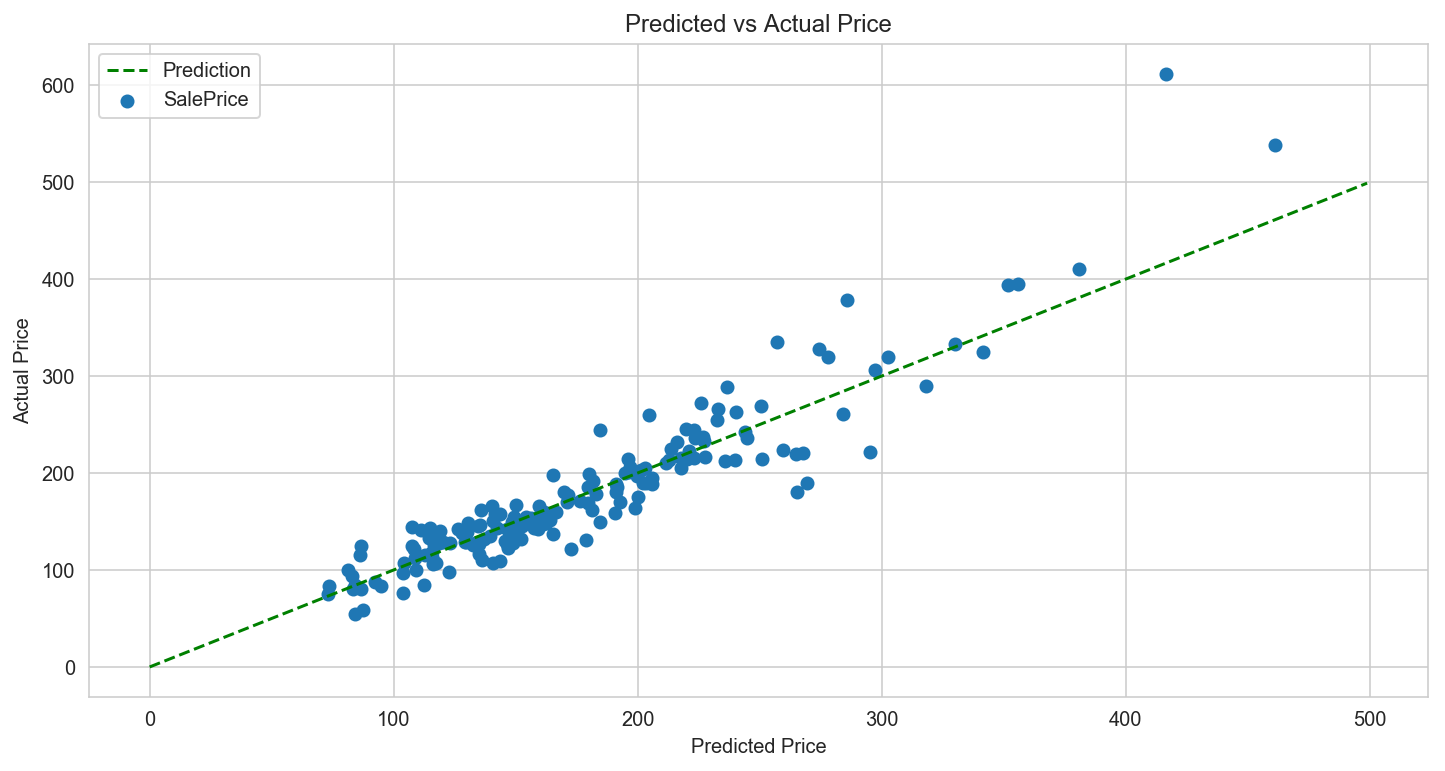

In [120]:
# Visualise Predicted Price against Actual Price

plt.figure(figsize=(12,6))
plt.scatter(y_hat_fix, y_test)
plt.plot(range(500), color='green', linestyle='dashed', label = 'Prediction')

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Predicted vs Actual Price')

plt.legend(loc = 2)

plt.show()

In [121]:
# In general, the model performs quite well in predicting prices below 250k, which accounts for the majority (90%).
# The model doesnt predict as well for very expensive houses (>$250k) which are out of the norm (i.e. outliers).

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [122]:
# I will create another prediction model with all the features.
# Compare the accuracy and betas of both models.

**Get Dummies for categorical features**

In [123]:
house_dummy = pd.get_dummies(house, drop_first= True)
len(house_dummy.columns)

267

**Split train (Year Sold Before 2010) & test (2010)**

In [124]:
# split dataframe to before 2010 (for training and validation) and 2010 (for testing)

X_train_all_df = house_dummy[house_dummy['YrSold'] < 2010].reset_index(drop = True)
X_test_all_df = house_dummy[house_dummy['YrSold'] == 2010].reset_index(drop = True)

In [125]:
X_train_all_df.drop(columns= ['YrSold','SalePrice'], inplace = True)
X_test_all_df.drop(columns= ['YrSold','SalePrice'], inplace = True)

**Standardise**

In [126]:
# To standardise both numerial and dummy variables
# May lose interpretability of the coefficients for the dummy variables, but to continue as objective now is for the
# model accuracy

sscaler = StandardScaler()
X_train_all = sscaler.fit_transform(X_train_all_df)

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [127]:
cols = X_train_all_df.columns

# Feature Selection

**Lasso**

In [128]:
# Previously lasso gives the best score.
# As more features are added this time, my guess is lasso should be more effective again in cutting features 
# Hence, to use lasso to reduce model complexity and eliminate correlated features

lascv = LassoCV(n_alphas = 500, cv = 5, verbose = 1)
lascv.fit(X_train_all, y_train)

las = Lasso(alpha= lascv.alpha_, random_state= 42)
las.fit(X_train_all, y_train)
las_coefs = pd.DataFrame({'features':cols, 'coef':np.abs(las.coef_)})
las_coefs.sort_values('coef', inplace=True, ascending=False)
las_cols = list(las_coefs[las_coefs['coef'] > 0]['features'])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [129]:
# To find out the number of features to achieve the best score

lasso_scores = pd.DataFrame()
mean = []
sd = []
for i in range(1, len(las_cols)):
    mean.append(score(sscaler.fit_transform(X_train_all_df[las_cols[:i]]))[0])
    sd.append(score(sscaler.fit_transform(X_train_all_df[las_cols[:i]]))[1])

lasso_scores['mean'] = mean
lasso_scores['sd'] = sd
lasso_scores.sort_values(by='mean', ascending= False)[:10] # Index here refers to the number of features

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 w

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 w

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64 w

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConve

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConve

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: 

mean        sd
51  0.840002  0.054059
50  0.839698  0.054136
46  0.839629  0.056597
53  0.839366  0.054137
47  0.839337  0.055943
39  0.839337  0.058452
52  0.839254  0.054345
49  0.839209  0.055060
54  0.839082  0.054802
48  0.838926  0.055852

In [130]:
# To get the top number of features that give the best score after lasso, assign the name of features to las_cols

las_cols = las_cols[:(lasso_scores.sort_values(by='mean', ascending= False).index[0]+1)]

# Prediction Model Selection

In [131]:
X_train_all_las = sscaler.fit_transform(X_train_all_df[las_cols])
X_test_all_las = sscaler.transform(X_test_all_df[las_cols])

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Jiahao\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


**Using LinearRegression**

In [132]:
# Find the train score with linear regression model for comparison

lr = LinearRegression()
lr_train_all = np.mean(cross_val_score(lr, X_train_all_las, y_train, cv = 10)) # record the score
lr_train_all

0.8393085741118244

In [133]:
# Find the test score with linear regression model only for reference
# Note: Test score will not be the basis for choosing my model, instead will use the highest train score

lr.fit(X_train_all_las, y_train)
lr_test_all = lr.score(X_test_all_las, y_test) # record the score
lr_test_all

0.880838879031995

**Using SVM**

In [134]:
# # This takes a while to run, hence commented out
# # Results return best C = 3.162 and best gamma = 1e-05

# svr = SVR(kernel= 'linear')
# svr_para = {'C':np.logspace(-3, 4, 5), 'gamma':np.logspace(-5, 4, 5)}
# svr_gridsearch = GridSearchCV(svr, param_grid= svr_para, cv = 3, verbose = 1)
# svr_gridsearch.fit(X_train_all_las, y_train)

In [135]:
# Training score from SVR 

svr = SVR(kernel= 'linear', C= 3.162, gamma= 10**(-5))
svr_train_all = np.mean(cross_val_score(svr, X_train_all_las, y_train, cv = 10))
svr_train_all

0.8466958487757206

In [136]:
# Test score from SVR

svr.fit(X_train_all_las, y_train)
svr_test_all = svr.score(X_test_all_las, y_test)
svr_test_all

0.8824960590581318

**Using ElasticNet**

In [137]:
# Using ElasticNetCV to find the best alpha and l1_ratio

l1_ratios = np.linspace(0.01, 1.0, 25)

enetcv = ElasticNetCV(l1_ratio=l1_ratios, 
                            n_alphas=100,
                            cv=10, 
                            max_iter=10000)
enetcv.fit(X_train_all_las, y_train)

print(enetcv.alpha_)
print(enetcv.l1_ratio_)

0.24263887054028016
0.2575


In [138]:
# Train score from enet

enet = ElasticNet(alpha= enetcv.alpha_, l1_ratio= enetcv.l1_ratio_)
enet_train_all = np.mean(cross_val_score(enet, X_train_all_las, y_train, cv = 10))
enet_train_all

0.8518674454474775

In [139]:
# Test score from enet

enet = ElasticNet(alpha= enetcv.alpha_, l1_ratio= enetcv.l1_ratio_)
enet.fit(X_train_all_las, y_train)
y_hat_all = enet.predict(X_test_all_las)
enet_test_all = enet.score(X_test_all_las, y_test)
enet_test_all

0.8747713624625422

**Compare score from each model**

In [140]:
# Compare score from each model

compare_model = pd.DataFrame()
compare_model['lr'] = [lr_train_all, lr_test_all]
compare_model['svm'] = [svr_train_all, svr_test_all]
compare_model['enet'] = [enet_train_all, enet_test_all]

compare_model.index = ['train score', 'test score']

compare_model

lr       svm      enet
train score  0.839309  0.846696  0.851867
test score   0.880839  0.882496  0.874771

In [141]:
# Enet model is preferred
# Highest train score and also least difference with test score
# Test scores may be higher by chance due to the dataset

# Comparing with Previous Model that only has fixed features

In [142]:
# Record the mean training and test scores

train_score_all = np.mean(cross_val_score(enet, X_train_all_las, y_train, cv = 10))
test_score_all = enet.score(X_test_all_las, y_test)

In [143]:
# These are the 41 features used in the prediction model with all features

features = pd.DataFrame()
features['features'] = las_cols
features['coef'] = enet.coef_
features['abs_coef'] = np.abs(enet.coef_)
features['features'].values

array(['OverallQual', 'TotalHouseArea', '2ndFlrSF',
       'Neighborhood_NridgHt', 'Neighborhood_NoRidge', 'GarageCars',
       'BsmtQual_Gd', 'RoofMatl_WdShngl', 'condition_1n2_PosN',
       'Neighborhood_StoneBr', 'BsmtQual_TA', 'KitchenQual_Gd',
       '1stFlrSF', 'SaleType_New', 'KitchenQual_TA', 'OverallCond',
       'BsmtExposure_Gd', 'FullBath', 'Remod_Age_Sold', 'KitchenAbvGr',
       'Age_Sold', 'Neighborhood_Crawfor', 'Fireplaces',
       'BldgType_TwnhsE', 'BsmtFinType1_GLQ', 'MSSubClass_20',
       'ExterQual_TA', 'LotArea', 'LotConfig_CulDSac', 'BsmtFullBath',
       'Exterior1st_BrkFace', 'BldgType_Twnhs', 'Neighborhood_Somerst',
       'TotRmsAbvGrd', 'BsmtFinType1_Unf', 'BsmtExposure_No',
       'MasVnrArea', 'RoofMatl_CompShg', 'WoodDeckSF', 'Functional_Typ',
       'LotShape_IR3', 'Exterior2nd_ImStucc', 'MSSubClass_160',
       'Neighborhood_Edwards', 'MSZoning_RM', 'condition_1n2_Norm',
       'ScreenPorch', 'RoofStyle_Gable', 'condition_1n2_FeedrNorm',
       'Neigh

In [144]:
# These are the top 5 variables that are most inversely linearly correlated with sales price 

features.sort_values(by='coef')[:5]

features      coef  abs_coef
6          BsmtQual_Gd -5.982334  5.982334
11      KitchenQual_Gd -5.356484  5.356484
14      KitchenQual_TA -5.162260  5.162260
8   condition_1n2_PosN -4.820187  4.820187
26        ExterQual_TA -4.778723  4.778723

In [145]:
# These are the top 5 variables that are most postively linearly correlated with sales price 

features.sort_values(by='coef', ascending= False)[:5]

features       coef   abs_coef
0           OverallQual  12.317988  12.317988
1        TotalHouseArea  10.347846  10.347846
3  Neighborhood_NridgHt   8.546563   8.546563
2              2ndFlrSF   8.524873   8.524873
4  Neighborhood_NoRidge   7.366945   7.366945

In [146]:
# record the features for comparison with Q1
features_all = features.sort_values(by='abs_coef', ascending= False)[:10]['features'] 

# These are the top 10 variables that are most linearly correlated with sales price 
features.sort_values(by='abs_coef', ascending= False)[:10]

features       coef   abs_coef
0            OverallQual  12.317988  12.317988
1         TotalHouseArea  10.347846  10.347846
3   Neighborhood_NridgHt   8.546563   8.546563
2               2ndFlrSF   8.524873   8.524873
4   Neighborhood_NoRidge   7.366945   7.366945
5             GarageCars   6.821043   6.821043
12              1stFlrSF   6.445479   6.445479
7       RoofMatl_WdShngl   6.222903   6.222903
6            BsmtQual_Gd  -5.982334   5.982334
9   Neighborhood_StoneBr   5.527462   5.527462

In [147]:
# record the rmse for comparison with Q1
rmse_all = math.sqrt(mean_squared_error(y_test, y_hat_all))

# This is the average difference (rmse) of predicted price vs actual price.
# Error of Price is in thousands 

math.sqrt(mean_squared_error(y_test, y_hat_all))

28.215747869763653

In [148]:
# Compare model with only fixed features and model with all features

compare_score = pd.DataFrame()
compare_score['Fixed Features'] = [train_score_fix, test_score_fix, rmse_fix]
compare_score['All Features'] = [train_score_all, test_score_all, rmse_all]
compare_score.index = ['train score', 'test score', 'rmse($k)']

compare_score

Fixed Features  All Features
train score        0.819037      0.851867
test score         0.862884      0.874771
rmse($k)          29.524586     28.215748

In [149]:
compare_features = pd.DataFrame([list(features_fix), list(features_all)]).T
compare_features.rename(columns={0:'Fixed Features', 1:'All Features'})

Fixed Features          All Features
0        TotalHouseArea           OverallQual
1  Neighborhood_NridgHt        TotalHouseArea
2  Neighborhood_NoRidge  Neighborhood_NridgHt
3            GarageCars              2ndFlrSF
4          TotRmsAbvGrd  Neighborhood_NoRidge
5           BsmtQual_Gd            GarageCars
6              FullBath              1stFlrSF
7  Neighborhood_StoneBr      RoofMatl_WdShngl
8           BsmtQual_TA           BsmtQual_Gd
9        Remod_Age_Sold  Neighborhood_StoneBr

In [150]:
# 1) Model with all features (fixed and reno) has marginal better R2 scores and RSME as compared to model with just 
#  fixed features.
 
# 2) The reno features like Overall Qualility, having Good for Basement Quality and having Wood Shingles for Roof Material 
# help to marginally improve the model which were missing in the fixed features.

# 3) The difference in RMSE is $1.3k which mean the model with all features is able to predict about $1.3k more
# more accurate on average than the model with just reno features.

# 4) The OverallQual reno feature is weighted the most when comes to predicting the prices, with a coefficient of 
# 12.3, which means that for each +1 gain of the overall material and finish quality of the house, the price is expected 
# to increase by 12.3k.

# 5) This new model can help the company to decide if the newly acquired house should be renovated to increase OverallQual
# and gained extra profit based on the price increased calculated from OverallQual beta minus the renovation cost.

# 6) If the data on rennovation features is not available, the company can rely on the model with fixed features with
# slight compromise ($1.3k error) on the price prediction.

# 7) The old and new model can be trusted with an average error in predicted price of about $28-29k. As further shown 
# below, the error will be lesser if sale prices are expected to be below $250k, which covers 90% of the data.

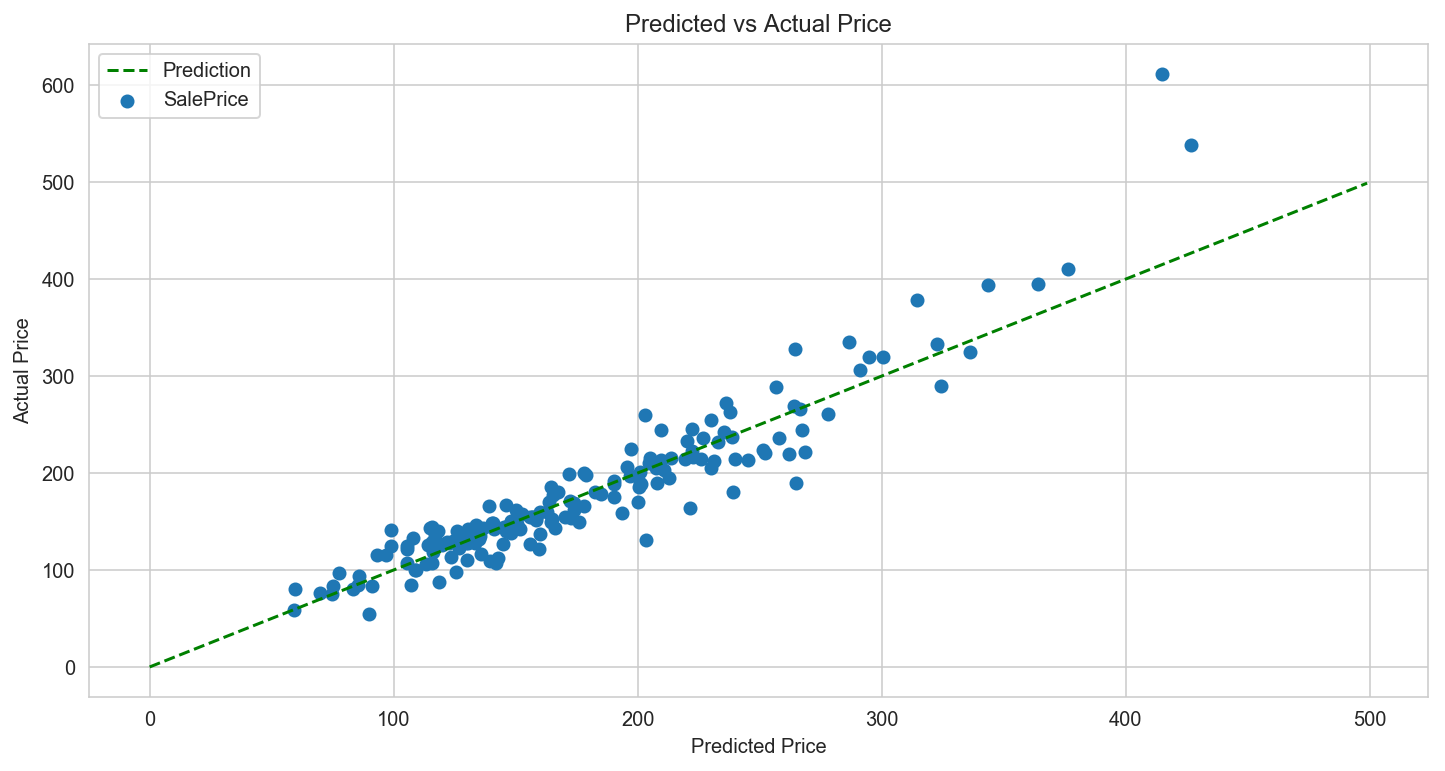

In [151]:
# Visualise Predicted Price against Actual Price

plt.figure(figsize=(12,6))
plt.scatter(y_hat_all, y_test)
plt.plot(range(500), color='green', linestyle='dashed', label = 'Prediction')

plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Predicted vs Actual Price')

plt.legend(loc = 2)

plt.show()

In [152]:
# Likewise to previouse model in Q1, in general, the model performs quite well in predicting prices below 250k, 
# which accounts for the majority (90%).
# The model doesnt predict as well for very expensive houses (>$250k) which are out of the norm (i.e. outliers).

In [153]:
residual_fix = y_test - y_hat_fix
fix_underestimate = np.mean(residual_fix)
fix_sd = residual_fix.std()

residual_all = y_test - y_hat_all
all_underestimate = np.mean(residual_all)
all_sd = residual_all.std()

print('How much fixed model is underestimating prices:', fix_underestimate)
print('How much all model is underestimating prices:', all_underestimate)
print('')

print('fixed model accuracy standard deviation :', fix_sd)
print('all model accuracy standard deviation :', all_sd)

How much fixed model is underestimating prices: 1.2438251899770785
How much all model is underestimating prices: 1.2058213978435508

fixed model accuracy standard deviation : 29.584500501418812
all model accuracy standard deviation : 28.27227690604751


In [154]:
# On average, the fixed-model is underestimating the prices more than the all-model.
# Hence to be conservative, company can choose to use the fixed-model when looking for under-valued houses to acquire for 
# turnover profit.

# However the all-model is slightly more consistent with the accuracy in price prediction based on a lower sd.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [155]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE # imblearn library required to be installed
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Preprocessing Data

In [156]:
# Abnormal only accounts for 6% -> imbalance data

house['SaleCondition'].value_counts()

Normal     1194
Partial     125
Abnorml      96
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [157]:
# Group all non-abnormal entries together

house['SaleCondition'] = house['SaleCondition'].map(lambda x: 1 if x =='Abnorml' else 0)
house['SaleCondition'].value_counts()

0    1354
1      96
Name: SaleCondition, dtype: int64

In [158]:
# Split predictors and target
# Get dummies and standarise predictors

X_df = house[[i for i in house.columns if i != 'SaleCondition']]
X_df = pd.get_dummies(X_df)
X = sscaler.fit_transform(X_df)
target = house['SaleCondition']

C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Jiahao\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [159]:
# Calculate the baseline accuracy
# The baseline accuracy is high due to imbalanced dataset, hence the need to resample data (e.g. upsample, downsample)
#  for validation of model

target.value_counts()/len(target)

0    0.933793
1    0.066207
Name: SaleCondition, dtype: float64

In [160]:
# Stratify split train (80%) and test (20%)

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size = 0.2, stratify = target, \
                                                              random_state=42)

In [161]:
# Check that the proportions of class 1 are similar for training and test sets

print(target_train.value_counts())
print(target_test.value_counts())

0    1083
1      77
Name: SaleCondition, dtype: int64
0    271
1     19
Name: SaleCondition, dtype: int64


# **Upsample with SMOTE**

In [162]:
# By using SMOTE to upsample class 1 to match the number of class 0
# Note: only upsample the training set, not the test sample

sm = SMOTE(random_state= 42)
X_train_smote, target_train_smote = sm.fit_sample(X_train, target_train)

# Check that the number of class 1 = class 0
print(sum(target_train_smote==1), sum(target_train_smote==0))

1083 1083


# Model Selection

In [163]:
# Objective: 
# To find the model with highest true positive rate or recall (predict abnormal houses to be abnormal correctly)
# and yet sufficiently low false positive rate (do not want to wrongly predict every non-abnormal houses to be abnormal, 
# which might waste resources or time).

# Hence scoring criteria will be scoring='roc_auc'

**Model 1: Logistic Regression**

In [164]:
# # To perform gridsearch on logistic regression to find the best C
# # # This takes a while to run, hence commented out
# # # Results return best C = 1.0

# logr = LogisticRegression(penalty = 'l1', random_state= 42, solver= 'liblinear')
# logr_para = {'C': np.linspace(1, 10, 10)}

# logr_gridsearch = GridSearchCV(logr, param_grid= logr_para, cv=5, scoring='roc_auc', verbose=1)
# logr_gridsearch.fit(X_train_smote, target_train_smote)

In [165]:
# Using C = 1 from gridsearch to perform logistic regression

best_logr = LogisticRegression(C = 1, penalty = 'l1', random_state= 42, solver= 'liblinear')
best_logr.fit(X_train_smote, target_train_smote)
pred_logr = best_logr.predict(X_test) #get predictions for comparison with other models later

**Model 2: SVC**

In [166]:
# # To perform gridsearch on SVC to find the best C and gamma
# # This takes a while to run, hence commented out
# # Results return best C = 0.0177827 and best gamma = 1e-05

# svc = SVC(random_state= 42)
# svc_para = {'C': np.logspace(-3, 2, 5), 'gamma': np.logspace(-5, 2, 8), 'kernel': ['linear']}
# svc_gridsearch = GridSearchCV(svc, param_grid= svc_para, cv = 3, scoring='roc_auc', verbose= 1, n_jobs=-1)
# svc_gridsearch.fit(X_train_smote, target_train_smote)

In [167]:
# Using best parameters found from above gridsearch

best_svc = SVC(C=0.0177827, gamma = 1**(-5), kernel= 'linear', random_state= 42) #only linear kernel returns .coef
best_svc.fit(X_train_smote, target_train_smote)
pred_svc = best_svc.predict(X_test) #get predictions for comparison with other models later

**Model 3: DTC**

In [168]:
# # # To perform gridsearch on dtc to find the best parameters
# # # This takes a while to run, hence commented out
# # # Best Results return {'criterion': 'entropy','max_depth': None,'max_features': None,'min_samples_split': 50}

# dtc_para = {'criterion':['gini', 'entropy'], 'max_depth':[None,1,2,3,4], 'max_features':[None,'log2','sqrt',2,3,4,5], 
#             'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]}

# dtc_gridsearch = GridSearchCV(DecisionTreeClassifier(), dtc_para, cv=5, verbose=1, scoring='roc_auc', n_jobs=-1)
# dtc_gridsearch.fit(X_train_smote, target_train_smote)

In [169]:
# Using best parameters found from above gridsearch

best_dtc = DecisionTreeClassifier(criterion= 'entropy', max_depth= None, max_features= None, min_samples_split= 20, 
                                  random_state= 42)
best_dtc.fit(X_train_smote, target_train_smote)
pred_dtc = best_dtc.predict(X_test) #get predictions for comparison with other models later

**Model 4: RFC**

In [170]:
rfc = RandomForestClassifier

In [171]:
# # # To perform gridsearch on rfc to find the best parameters
# # # This takes a while to run, hence commented out
# # # Best Results return {'criterion': 'gini', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 500}

# rfc_para = {'n_estimators': [200, 500], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth' : [4,5,6,7,8], 
#              'criterion' :['gini', 'entropy']}

# rfc_gridsearch = GridSearchCV(RandomForestClassifier(), param_grid= rfc_para, cv= 5, verbose=1, scoring='roc_auc', 
#                               n_jobs=-1)
# rfc_gridsearch.fit(X_train_smote, target_train_smote)

In [172]:
# Using best parameters found from above gridsearch

best_rfc = RandomForestClassifier(criterion= 'gini', max_depth= 8, max_features= 'sqrt', n_estimators= 500, 
                                  random_state= 42)
best_rfc.fit(X_train_smote, target_train_smote)
pred_rfc = best_rfc.predict(X_test) #get predictions for comparison with other models later

# Models Comparison

In [173]:
print('logr')
print(classification_report(target_test, pred_logr))
print('------------------------------------------')
print('svc')
print(classification_report(target_test, pred_svc))
print('------------------------------------------')
print('dtc')
print(classification_report(target_test, pred_dtc))
print('------------------------------------------')
print('rfc')
print(classification_report(target_test, pred_rfc))

logr
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       271
           1       0.12      0.32      0.18        19

   micro avg       0.81      0.81      0.81       290
   macro avg       0.54      0.58      0.54       290
weighted avg       0.89      0.81      0.85       290

------------------------------------------
svc
              precision    recall  f1-score   support

           0       0.96      0.81      0.88       271
           1       0.15      0.47      0.23        19

   micro avg       0.79      0.79      0.79       290
   macro avg       0.55      0.64      0.55       290
weighted avg       0.90      0.79      0.83       290

------------------------------------------
dtc
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       271
           1       0.29      0.42      0.34        19

   micro avg       0.89      0.89      0.89       290
   macro avg       0.62      

In [174]:
# Comparing recall scores for class 0 (1- false positive rate) and
# recall scores for class 1 (true positive rate)

# SVC gives the best true positive rate of 0.47 (predict about 9 out of 19 abnormal cases correctly) with slightly ok
# (1-false positive rate) of 0.81 (wrongly predict about 52 out 271 non-abnormal cases to be abnormal)

# DTC gives the second best true positive rate of 0.42 but a much higher (1-false positive rate) of 0.92
# Furthermore DTC gives the highest roc_auc score of 0.67 (labelled as macro avg) compared to 0.64 from SVC

# I will choose DTC model over the rest

# Feature Importances

**Important Features for DTC Model**

In [175]:
# These are the top 10 most important features for prediction with DTC model
# DTC doesnt give negative coef for features

coef_dtc_df = pd.DataFrame(np.abs(best_dtc.feature_importances_), columns= ['abs_coef'])
coef_dtc_df['coef'] = best_dtc.feature_importances_
coef_dtc_df['features'] = X_df.columns
coef_dtc_df.sort_values(by = 'abs_coef', ascending= False).head(10)

abs_coef      coef             features
84   0.259751  0.259751   Neighborhood_NAmes
234  0.107199  0.107199       FireplaceQu_Gd
136  0.096013  0.096013  Exterior1st_VinylSd
147  0.094756  0.094756  Exterior2nd_MetalSd
277  0.059075  0.059075         SaleType_COD
152  0.043023  0.043023  Exterior2nd_VinylSd
194  0.038686  0.038686     BsmtFinType1_Rec
50   0.025469  0.025469          MSZoning_RH
30   0.021347  0.021347            SalePrice
31   0.018560  0.018560             Age_Sold

**Important Features for SVC Model**

In [176]:
# These are the top 10 most important features for prediction with SVC model

coef_svc_df = pd.DataFrame(np.abs(best_svc.coef_.T), columns= ['abs_coef'])
coef_svc_df['coef'] = best_svc.coef_.T
coef_svc_df['features'] = X_df.columns
coef_svc_df.sort_values(by = 'abs_coef', ascending= False).head(10)

abs_coef      coef              features
30   0.612397 -0.612397             SalePrice
277  0.473851  0.473851          SaleType_COD
283  0.354005 -0.354005          SaleType_New
158  0.339239  0.339239      MasVnrType_Stone
88   0.337489 -0.337489  Neighborhood_NridgHt
185  0.323823 -0.323823       BsmtExposure_Gd
245  0.317838 -0.317838   GarageYrBlt_Aft2000
221  0.312707  0.312707        KitchenQual_Ex
32   0.296493  0.296493        Remod_Age_Sold
2    0.293764  0.293764           OverallQual

In [177]:
# These are the top 5 features positively correlated with abnormal prediction with SVC model

coef_svc_df.sort_values(by = 'coef', ascending= False).head(5)

abs_coef      coef          features
277  0.473851  0.473851      SaleType_COD
158  0.339239  0.339239  MasVnrType_Stone
221  0.312707  0.312707    KitchenQual_Ex
32   0.296493  0.296493    Remod_Age_Sold
2    0.293764  0.293764       OverallQual

In [178]:
# These are the top 5 features negatively correlated with abnormal prediction with SVC model

coef_svc_df.sort_values(by = 'coef', ascending= True).head(5)

abs_coef      coef              features
30   0.612397 -0.612397             SalePrice
283  0.354005 -0.354005          SaleType_New
88   0.337489 -0.337489  Neighborhood_NridgHt
185  0.323823 -0.323823       BsmtExposure_Gd
245  0.317838 -0.317838   GarageYrBlt_Aft2000